In [1]:
import tseriesRoutines as routines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import ceil
from math import sqrt
import sqlite3
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.api as smt
import seaborn as sns
import statsmodels.api as sm
import warnings
import itertools

In [2]:
def genData(mongoid, conn, cursor, impute=True, freq='daily', standardize=False):
    '''
    Generate a timeseries dataframe for ARIMA modelling.
    mongoid: str. string of mongodb id.
    conn: sqlite3 connection.
    cursor: sqlite3 cursor.
    impute:
    freq:
    actualrevcount:
    standardize
    Example:
    product = genData('5aa2ad7735d6d34b0032a795', conn, c, impute=True, 
       freq='daily', actualrevcount=20, standardize=True)
    '''
    initial = routines.sqlToDf(conn, cursor)
    allproduct = initial.selectReview3(mongoid, impute=impute)
    product = routines.tsSalesRateSentiment(allproduct, freq=freq, standardize=standardize)
    return product

In [3]:
# Jeffrey Yau
def tsplot(y, title, lags=None, figsize=(12, 8)):
    '''
    Examine the patterns of ACF and PACF, along with the time series
    plot and histogram.
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title, fontsize=14, fontweight='bold')
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

In [4]:
#https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
def detpq(data, par=range(0,6)):
    '''
    Determine values of p & q that minimize AICc

    par: python range. parameter
    data: numpy ndarray or pandas series.
        y_train['Sales'].values
    sdfa
    '''
    # Define the p and q parameters to take any value between 0 and 2
    p = q = par
    
    # Generate all different combinations of p and q triplets
    pq = list(itertools.product(p, q))

    warnings.filterwarnings("ignore") # specify to ignore warning messages
    AIC_list = pd.DataFrame({}, columns=['param','AIC'])
    for param in pq:
        try:
            mod = sm.tsa.VARMAX(data, order=param)
            results = mod.fit()
            #print('ARIMA{} - AIC:{}'.format(param, 
            #    sm.tools.eval_measures.aicc(results.llf, 
            #        results.nobs, results.df_model)))
            temp = pd.DataFrame([[ param ,  results.bic ]], 
                columns=['param', 'AIC'])
            AIC_list = AIC_list.append( temp, ignore_index=True)
            del temp
        except:
            continue

    AIC_list = AIC_list.sort_values(by='AIC').reset_index()
    AIC_list.columns = ['index', 'param', 'BIC']
    return AIC_list

In [5]:
# make connection to sqlite db
conn = sqlite3.connect('product.db')
c = conn.cursor()

# enable foreign keys
c.execute("PRAGMA foreign_keys = ON")
conn.commit()

In [6]:
# result reproducibility
np.random.seed(42)

<br>pilihan:
>     2 data di database product.db dgn review > 900:
>         5aa2ad7735d6d34b0032a795
>         5aa39533ae1f941be7165ecd
>     cluster 3
>         5a93e8768cbad97881597597
>         or 
>         5a95d7ae35d6d33d3fea56ff
>     cluster 1
>         5aa2c35e35d6d34b0032a796
>     cluster 2 
>         5a92474635d6d32207bcd343
</br>

## <font color=blue> 1. Mongodb ID: 5aa2ad7735d6d34b0032a795 </font>

In [7]:
prod1 = genData('5aa2ad7735d6d34b0032a795', conn, c, impute=False, freq='daily', standardize=False)

In [8]:
prod1.head()

Sales    rating  ovsentiment
date                                    
2016-11-06      2  3.500000     0.500000
2016-11-07      1  5.000000     1.000000
2016-11-08      0  0.000000     0.000000
2016-11-09      0  0.000000     0.000000
2016-11-10      3  4.666667     0.333333

In [9]:
prod1 = prod1[prod1['Sales'] != 0]

In [10]:
prod1.shape

(332, 3)

In [11]:
# Stationarity test (Augmented Dickey-Fuller test)
prod1Test = routines.tsTest(prod1['Sales'], '5aa2ad7735d6d34b0032a795')
prod1Test.adfuller()

5aa2ad7735d6d34b0032a795


Value                        Label
0 -6.673059e+00               Test Statistic
1  7.649768e-08                      p-value
2  3.000000e+00                   #Lags Used
3  3.280000e+02  Number of Observations Used
4 -3.986639e+00        Critical value for 1%
5 -3.423961e+00        Critical value for 5%
6 -3.134970e+00       Critical value for 10%

In [13]:
# Stationarity test (Augmented Dickey-Fuller test)
prod1Test = routines.tsTest(prod1['rating'], '5aa2ad7735d6d34b0032a795')
prod1Test.adfuller()

5aa2ad7735d6d34b0032a795


Value                        Label
0  -20.585629               Test Statistic
1    0.000000                      p-value
2    0.000000                   #Lags Used
3  331.000000  Number of Observations Used
4   -3.986384        Critical value for 1%
5   -3.423838        Critical value for 5%
6   -3.134898       Critical value for 10%

In [14]:
# Stationarity test (Augmented Dickey-Fuller test)
prod1Test = routines.tsTest(prod1['ovsentiment'], '5aa2ad7735d6d34b0032a795')
prod1Test.adfuller()

5aa2ad7735d6d34b0032a795


Value                        Label
0 -6.967397e+00               Test Statistic
1  1.674369e-08                      p-value
2  3.000000e+00                   #Lags Used
3  3.280000e+02  Number of Observations Used
4 -3.986639e+00        Critical value for 1%
5 -3.423961e+00        Critical value for 5%
6 -3.134970e+00       Critical value for 10%

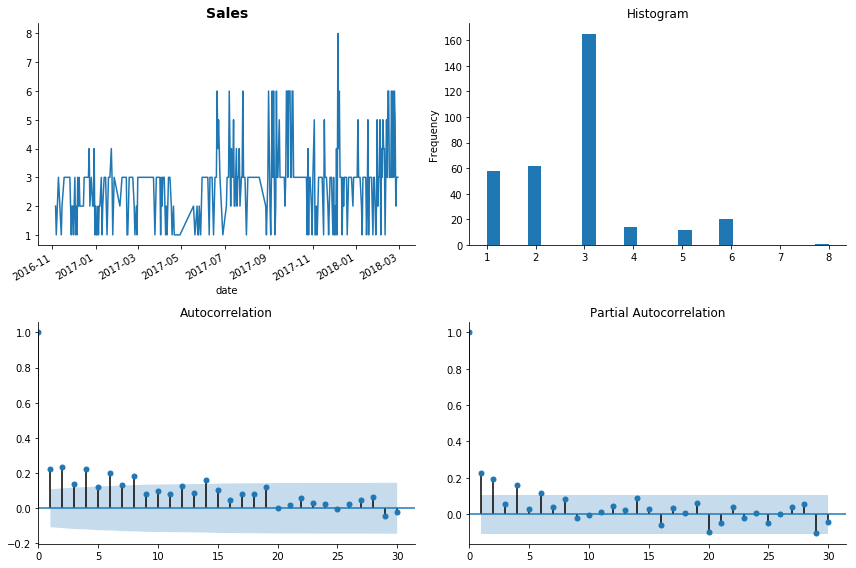

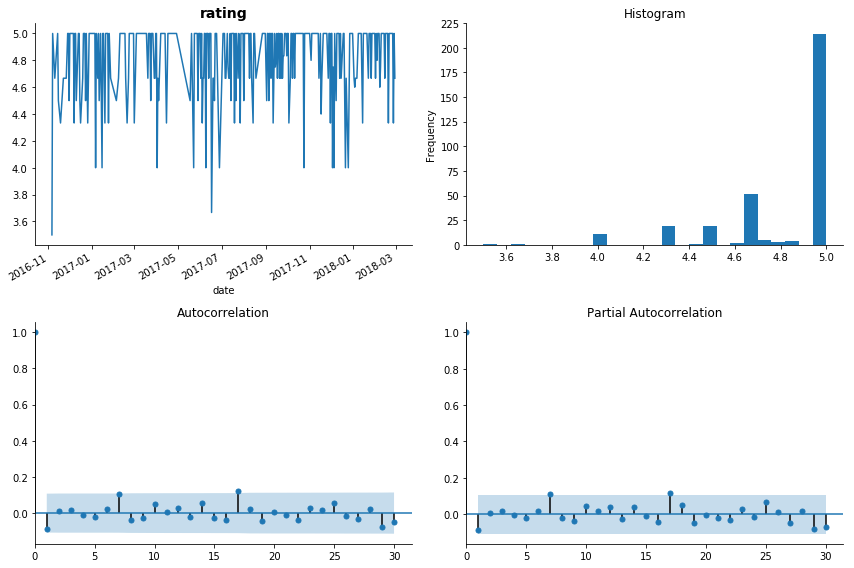

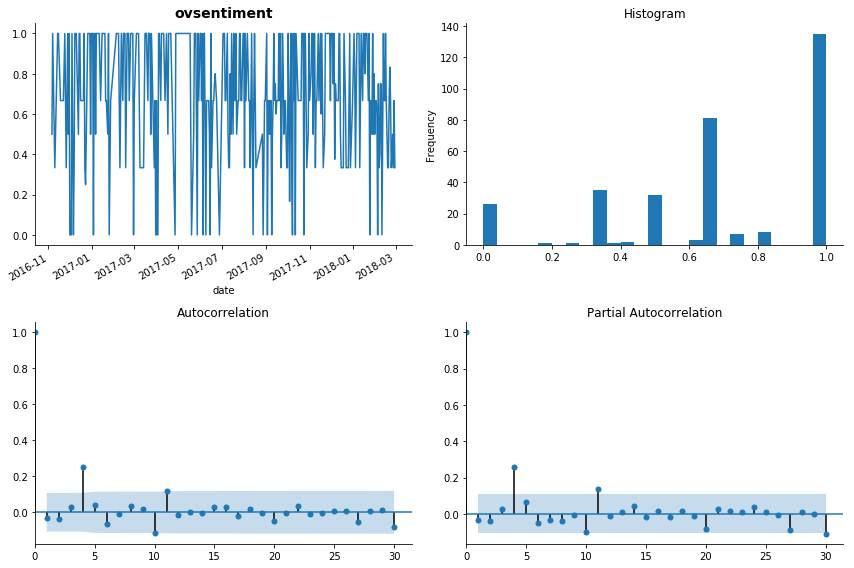

In [15]:
num_var1 = len(prod1.iloc[1, :])
for i in range(0, num_var1):
    tsplot(prod1.iloc[:, i].dropna(), title=prod1.columns[i], lags=30)
plt.show()

In [16]:
plt.clf()

<Figure size 432x288 with 0 Axes>

In [17]:
prod1_transformed = prod1.copy()
prod1_transformed['Sales'] = np.log(prod1_transformed['Sales'])
prod1_transformed['Sales'] = prod1_transformed['Sales'].diff(1)

In [18]:
prod1_transformed['rating'] = prod1_transformed['rating'].diff(1)
prod1_transformed['ovsentiment'] = prod1_transformed['ovsentiment'].diff(1)

In [19]:
prod1_transformed.dropna(inplace=True)

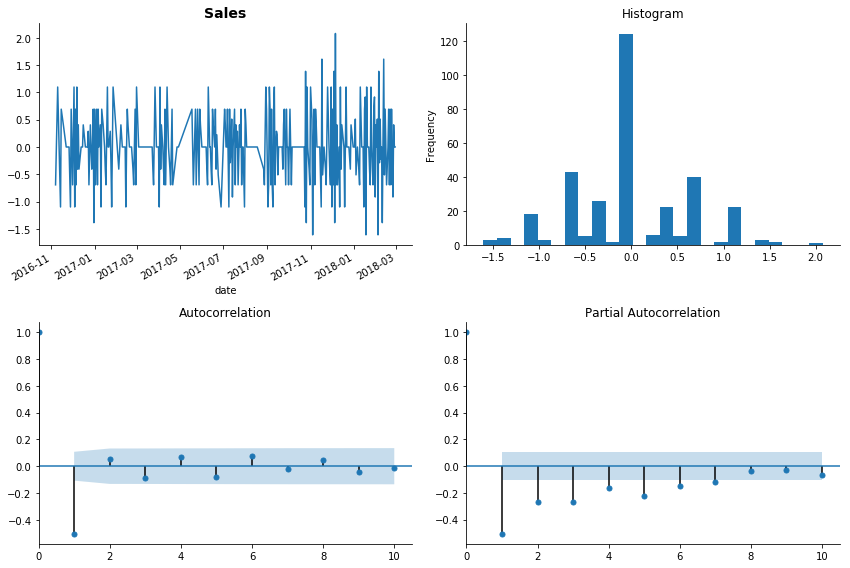

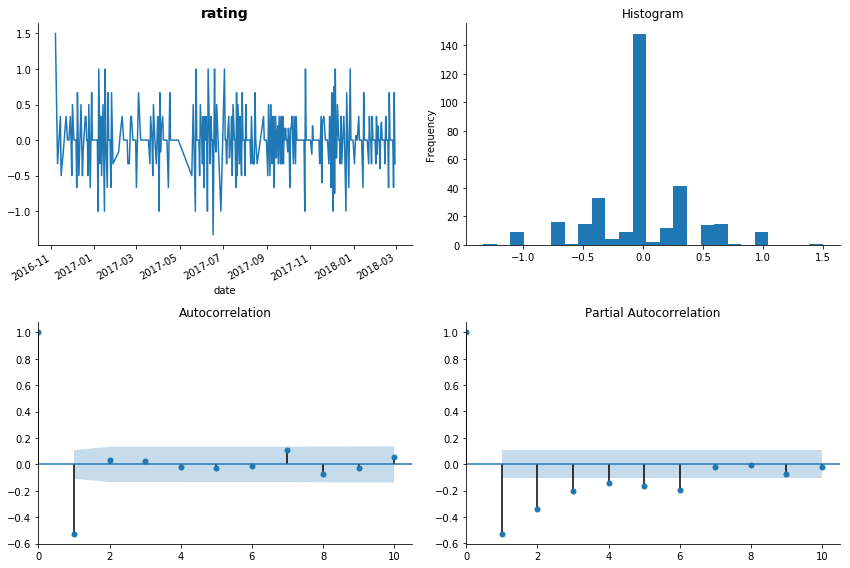

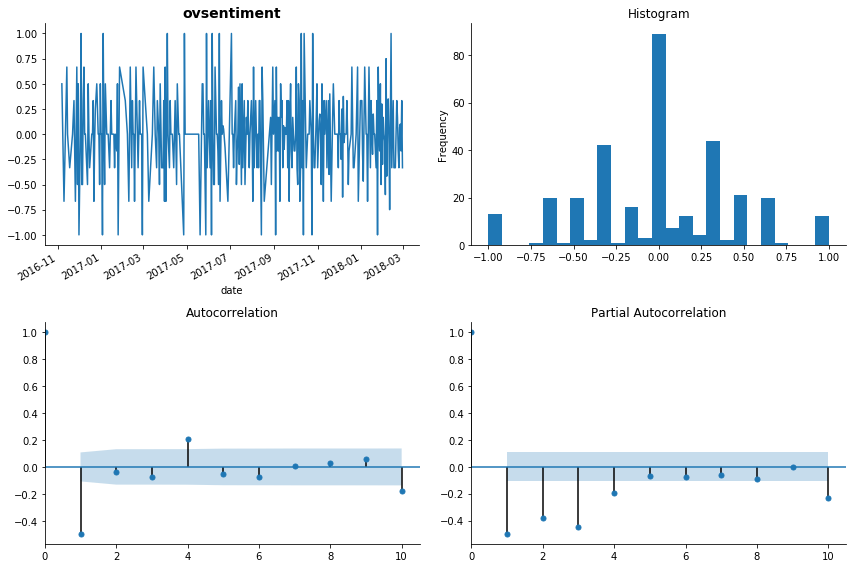

In [20]:
num_var1 = len(prod1_transformed.iloc[1, :])
for i in range(0, num_var1):
    tsplot(prod1_transformed.iloc[:, i].dropna(), title=prod1_transformed.columns[i], lags=10)
plt.show()

In [21]:
plt.clf()

<Figure size 432x288 with 0 Axes>

In [22]:
# Stationarity test (Augmented Dickey-Fuller test)
prod1_transformedTest = routines.tsTest(prod1_transformed['Sales'].dropna(), '5aa2ad7735d6d34b0032a795')
prod1_transformedTest.adfuller()

5aa2ad7735d6d34b0032a795


Value                        Label
0 -1.162605e+01               Test Statistic
1  1.622437e-18                      p-value
2  6.000000e+00                   #Lags Used
3  3.240000e+02  Number of Observations Used
4 -3.986986e+00        Critical value for 1%
5 -3.424128e+00        Critical value for 5%
6 -3.135068e+00       Critical value for 10%

In [23]:
# Stationarity test (Augmented Dickey-Fuller test)
prod1_transformedTest = routines.tsTest(prod1_transformed['rating'].dropna(), '5aa2ad7735d6d34b0032a795')
prod1_transformedTest.adfuller()

5aa2ad7735d6d34b0032a795


Value                        Label
0 -7.914636e+00               Test Statistic
1  1.125561e-10                      p-value
2  1.600000e+01                   #Lags Used
3  3.140000e+02  Number of Observations Used
4 -3.987894e+00        Critical value for 1%
5 -3.424565e+00        Critical value for 5%
6 -3.135325e+00       Critical value for 10%

In [24]:
# Stationarity test (Augmented Dickey-Fuller test)
prod1_transformedTest = routines.tsTest(prod1_transformed['ovsentiment'].dropna(), '5aa2ad7735d6d34b0032a795')
prod1_transformedTest.adfuller()

5aa2ad7735d6d34b0032a795


Value                        Label
0 -8.574243e+00               Test Statistic
1  3.388159e-12                      p-value
2  1.200000e+01                   #Lags Used
3  3.180000e+02  Number of Observations Used
4 -3.987524e+00        Critical value for 1%
5 -3.424387e+00        Critical value for 5%
6 -3.135220e+00       Critical value for 10%

In [25]:
# Train-Test Set Split
train1 = ceil(prod1_transformed.shape[0] * 0.8)
y_train1 = prod1_transformed[0:train1]
y_test1 = prod1_transformed[train1:]
y_train1.shape, y_test1.shape

((265, 3), (66, 3))

In [26]:
y_train1.dropna().shape

(265, 3)

In [27]:
BIC1 = detpq(y_train1, par=range(0,6))

In [28]:
BIC1

index   param          BIC
0       0  (0, 1)   691.842512
1       6  (1, 1)   732.514559
2       7  (1, 2)   773.239401
3      12  (2, 1)   775.617208
4      18  (3, 1)   818.365671
5      13  (2, 2)   821.344448
6       1  (0, 2)   828.378766
7       8  (1, 3)   845.563196
8      19  (3, 2)   851.326060
9      17  (3, 0)   855.054145
10     24  (4, 1)   864.235598
11     23  (4, 0)   867.812732
12     14  (2, 3)   868.310364
13      3  (0, 4)   879.424143
14      2  (0, 3)   881.274953
15      9  (1, 4)   881.648526
16     29  (5, 0)   892.403703
17     25  (4, 2)   900.322193
18     30  (5, 1)   902.315226
19     20  (3, 3)   902.819611
20     15  (2, 4)   910.480224
21     11  (2, 0)   910.639902
22     21  (3, 4)   941.806334
23     26  (4, 3)   945.860378
24     31  (5, 2)   947.806348
25     16  (2, 5)   960.441124
26     10  (1, 5)   963.923697
27      5  (1, 0)   964.591204
28     22  (3, 5)   980.922016
29     27  (4, 4)   985.220781
30     32  (5, 3)   993.612179
31     28  (4, 5)  1022.315612
32     33  (5, 4)  1032.902492
33      4  (0, 5)  1040.070134
34     34  (5, 5)  1062.729399

In [29]:
model1 = sm.tsa.VARMAX(y_train1, order=(3,0))
result1 = model1.fit(maxiter=1000, disp=False)

In [30]:
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   Statespace Model Results                                   
==============================================================================================
Dep. Variable:     ['Sales', 'rating', 'ovsentiment']   No. Observations:                  265
Model:                                         VAR(3)   Log Likelihood                -327.092
                                          + intercept   AIC                            726.184
Date:                                Sat, 15 Sep 2018   BIC                            855.054
Time:                                        06:00:27   HQIC                           777.962
Sample:                                             0                                         
                                                - 265                                         
Covariance Type:                                  opg                                         
=====================================================================================
Ljung-Box (Q):          66.87, 56.08, 38.60   Jarque-Bera (JB):     7.12, 92.56, 9.50
Prob(Q):                   0.00, 0.05, 0.53   Prob(JB):              0.03, 0.00, 0.01
Heteroskedasticity (H):    1.39, 0.75, 0.71   Skew:               -0.40, -1.01, -0.45
Prob(H) (two-sided):       0.12, 0.19, 0.11   Kurtosis:              3.09, 5.08, 2.74
                            Results for equation Sales                            
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0089      0.036      0.245      0.806      -0.062       0.080
L1.Sales          -0.6992      0.070    -10.006      0.000      -0.836      -0.562
L1.rating         -0.1159      0.101     -1.151      0.250      -0.313       0.081
L1.ovsentiment     0.0647      0.100      0.650      0.516      -0.130       0.260
L2.Sales          -0.4333      0.089     -4.893      0.000      -0.607      -0.260
L2.rating         -0.2810      0.123     -2.282      0.022      -0.522      -0.040
L2.ovsentiment     0.0747      0.114      0.653      0.514      -0.150       0.299
L3.Sales          -0.2625      0.063     -4.163      0.000      -0.386      -0.139
L3.rating         -0.2207      0.108     -2.041      0.041      -0.433      -0.009
L3.ovsentiment    -0.0302      0.105     -0.288      0.773      -0.236       0.175
                           Results for equation rating                            
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0026      0.026      0.102      0.919      -0.048       0.054
L1.Sales          -0.0034      0.045     -0.076      0.939      -0.091       0.084
L1.rating         -0.8649      0.080    -10.797      0.000      -1.022      -0.708
L1.ovsentiment     0.0275      0.053      0.515      0.606      -0.077       0.132
L2.Sales           0.0427      0.060      0.709      0.478      -0.075       0.161
L2.rating         -0.5756      0.086     -6.697      0.000      -0.744      -0.407
L2.ovsentiment    -0.0157      0.070     -0.225      0.822      -0.153       0.121
L3.Sales           0.0924      0.051      1.798      0.072      -0.008       0.193
L3.rating         -0.2352      0.072     -3.266      0.001      -0.376      -0.094
L3.ovsentiment    -0.0168      0.067     -0.251      0.802      -0.148       0.115
                         Results for equation ovsentiment                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]

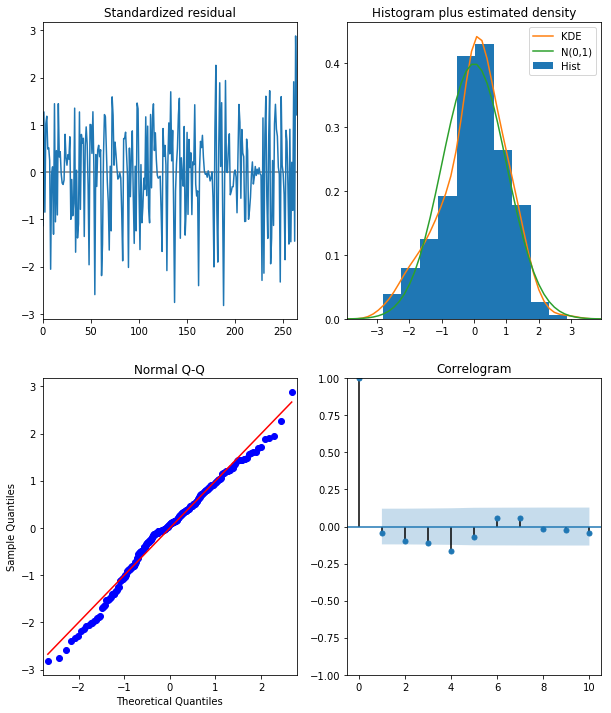

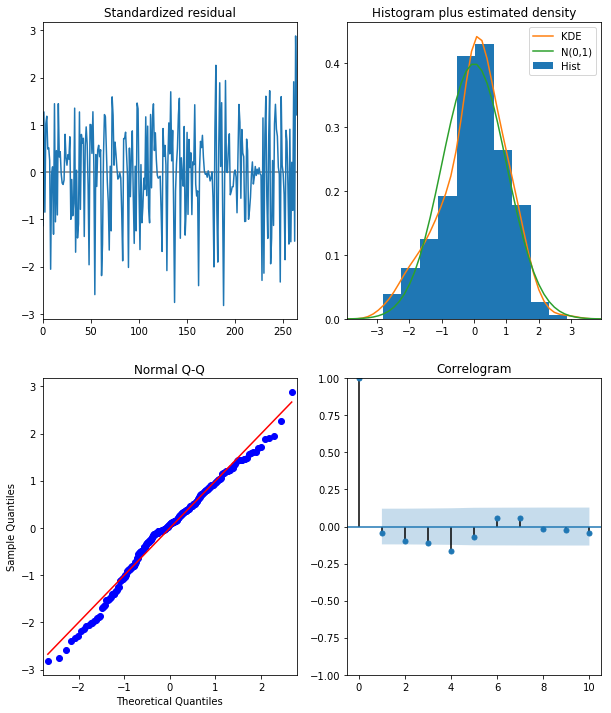

In [31]:
result1.plot_diagnostics(figsize=(10, 12))

In [32]:
plt.clf()
y_test1.shape

(66, 3)

<Figure size 432x288 with 0 Axes>

In [38]:
y_pred1 = result1.get_prediction(start=train1+1, end=prod1_transformed.shape[0], dynamic=False)
y_forecasted1 = y_pred1.predicted_mean
y_forecasted1.shape

(66, 3)

In [39]:
np.sqrt(mean_squared_error(y_pred=np.exp(y_forecasted1), y_true=np.exp(y_test1)))

0.6757741554451466

In [40]:
mean_absolute_error(y_pred=np.exp(y_forecasted1), y_true=np.exp(y_test1))

0.40893292317516733

## <font color=blue> 2. Mongodb ID: 5aa2ad7735d6d34b0032a795-imputed </font>

In [41]:
prod2 = genData('5aa2ad7735d6d34b0032a795', conn, c, impute=True, freq='daily', standardize=False)
prod2.head()

Sales    rating  ovsentiment
date                                    
2016-11-06     82  3.500000     0.500000
2016-11-07     88  5.000000     1.000000
2016-11-08     74  0.000000     0.000000
2016-11-09     72  0.000000     0.000000
2016-11-10     98  4.666667     0.333333

In [42]:
#prod2 = prod2[prod2['Sales'] != 0]
prod2.shape

(479, 3)

In [43]:
# Stationarity test (Augmented Dickey-Fuller test)
prod2Test = routines.tsTest(prod2['Sales'], '5aa2ad7735d6d34b0032a795')
prod2Test.adfuller()

5aa2ad7735d6d34b0032a795


Value                        Label
0 -1.500036e+01               Test Statistic
1  2.185321e-22                      p-value
2  1.000000e+00                   #Lags Used
3  4.770000e+02  Number of Observations Used
4 -3.977875e+00        Critical value for 1%
5 -3.419734e+00        Critical value for 5%
6 -3.132488e+00       Critical value for 10%

In [44]:
# Stationarity test (Augmented Dickey-Fuller test)
prod2Test = routines.tsTest(prod2['rating'], '5aa2ad7735d6d34b0032a795')
prod2Test.adfuller()

5aa2ad7735d6d34b0032a795


Value                        Label
0   -4.712726               Test Statistic
1    0.000664                      p-value
2    6.000000                   #Lags Used
3  472.000000  Number of Observations Used
4   -3.978079        Critical value for 1%
5   -3.419833        Critical value for 5%
6   -3.132546       Critical value for 10%

In [45]:
# Stationarity test (Augmented Dickey-Fuller test)
prod2Test = routines.tsTest(prod2['ovsentiment'], '5aa2ad7735d6d34b0032a795')
prod2Test.adfuller()

5aa2ad7735d6d34b0032a795


Value                        Label
0   -6.133400               Test Statistic
1    0.000001                      p-value
2    5.000000                   #Lags Used
3  473.000000  Number of Observations Used
4   -3.978038        Critical value for 1%
5   -3.419813        Critical value for 5%
6   -3.132534       Critical value for 10%

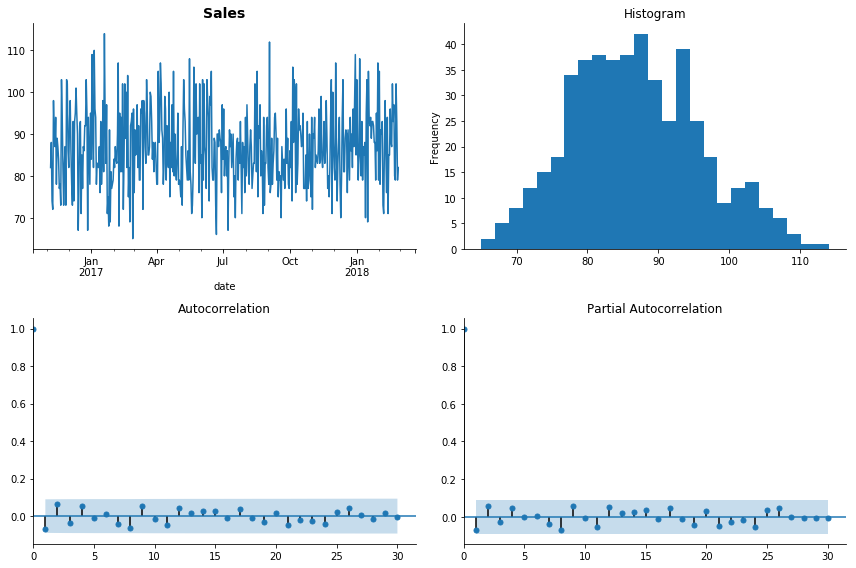

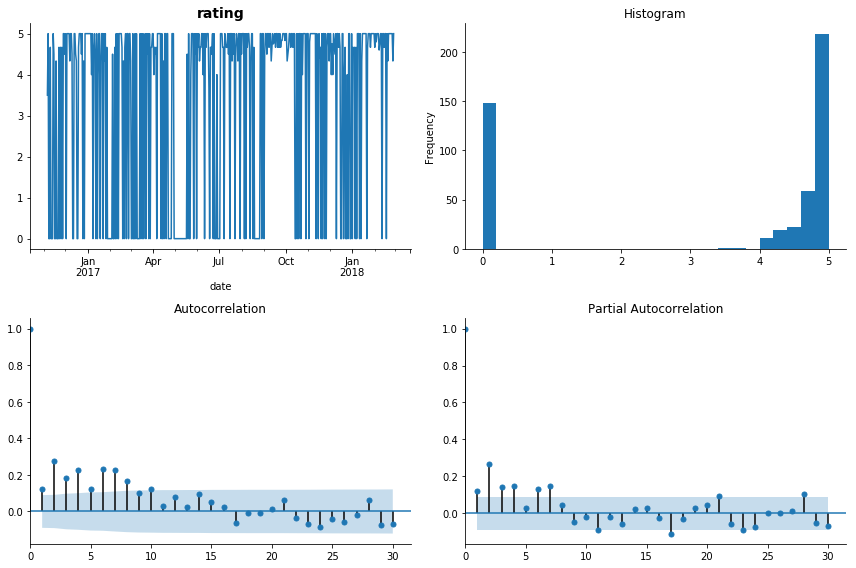

In [46]:
num_var2 = len(prod2.iloc[1, :])
for i in range(0, num_var2):
    tsplot(prod2.iloc[:, i].dropna(), title=prod2.columns[i], lags=30)
plt.show()

In [47]:
plt.clf()

<Figure size 432x288 with 0 Axes>

In [49]:
prod2_transformed = prod2.copy()
prod2_transformed['Sales'] = np.log(prod2_transformed['Sales'])
prod2_transformed['Sales'] = prod2_transformed['Sales'].diff(1)
prod2_transformed['rating'] = prod2_transformed['rating'].diff(1)
prod2_transformed['ovsentiment'] = prod2_transformed['ovsentiment'].diff(1)
prod2_transformed.dropna(inplace=True)

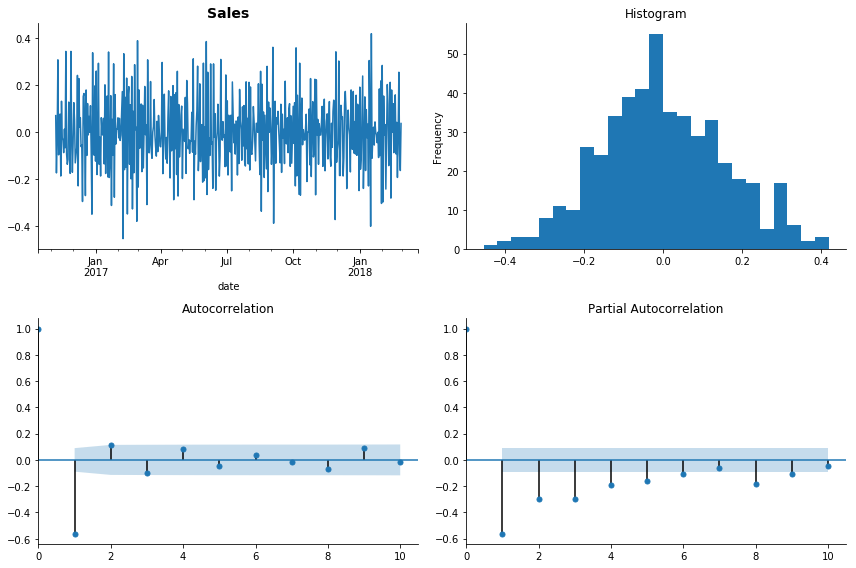

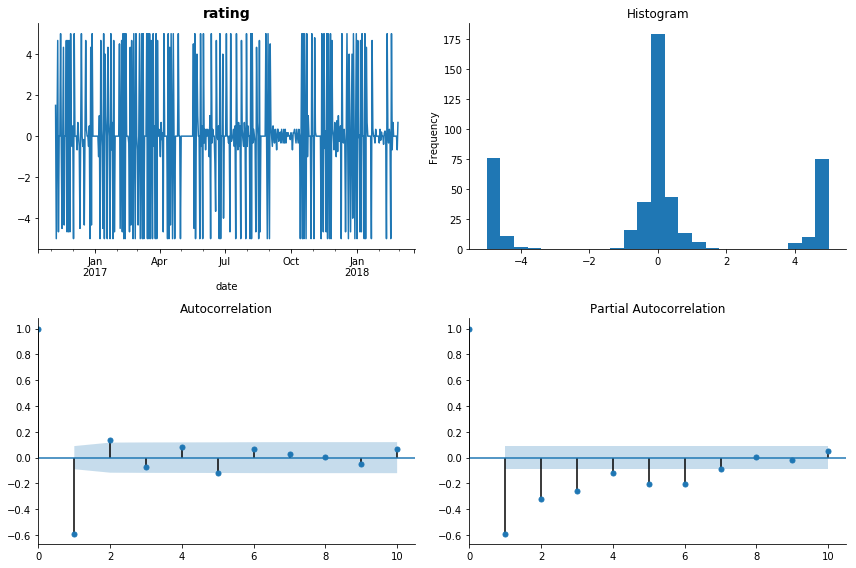

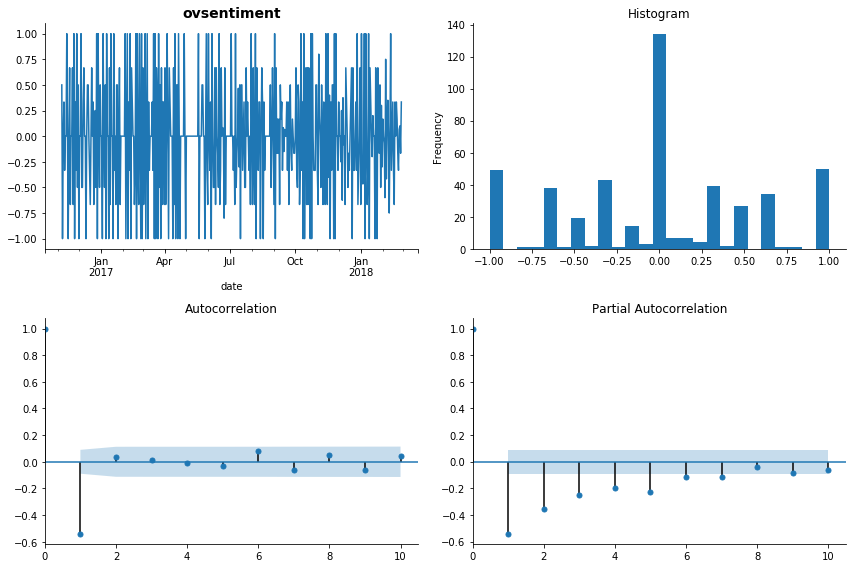

In [50]:
num_var2 = len(prod2_transformed.iloc[1, :])
for i in range(0, num_var2):
    tsplot(prod2_transformed.iloc[:, i].dropna(), title=prod2_transformed.columns[i], lags=10)
plt.show()

In [51]:
plt.clf()

<Figure size 432x288 with 0 Axes>

In [52]:
# Stationarity test (Augmented Dickey-Fuller test)
prod2_transformedTest = routines.tsTest(prod2_transformed['Sales'].dropna(), '5aa2ad7735d6d34b0032a795')
prod2_transformedTest.adfuller()

5aa2ad7735d6d34b0032a795


Value                        Label
0 -9.799114e+00               Test Statistic
1  6.199462e-15                      p-value
2  1.500000e+01                   #Lags Used
3  4.620000e+02  Number of Observations Used
4 -3.978500e+00        Critical value for 1%
5 -3.420036e+00        Critical value for 5%
6 -3.132665e+00       Critical value for 10%

In [53]:
# Stationarity test (Augmented Dickey-Fuller test)
prod2_transformedTest = routines.tsTest(prod2_transformed['rating'].dropna(), '5aa2ad7735d6d34b0032a795')
prod2_transformedTest.adfuller()

5aa2ad7735d6d34b0032a795


Value                        Label
0 -1.612384e+01               Test Statistic
1  1.112785e-22                      p-value
2  5.000000e+00                   #Lags Used
3  4.720000e+02  Number of Observations Used
4 -3.978079e+00        Critical value for 1%
5 -3.419833e+00        Critical value for 5%
6 -3.132546e+00       Critical value for 10%

In [54]:
# Stationarity test (Augmented Dickey-Fuller test)
prod2_transformedTest = routines.tsTest(prod2_transformed['ovsentiment'].dropna(), '5aa2ad7735d6d34b0032a795')
prod2_transformedTest.adfuller()

5aa2ad7735d6d34b0032a795


Value                        Label
0 -1.395354e+01               Test Statistic
1  1.209600e-21                      p-value
2  6.000000e+00                   #Lags Used
3  4.710000e+02  Number of Observations Used
4 -3.978120e+00        Critical value for 1%
5 -3.419853e+00        Critical value for 5%
6 -3.132558e+00       Critical value for 10%

In [55]:
# Train-Test Set Split
train2 = ceil(prod2_transformed.shape[0] * 0.8)
y_train2 = prod2_transformed[0:train2]
y_test2 = prod2_transformed[train2:]
y_train2.shape, y_test2.shape

((383, 3), (95, 3))

In [56]:
y_train2.dropna().shape

(383, 3)

In [57]:
BIC2 = detpq(y_train2, par=range(0,6))

In [58]:
BIC2

index   param          BIC
0       0  (0, 1)  1286.503308
1       6  (1, 1)  1309.927521
2       7  (1, 2)  1346.530560
3      12  (2, 1)  1364.953462
4       1  (0, 2)  1407.756473
5      13  (2, 2)  1408.791516
6      18  (3, 1)  1414.192096
7       8  (1, 3)  1421.613356
8      14  (2, 3)  1430.713830
9      19  (3, 2)  1455.687950
10     17  (3, 0)  1472.776424
11     23  (4, 0)  1476.272604
12     20  (3, 3)  1482.483570
13     15  (2, 4)  1493.350704
14     29  (5, 0)  1495.754902
15     24  (4, 1)  1497.107013
16     21  (3, 4)  1518.866215
17     25  (4, 2)  1518.942778
18     11  (2, 0)  1521.871665
19     30  (5, 1)  1529.673509
20     26  (4, 3)  1530.179936
21      9  (1, 4)  1530.868658
22     31  (5, 2)  1538.471959
23     16  (2, 5)  1553.122542
24     22  (3, 5)  1563.379130
25     27  (4, 4)  1568.056489
26     10  (1, 5)  1576.927663
27     32  (5, 3)  1583.687299
28      5  (1, 0)  1593.557392
29     28  (4, 5)  1611.268985
30     33  (5, 4)  1618.540926
31     34  (5, 5)  1662.369713
32      2  (0, 3)  1713.765783
33      3  (0, 4)  1724.988868
34      4  (0, 5)  1813.723922

In [59]:
model2 = sm.tsa.VARMAX(y_train2, order=(3, 0))
result2 = model2.fit(maxiter=1000, disp=False)

In [60]:
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   Statespace Model Results                                   
==============================================================================================
Dep. Variable:     ['Sales', 'rating', 'ovsentiment']   No. Observations:                  383
Model:                                         VAR(3)   Log Likelihood                -629.324
                                          + intercept   AIC                           1330.647
Date:                                Sat, 15 Sep 2018   BIC                           1472.776
Time:                                        06:34:49   HQIC                          1387.028
Sample:                                    11-07-2016                                         
                                         - 11-24-2017                                         
Covariance Type:                                  opg                                         
=====================================================================================
Ljung-Box (Q):          56.72, 80.17, 73.70   Jarque-Bera (JB):    0.39, 14.29, 45.42
Prob(Q):                   0.04, 0.00, 0.00   Prob(JB):              0.82, 0.00, 0.00
Heteroskedasticity (H):    0.59, 0.70, 0.91   Skew:               -0.06, -0.46, -0.68
Prob(H) (two-sided):       0.00, 0.05, 0.62   Kurtosis:              2.89, 2.75, 4.01
                            Results for equation Sales                            
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0002      0.006     -0.024      0.981      -0.013       0.012
L1.Sales          -0.7963      0.055    -14.441      0.000      -0.904      -0.688
L1.rating         -0.0045      0.004     -1.153      0.249      -0.012       0.003
L1.ovsentiment -1.079e-05      0.019     -0.001      1.000      -0.038       0.038
L2.Sales          -0.4587      0.066     -6.991      0.000      -0.587      -0.330
L2.rating         -0.0078      0.005     -1.661      0.097      -0.017       0.001
L2.ovsentiment     0.0157      0.021      0.757      0.449      -0.025       0.056
L3.Sales          -0.2731      0.051     -5.350      0.000      -0.373      -0.173
L3.rating          0.0018      0.004      0.438      0.662      -0.006       0.010
L3.ovsentiment    -0.0062      0.021     -0.300      0.764      -0.047       0.034
                           Results for equation rating                            
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0027      0.131     -0.020      0.984      -0.259       0.254
L1.Sales          -1.7952      0.982     -1.828      0.067      -3.719       0.129
L1.rating         -0.8284      0.083     -9.995      0.000      -0.991      -0.666
L1.ovsentiment    -0.1485      0.403     -0.368      0.713      -0.939       0.642
L2.Sales          -1.8384      1.102     -1.668      0.095      -3.999       0.322
L2.rating         -0.4759      0.096     -4.974      0.000      -0.663      -0.288
L2.ovsentiment    -0.2376      0.466     -0.510      0.610      -1.151       0.676
L3.Sales          -0.5871      0.956     -0.614      0.539      -2.462       1.288
L3.rating         -0.3346      0.079     -4.237      0.000      -0.489      -0.180
L3.ovsentiment     0.4292      0.398      1.079      0.281      -0.351       1.209
                         Results for equation ovsentiment                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]

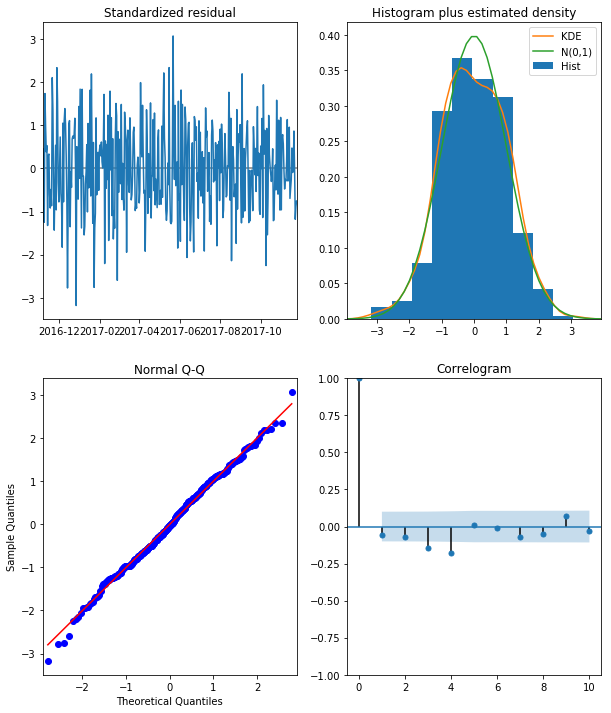

In [61]:
result2.plot_diagnostics(figsize=(10, 12))

In [62]:
plt.clf()
y_test2.shape

(95, 3)

<Figure size 432x288 with 0 Axes>

In [63]:
y_pred2 = result2.get_prediction(start=train2+1, end=prod2_transformed.shape[0])
y_forecasted2 = y_pred2.predicted_mean
y_forecasted2.shape

(95, 3)

In [65]:
np.sqrt(mean_squared_error(y_pred=np.exp(y_forecasted2), y_true=np.exp(y_test2)))

29.70056052572865

In [67]:
mean_absolute_error(y_pred=np.exp(y_forecasted2), y_true=np.exp(y_test2))

7.07637505940652

## <font color=blue> 3. Mongodb ID: 5aa39533ae1f941be7165ecd </font>

In [105]:
prod3 = genData('5aa39533ae1f941be7165ecd', conn, c, impute=False, freq='daily', standardize=False)

In [106]:
prod3 = prod3[prod3['Sales'] != 0]

In [107]:
# Stationarity test (Augmented Dickey-Fuller test)
prod3Test = routines.tsTest(prod3['Sales'], '5aa39533ae1f941be7165ecd')
prod3Test.adfuller()

5aa39533ae1f941be7165ecd


Value                        Label
0   -5.939505               Test Statistic
1    0.000003                      p-value
2    3.000000                   #Lags Used
3  356.000000  Number of Observations Used
4   -3.984427        Critical value for 1%
5   -3.422895        Critical value for 5%
6   -3.134344       Critical value for 10%

In [108]:
# Stationarity test (Augmented Dickey-Fuller test)
prod3Test = routines.tsTest(prod3['rating'], '5aa39533ae1f941be7165ecd')
prod3Test.adfuller()

5aa39533ae1f941be7165ecd


Value                        Label
0 -8.956953e+00               Test Statistic
1  4.541724e-13                      p-value
2  2.000000e+00                   #Lags Used
3  3.570000e+02  Number of Observations Used
4 -3.984355e+00        Critical value for 1%
5 -3.422860e+00        Critical value for 5%
6 -3.134324e+00       Critical value for 10%

In [109]:
# Stationarity test (Augmented Dickey-Fuller test)
prod3Test = routines.tsTest(prod3['ovsentiment'], '5aa39533ae1f941be7165ecd')
prod3Test.adfuller()

5aa39533ae1f941be7165ecd


Value                        Label
0  -18.675693               Test Statistic
1    0.000000                      p-value
2    0.000000                   #Lags Used
3  359.000000  Number of Observations Used
4   -3.984211        Critical value for 1%
5   -3.422791        Critical value for 5%
6   -3.134283       Critical value for 10%

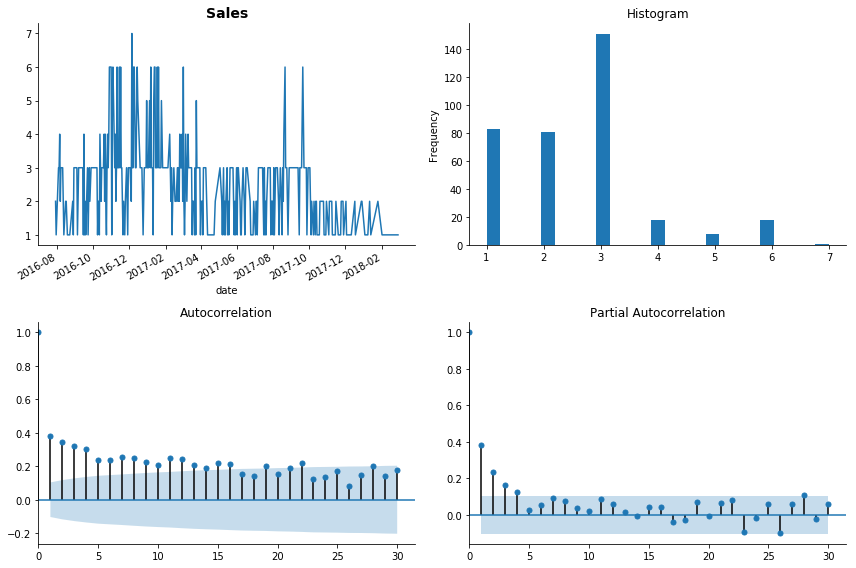

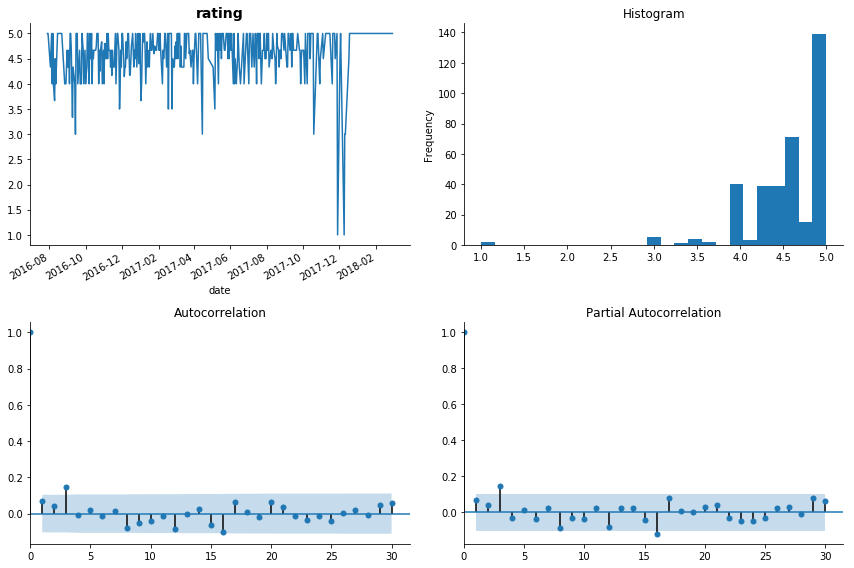

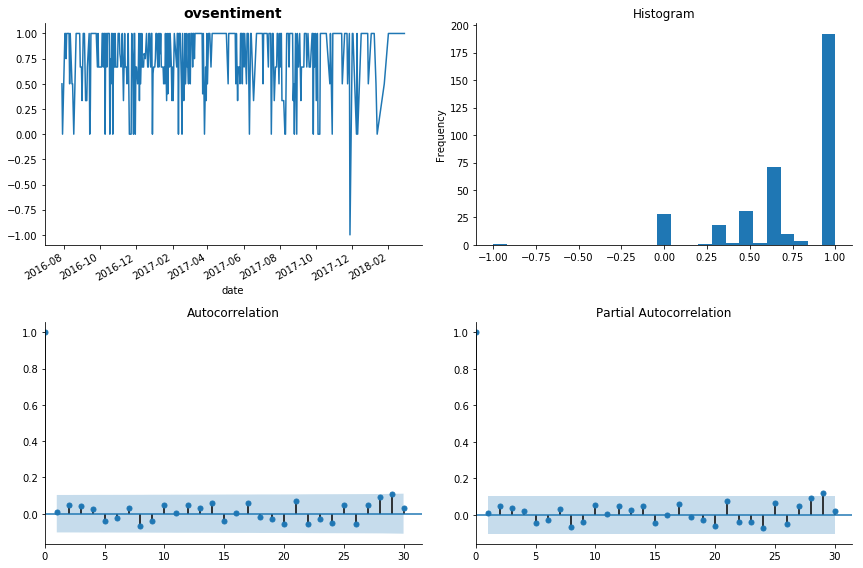

In [110]:
num_var3 = len(prod3.iloc[1, :])
for i in range(0, num_var3):
    tsplot(prod3.iloc[:, i].dropna(), title=prod3.columns[i], lags=30)
plt.show()

In [111]:
plt.clf()

<Figure size 432x288 with 0 Axes>

In [112]:
prod3_transformed = prod3.copy()
prod3_transformed['Sales'] = np.log(prod3_transformed['Sales'])
prod3_transformed['Sales'] = prod3_transformed['Sales'].diff(5)

In [113]:
prod3_transformed['rating'] = prod3_transformed['rating'].diff(1)
prod3_transformed['ovsentiment'] = prod3_transformed['ovsentiment'].diff(1)

In [114]:
prod3_transformed.dropna(inplace=True)

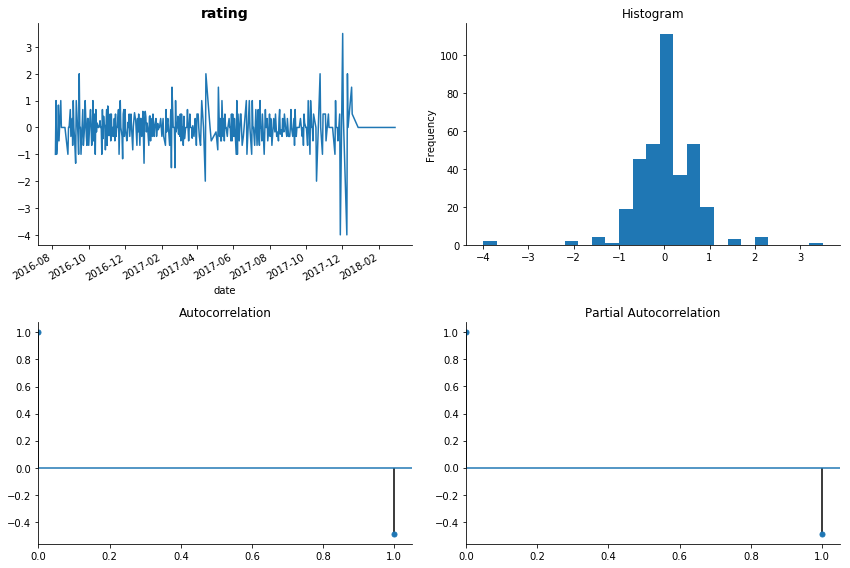

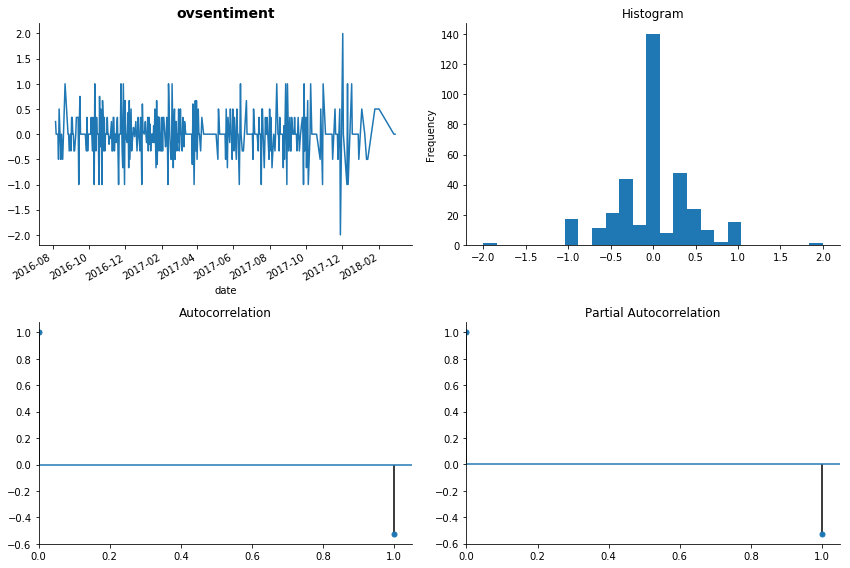

In [115]:
num_var3 = len(prod3_transformed.iloc[1, :])
for i in range(0, num_var3):
    tsplot(prod3_transformed.iloc[:, i].dropna(), title=prod3_transformed.columns[i], lags=1)
plt.show()

In [116]:
plt.clf()

<Figure size 432x288 with 0 Axes>

In [117]:
# Stationarity test (Augmented Dickey-Fuller test)
prod3_transformedTest = routines.tsTest(prod3_transformed['Sales'].dropna(), '5aa39533ae1f941be7165ecd')
prod3_transformedTest.adfuller()

5aa39533ae1f941be7165ecd


Value                        Label
0 -7.398839e+00               Test Statistic
1  1.740593e-09                      p-value
2  1.400000e+01                   #Lags Used
3  3.400000e+02  Number of Observations Used
4 -3.985646e+00        Critical value for 1%
5 -3.423482e+00        Critical value for 5%
6 -3.134689e+00       Critical value for 10%

In [118]:
# Stationarity test (Augmented Dickey-Fuller test)
prod3_transformedTest = routines.tsTest(prod3_transformed['rating'].dropna(), '5aa39533ae1f941be7165ecd')
prod3_transformedTest.adfuller()

5aa39533ae1f941be7165ecd


Value                        Label
0 -6.982912e+00               Test Statistic
1  1.544504e-08                      p-value
2  1.600000e+01                   #Lags Used
3  3.380000e+02  Number of Observations Used
4 -3.985807e+00        Critical value for 1%
5 -3.423560e+00        Critical value for 5%
6 -3.134735e+00       Critical value for 10%

In [119]:
# Stationarity test (Augmented Dickey-Fuller test)
prod3_transformedTest = routines.tsTest(prod3_transformed['ovsentiment'].dropna(), '5aa39533ae1f941be7165ecd')
prod3_transformedTest.adfuller()

5aa39533ae1f941be7165ecd


Value                        Label
0 -9.373808e+00               Test Statistic
1  5.278567e-14                      p-value
2  1.200000e+01                   #Lags Used
3  3.420000e+02  Number of Observations Used
4 -3.985487e+00        Critical value for 1%
5 -3.423406e+00        Critical value for 5%
6 -3.134644e+00       Critical value for 10%

In [120]:
# Train-Test Set Split
train3 = ceil(prod3_transformed.shape[0] * 0.8)
y_train3 = prod3_transformed[0:train3]
y_test3 = prod3_transformed[train3:]
y_train3.shape, y_test3.shape

((284, 3), (71, 3))

In [121]:
y_train3.dropna().shape

(284, 3)

In [122]:
BIC3 = detpq(y_train3, par=range(0,6))

In [123]:
BIC3

index   param          BIC
0       0  (0, 1)  1066.361773
1       6  (1, 1)  1114.893696
2       1  (0, 2)  1117.856682
3       7  (1, 2)  1153.884832
4      12  (2, 1)  1154.273814
5       4  (0, 5)  1176.992366
6      10  (1, 5)  1183.491406
7       2  (0, 3)  1184.361554
8      13  (2, 2)  1193.347320
9      18  (3, 1)  1194.736205
10      8  (1, 3)  1206.319062
11     30  (5, 1)  1210.258079
12     16  (2, 5)  1212.640408
13     29  (5, 0)  1216.551097
14     24  (4, 1)  1222.430101
15     22  (3, 5)  1238.913298
16     14  (2, 3)  1244.895675
17     11  (2, 0)  1246.594919
18     31  (5, 2)  1250.909945
19     17  (3, 0)  1253.839854
20      3  (0, 4)  1254.669311
21     19  (3, 2)  1257.197779
22      9  (1, 4)  1264.269664
23     23  (4, 0)  1270.283791
24      5  (1, 0)  1274.229390
25     28  (4, 5)  1276.290399
26     25  (4, 2)  1278.287862
27     20  (3, 3)  1281.347160
28     32  (5, 3)  1284.610795
29     15  (2, 4)  1292.758876
30     26  (4, 3)  1323.668068
31     21  (3, 4)  1327.696434
32     33  (5, 4)  1328.338370
33     34  (5, 5)  1336.384992
34     27  (4, 4)  1362.362016

In [124]:
model3 = sm.tsa.VARMAX(y_train3, order=(5, 0))
result3 = model3.fit(maxiter=1000, disp=False)

In [125]:
result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   Statespace Model Results                                   
==============================================================================================
Dep. Variable:     ['Sales', 'rating', 'ovsentiment']   No. Observations:                  284
Model:                                         VAR(5)   Log Likelihood                -455.753
                                          + intercept   AIC                           1019.506
Date:                                Sat, 15 Sep 2018   BIC                           1216.551
Time:                                        07:02:10   HQIC                          1098.506
Sample:                                             0                                         
                                                - 284                                         
Covariance Type:                                  opg                                         
=====================================================================================
Ljung-Box (Q):          66.98, 51.80, 51.56   Jarque-Bera (JB):    7.28, 26.90, 41.67
Prob(Q):                   0.00, 0.10, 0.10   Prob(JB):              0.03, 0.00, 0.00
Heteroskedasticity (H):    0.88, 0.77, 0.83   Skew:               -0.37, -0.68, -0.84
Prob(H) (two-sided):       0.54, 0.20, 0.37   Kurtosis:              2.75, 3.66, 3.85
                            Results for equation Sales                            
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0029      0.042      0.070      0.944      -0.079       0.085
L1.Sales           0.1065      0.068      1.560      0.119      -0.027       0.240
L1.rating         -0.0686      0.078     -0.879      0.379      -0.221       0.084
L1.ovsentiment     0.1361      0.123      1.110      0.267      -0.104       0.376
L2.Sales           0.0942      0.059      1.608      0.108      -0.021       0.209
L2.rating         -0.0589      0.121     -0.486      0.627      -0.296       0.179
L2.ovsentiment    -0.0048      0.149     -0.032      0.974      -0.297       0.288
L3.Sales           0.0184      0.064      0.287      0.774      -0.107       0.144
L3.rating         -0.0427      0.129     -0.332      0.740      -0.295       0.210
L3.ovsentiment     0.0846      0.178      0.475      0.635      -0.265       0.434
L4.Sales          -0.0055      0.058     -0.096      0.923      -0.118       0.107
L4.rating         -0.1875      0.111     -1.685      0.092      -0.405       0.031
L4.ovsentiment     0.0571      0.168      0.339      0.735      -0.273       0.387
L5.Sales          -0.4791      0.057     -8.343      0.000      -0.592      -0.367
L5.rating         -0.1307      0.082     -1.600      0.110      -0.291       0.029
L5.ovsentiment     0.0805      0.135      0.594      0.552      -0.185       0.346
                           Results for equation rating                            
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0015      0.031      0.047      0.963      -0.059       0.062
L1.Sales          -0.0574      0.042     -1.377      0.169      -0.139       0.024
L1.rating         -0.8559      0.066    -12.900      0.000      -0.986      -0.726
L1.ovsentiment    -0.2296      0.091     -2.527      0.011      -0.408      -0.052
L2.Sales          -0.0288      0.046     -0.626      0.531      -0.119       0.061
L2.rating         -0.6690      0.081     -8.260      0.000      -0.828      -0.510
L2.ovsentiment    -0.3234      0.124     -2.607      0.009      -0.566      -0.080

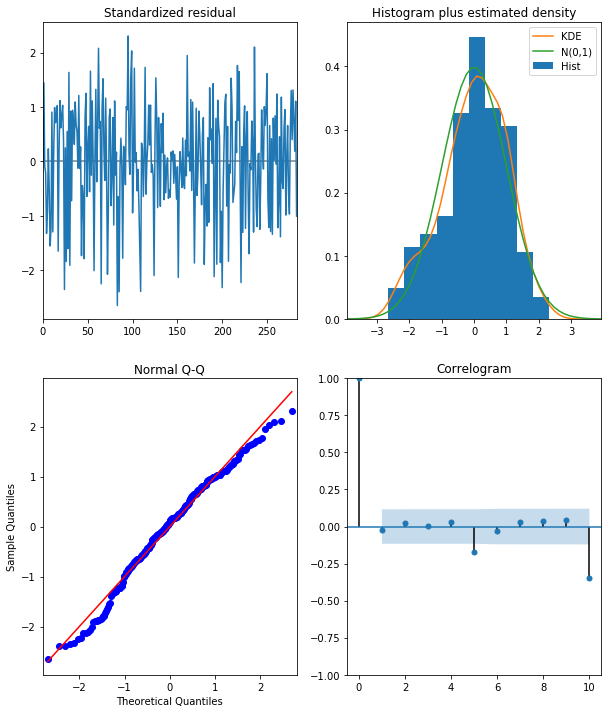

In [126]:
result3.plot_diagnostics(figsize=(10, 12))

In [127]:
plt.clf()
y_test3.shape

(71, 3)

<Figure size 432x288 with 0 Axes>

In [128]:
y_pred3 = result3.get_prediction(start=train3+1, end=prod3_transformed.shape[0])
y_forecasted3 = y_pred3.predicted_mean
y_forecasted3.shape

(71, 3)

In [129]:
np.sqrt(mean_squared_error(y_pred=np.exp(y_forecasted3), y_true=np.exp(y_test3)))

2.4153002258518756

In [130]:
mean_absolute_error(y_pred=np.exp(y_forecasted3), y_true=np.exp(y_test3))

0.6334035533918314

## <font color=blue> 4. Mongodb ID: 5aa39533ae1f941be7165ecd-imputed </font>

In [131]:
prod4 = genData('5aa39533ae1f941be7165ecd', conn, c, impute=True, freq='daily', standardize=False)
prod4 = prod4[prod4['Sales'] != 0]

In [132]:
# Stationarity test (Augmented Dickey-Fuller test)
prod4Test = routines.tsTest(prod4['Sales'], '5aa39533ae1f941be7165ecd')
prod4Test.adfuller()

5aa39533ae1f941be7165ecd


Value                        Label
0  -22.354811               Test Statistic
1    0.000000                      p-value
2    0.000000                   #Lags Used
3  578.000000  Number of Observations Used
4   -3.974519        Critical value for 1%
5   -3.418113        Critical value for 5%
6   -3.131535       Critical value for 10%

In [133]:
# Stationarity test (Augmented Dickey-Fuller test)
prod4Test = routines.tsTest(prod4['rating'], '5aa39533ae1f941be7165ecd')
prod4Test.adfuller()

5aa39533ae1f941be7165ecd


Value                        Label
0   -5.489097               Test Statistic
1    0.000024                      p-value
2    6.000000                   #Lags Used
3  572.000000  Number of Observations Used
4   -3.974685        Critical value for 1%
5   -3.418193        Critical value for 5%
6   -3.131582       Critical value for 10%

In [134]:
# Stationarity test (Augmented Dickey-Fuller test)
prod4Test = routines.tsTest(prod4['ovsentiment'], '5aa39533ae1f941be7165ecd')
prod4Test.adfuller()

5aa39533ae1f941be7165ecd


Value                        Label
0 -7.626013e+00               Test Statistic
1  5.223725e-10                      p-value
2  5.000000e+00                   #Lags Used
3  5.730000e+02  Number of Observations Used
4 -3.974657e+00        Critical value for 1%
5 -3.418180e+00        Critical value for 5%
6 -3.131574e+00       Critical value for 10%

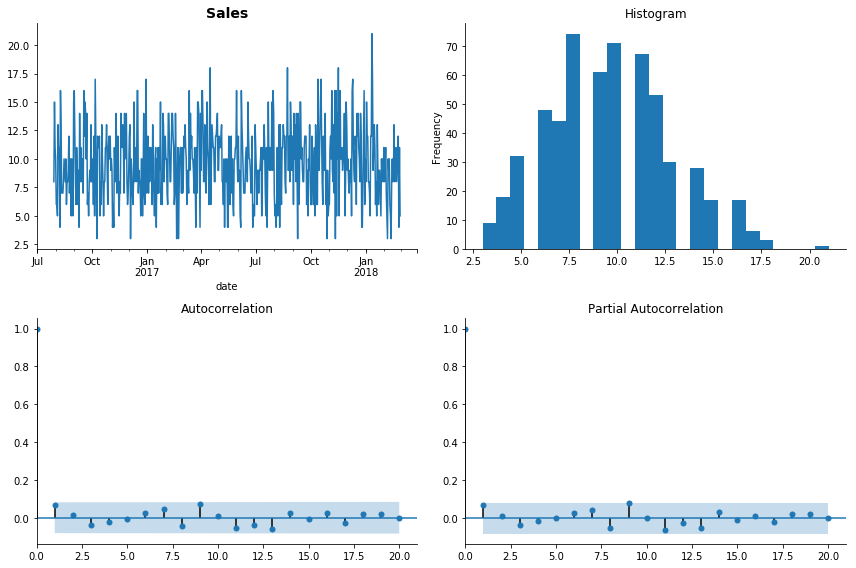

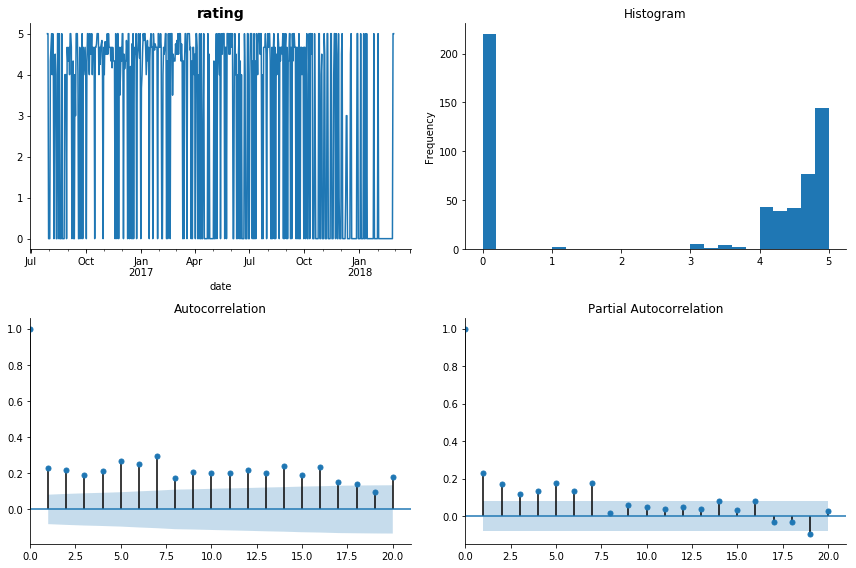

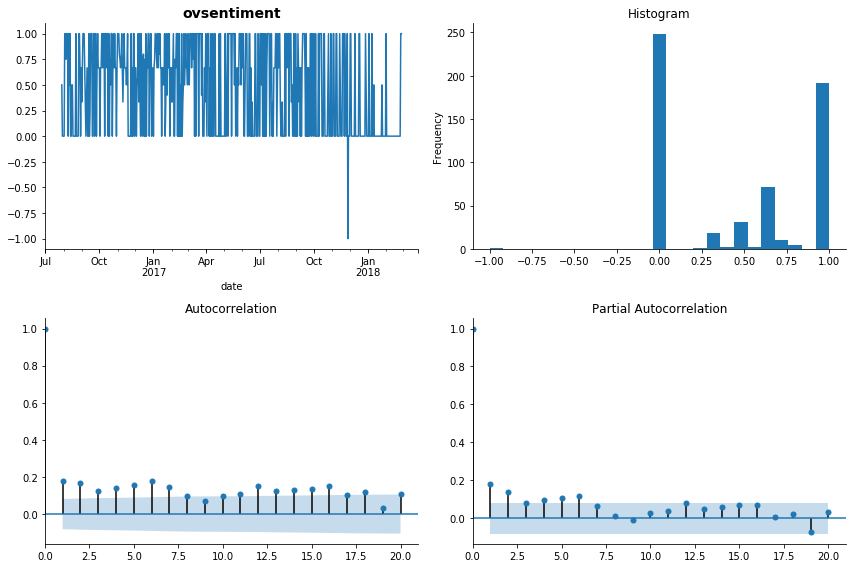

In [135]:
num_var4 = len(prod4.iloc[1, :])
for i in range(0, num_var4):
    tsplot(prod4.iloc[:, i].dropna(), title=prod4.columns[i], lags=20)
plt.show()

In [136]:
plt.clf()

<Figure size 432x288 with 0 Axes>

In [137]:
prod4_transformed = prod4.copy()
prod4_transformed['Sales'] = np.log(prod4_transformed['Sales'])
prod4_transformed['Sales'] = prod4_transformed['Sales'].diff(11)

prod4_transformed['rating'] = prod4_transformed['rating'].diff(1)
prod4_transformed['ovsentiment'] = prod4_transformed['ovsentiment'].diff(1)

prod4_transformed.dropna(inplace=True)

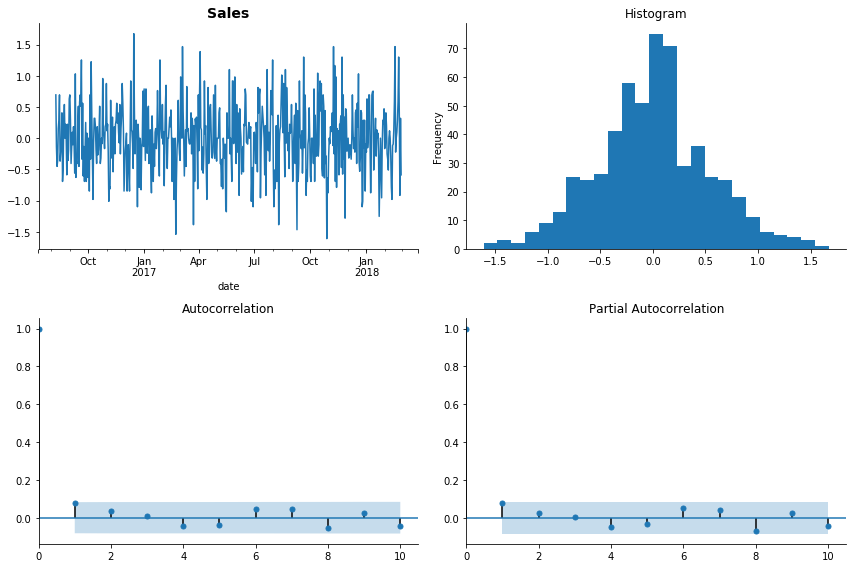

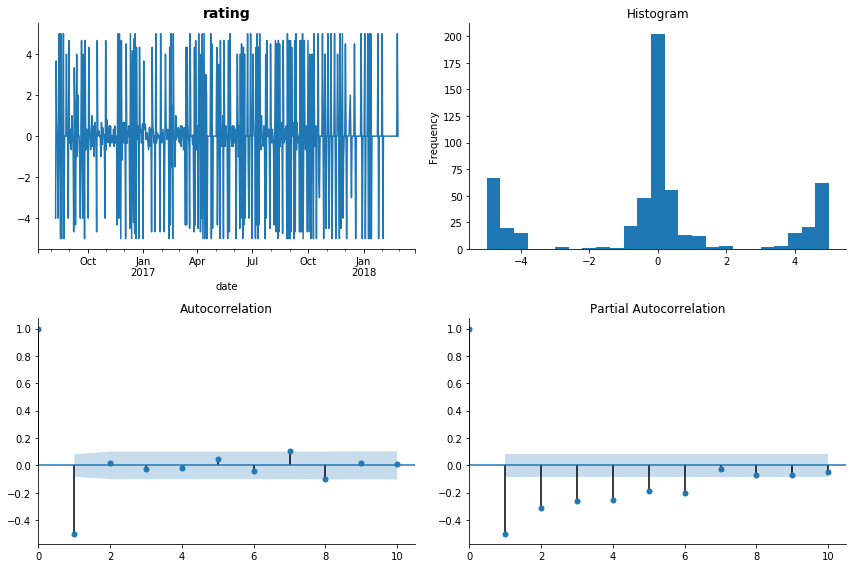

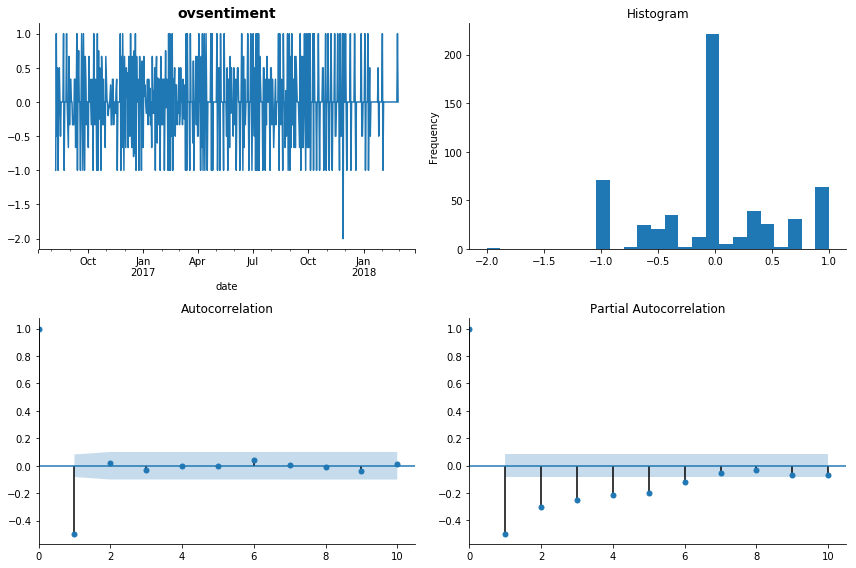

In [138]:
num_var4 = len(prod4_transformed.iloc[1, :])
for i in range(0, num_var4):
    tsplot(prod4_transformed.iloc[:, i].dropna(), title=prod4_transformed.columns[i], lags=10)
plt.show()

In [139]:
plt.clf()

<Figure size 432x288 with 0 Axes>

In [140]:
# Stationarity test (Augmented Dickey-Fuller test)
prod4_transformedTest = routines.tsTest(prod4_transformed['Sales'].dropna(), '5aa39533ae1f941be7165ecd')
prod4_transformedTest.adfuller()

5aa39533ae1f941be7165ecd


Value                        Label
0 -1.307537e+01               Test Statistic
1  1.091196e-20                      p-value
2  1.000000e+01                   #Lags Used
3  5.570000e+02  Number of Observations Used
4 -3.975116e+00        Critical value for 1%
5 -3.418402e+00        Critical value for 5%
6 -3.131705e+00       Critical value for 10%

In [141]:
# Stationarity test (Augmented Dickey-Fuller test)
prod4_transformedTest = routines.tsTest(prod4_transformed['rating'].dropna(), '5aa39533ae1f941be7165ecd')
prod4_transformedTest.adfuller()

5aa39533ae1f941be7165ecd


Value                        Label
0 -7.625430e+00               Test Statistic
1  5.239939e-10                      p-value
2  1.900000e+01                   #Lags Used
3  5.480000e+02  Number of Observations Used
4 -3.975386e+00        Critical value for 1%
5 -3.418532e+00        Critical value for 5%
6 -3.131781e+00       Critical value for 10%

In [142]:
# Stationarity test (Augmented Dickey-Fuller test)
prod4_transformedTest = routines.tsTest(prod4_transformed['ovsentiment'].dropna(), '5aa39533ae1f941be7165ecd')
prod4_transformedTest.adfuller()

5aa39533ae1f941be7165ecd


Value                        Label
0 -8.780066e+00               Test Statistic
1  1.146008e-12                      p-value
2  1.900000e+01                   #Lags Used
3  5.480000e+02  Number of Observations Used
4 -3.975386e+00        Critical value for 1%
5 -3.418532e+00        Critical value for 5%
6 -3.131781e+00       Critical value for 10%

In [143]:
# Train-Test Set Split
train4 = ceil(prod4_transformed.shape[0] * 0.8)
y_train4 = prod4_transformed[0:train4]
y_test4 = prod4_transformed[train4:]
y_train4.shape, y_test4.shape

((455, 3), (113, 3))

In [144]:
BIC4 = detpq(y_train4, par=range(0,6))

In [145]:
BIC4

index   param          BIC
0       0  (0, 1)  2810.530566
1       6  (1, 1)  2856.607180
2      12  (2, 1)  2899.874231
3       1  (0, 2)  2908.358915
4       7  (1, 2)  2910.928431
5      13  (2, 2)  2944.702281
6      18  (3, 1)  2949.020239
7       8  (1, 3)  2957.345361
8      19  (3, 2)  2993.662995
9      24  (4, 1)  2993.667602
10      2  (0, 3)  2995.946039
11     14  (2, 3)  2999.627646
12     23  (4, 0)  3035.065781
13     25  (4, 2)  3036.406733
14     17  (3, 0)  3047.195181
15     30  (5, 1)  3047.688310
16     20  (3, 3)  3049.441701
17     11  (2, 0)  3051.196029
18      9  (1, 4)  3056.424909
19     15  (2, 4)  3060.806325
20      3  (0, 4)  3061.151773
21     29  (5, 0)  3064.233715
22     10  (1, 5)  3087.553893
23     26  (4, 3)  3087.583617
24     31  (5, 2)  3090.013415
25     21  (3, 4)  3096.845286
26     16  (2, 5)  3127.253206
27      4  (0, 5)  3130.548058
28      5  (1, 0)  3134.214336
29     32  (5, 3)  3140.581737
30     27  (4, 4)  3140.842849
31     22  (3, 5)  3144.432073
32     33  (5, 4)  3193.384632
33     28  (4, 5)  3195.497547
34     34  (5, 5)  3247.747466

In [146]:
model4 = sm.tsa.VARMAX(y_train4, order=(4, 0))
result4 = model4.fit(maxiter=1000, disp=False)

result4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   Statespace Model Results                                   
==============================================================================================
Dep. Variable:     ['Sales', 'rating', 'ovsentiment']   No. Observations:                  455
Model:                                         VAR(4)   Log Likelihood               -1379.826
                                          + intercept   AIC                           2849.652
Date:                                Sat, 15 Sep 2018   BIC                           3035.066
Time:                                        07:28:18   HQIC                          2922.697
Sample:                                    08-09-2016                                         
                                         - 11-06-2017                                         
Covariance Type:                                  opg                                         
======================================================================================
Ljung-Box (Q):          155.06, 109.15, 38.18   Jarque-Bera (JB):   2.02, 30.40, 79.08
Prob(Q):                     0.00, 0.00, 0.55   Prob(JB):             0.36, 0.00, 0.00
Heteroskedasticity (H):      1.13, 1.44, 0.95   Skew:               0.13, -0.60, -0.81
Prob(H) (two-sided):         0.46, 0.02, 0.73   Kurtosis:             3.19, 2.58, 4.25
                            Results for equation Sales                            
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0006      0.027     -0.024      0.981      -0.053       0.051
L1.Sales           0.1136      0.057      1.981      0.048       0.001       0.226
L1.rating         -0.0026      0.021     -0.120      0.904      -0.044       0.039
L1.ovsentiment     0.0602      0.108      0.556      0.579      -0.152       0.273
L2.Sales          -0.0133      0.051     -0.263      0.793      -0.112       0.086
L2.rating         -0.0450      0.026     -1.757      0.079      -0.095       0.005
L2.ovsentiment     0.2042      0.122      1.673      0.094      -0.035       0.443
L3.Sales           0.0767      0.047      1.627      0.104      -0.016       0.169
L3.rating         -0.0532      0.025     -2.115      0.034      -0.102      -0.004
L3.ovsentiment     0.2156      0.122      1.769      0.077      -0.023       0.454
L4.Sales          -0.1307      0.053     -2.452      0.014      -0.235      -0.026
L4.rating         -0.0268      0.019     -1.431      0.153      -0.064       0.010
L4.ovsentiment     0.1156      0.088      1.308      0.191      -0.058       0.289
                           Results for equation rating                            
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0093      0.127     -0.073      0.942      -0.258       0.239
L1.Sales          -0.3079      0.221     -1.390      0.165      -0.742       0.126
L1.rating         -0.8113      0.079    -10.293      0.000      -0.966      -0.657
L1.ovsentiment    -0.2455      0.363     -0.676      0.499      -0.958       0.467
L2.Sales           0.0901      0.201      0.447      0.655      -0.305       0.485
L2.rating         -0.6919      0.096     -7.193      0.000      -0.880      -0.503
L2.ovsentiment     0.4260      0.444      0.960      0.337      -0.444       1.296
L3.Sales          -0.0958      0.206     -0.464      0.642      -0.500       0.308
L3.rating         -0.4930      0.096     -5.127      0.000      -0.682      -0.305
L3.ovsentiment     0.2794      0.441      0.634      0.526      -0.585       

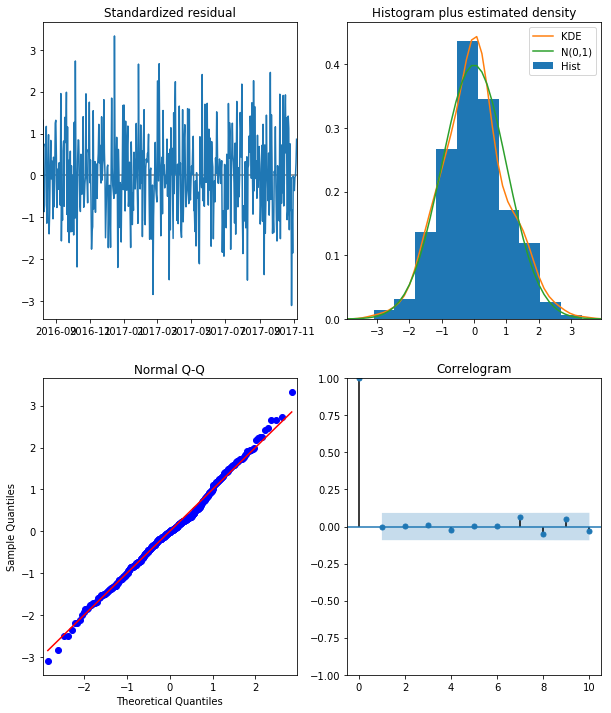

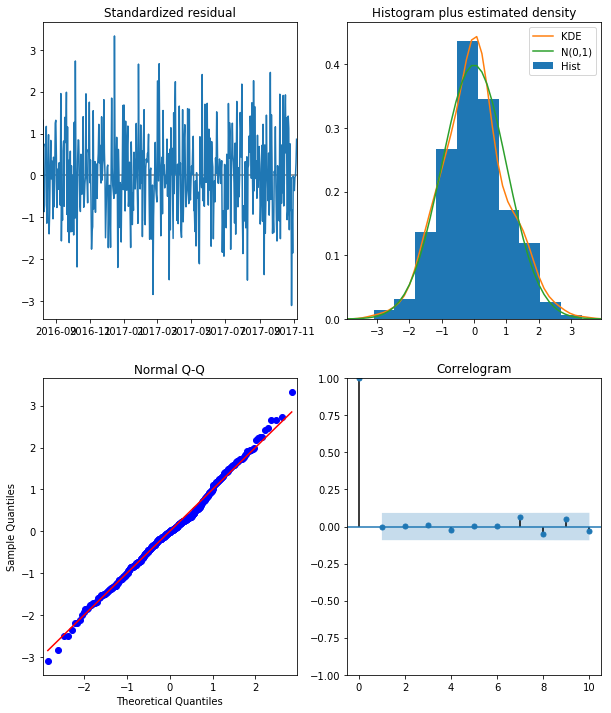

In [147]:
result4.plot_diagnostics(figsize=(10, 12))

In [148]:
plt.clf()
y_test4.shape

(113, 3)

<Figure size 432x288 with 0 Axes>

In [149]:
y_pred4 = result4.get_prediction(start=train4+1, end=prod4_transformed.shape[0])
y_forecasted4 = y_pred4.predicted_mean
y_forecasted4.shape

(113, 3)

In [150]:
np.sqrt(mean_squared_error(y_pred=np.exp(y_forecasted4), y_true=np.exp(y_test4)))

28.73068655354208

In [151]:
mean_absolute_error(y_pred=np.exp(y_forecasted4), y_true=np.exp(y_test4))

6.256226654709898

## <font color=blue> 5. Mongodb ID: 5aa2c35e35d6d34b0032a796 </font>

In [152]:
prod5 = genData('5aa2c35e35d6d34b0032a796', conn, c, impute=False, freq='daily', standardize=False)
prod5 = prod5[prod5['Sales'] != 0]

In [153]:
# Stationarity test (Augmented Dickey-Fuller test)
prod5Test = routines.tsTest(prod5['Sales'], '5aa2c35e35d6d34b0032a796')
prod5Test.adfuller()

5aa2c35e35d6d34b0032a796


Value                        Label
0   -4.541208               Test Statistic
1    0.001292                      p-value
2    6.000000                   #Lags Used
3  223.000000  Number of Observations Used
4   -3.999951        Critical value for 1%
5   -3.430364        Critical value for 5%
6   -3.138726       Critical value for 10%

In [154]:
# Stationarity test (Augmented Dickey-Fuller test)
prod5Test = routines.tsTest(prod5['rating'], '5aa2c35e35d6d34b0032a796')
prod5Test.adfuller()

5aa2c35e35d6d34b0032a796


Value                        Label
0 -1.485341e+01               Test Statistic
1  2.611554e-22                      p-value
2  0.000000e+00                   #Lags Used
3  2.290000e+02  Number of Observations Used
4 -3.998856e+00        Critical value for 1%
5 -3.429838e+00        Critical value for 5%
6 -3.138418e+00       Critical value for 10%

In [155]:
# Stationarity test (Augmented Dickey-Fuller test)
prod5Test = routines.tsTest(prod5['ovsentiment'], '5aa2c35e35d6d34b0032a796')
prod5Test.adfuller()

5aa2c35e35d6d34b0032a796


Value                        Label
0 -7.974092e+00               Test Statistic
1  8.201721e-11                      p-value
2  4.000000e+00                   #Lags Used
3  2.250000e+02  Number of Observations Used
4 -3.999579e+00        Critical value for 1%
5 -3.430185e+00        Critical value for 5%
6 -3.138621e+00       Critical value for 10%

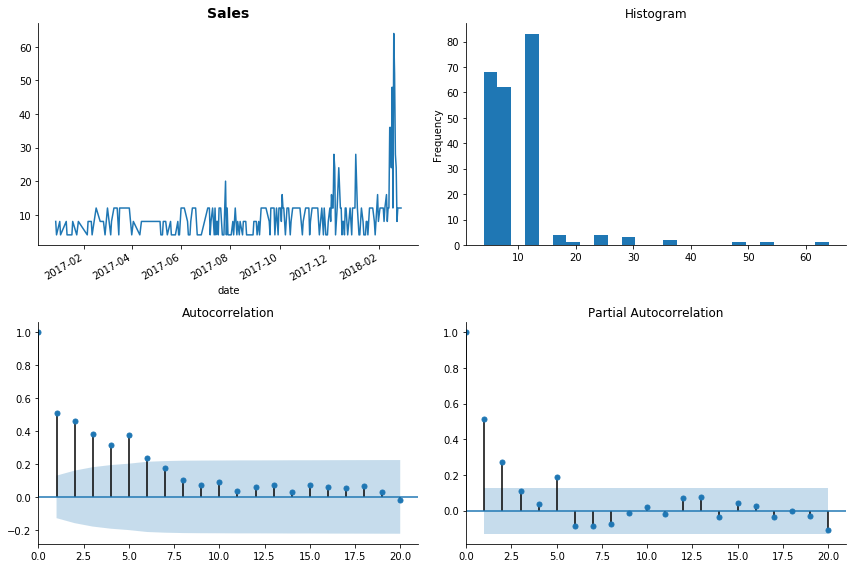

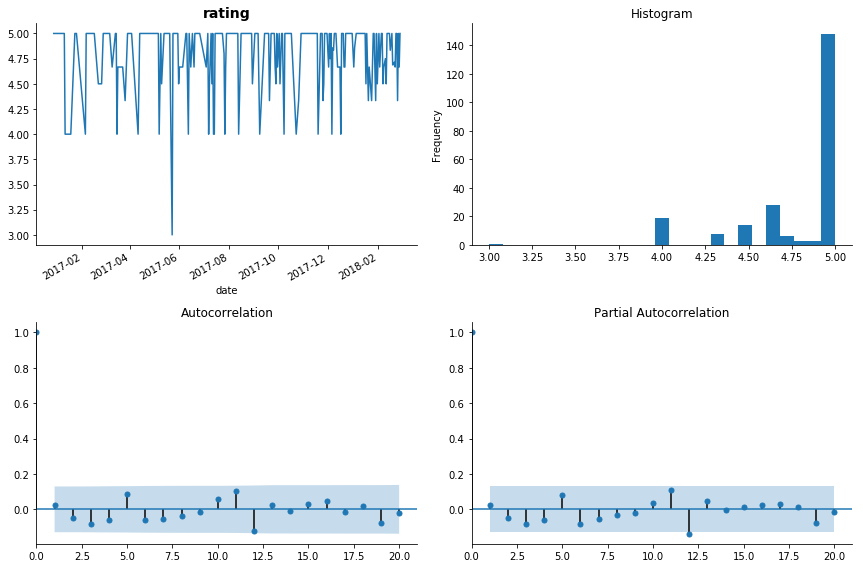

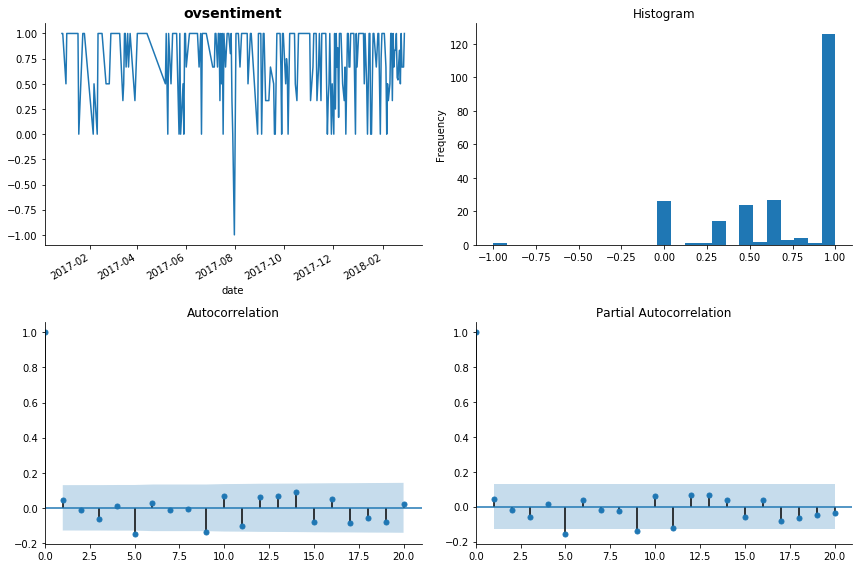

In [156]:
num_var5 = len(prod5.iloc[1, :])
for i in range(0, num_var5):
    tsplot(prod5.iloc[:, i].dropna(), title=prod5.columns[i], lags=20)
plt.show()

In [157]:
plt.clf()

<Figure size 432x288 with 0 Axes>

In [158]:
prod5_transformed = prod5.copy()
prod5_transformed['Sales'] = np.log(prod5_transformed['Sales'])
prod5_transformed['Sales'] = prod5_transformed['Sales'].diff(1)

prod5_transformed['rating'] = prod5_transformed['rating'].diff(1)
prod5_transformed['ovsentiment'] = prod5_transformed['ovsentiment'].diff(1)

prod5_transformed.dropna(inplace=True)

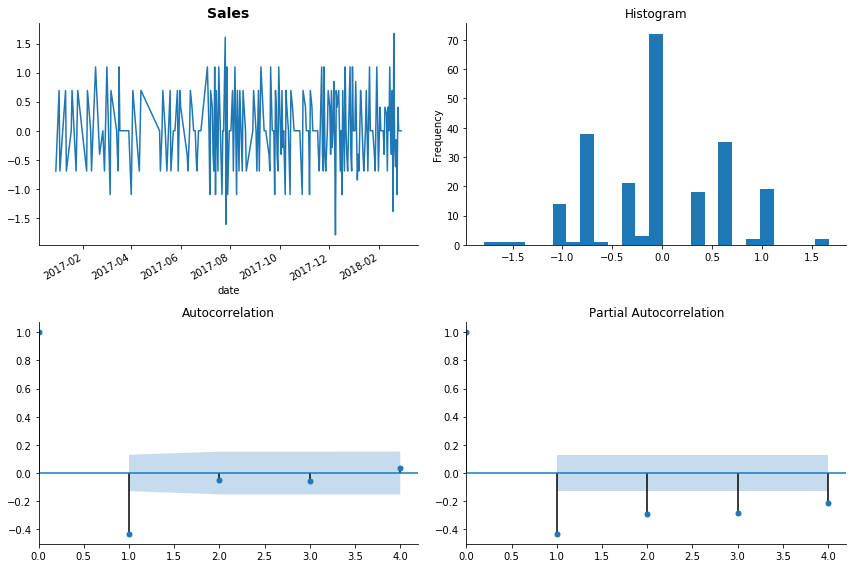

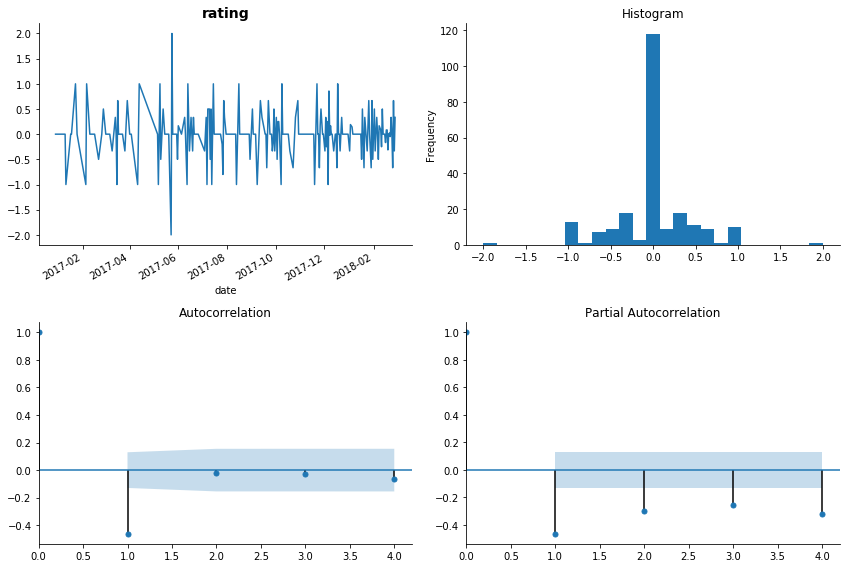

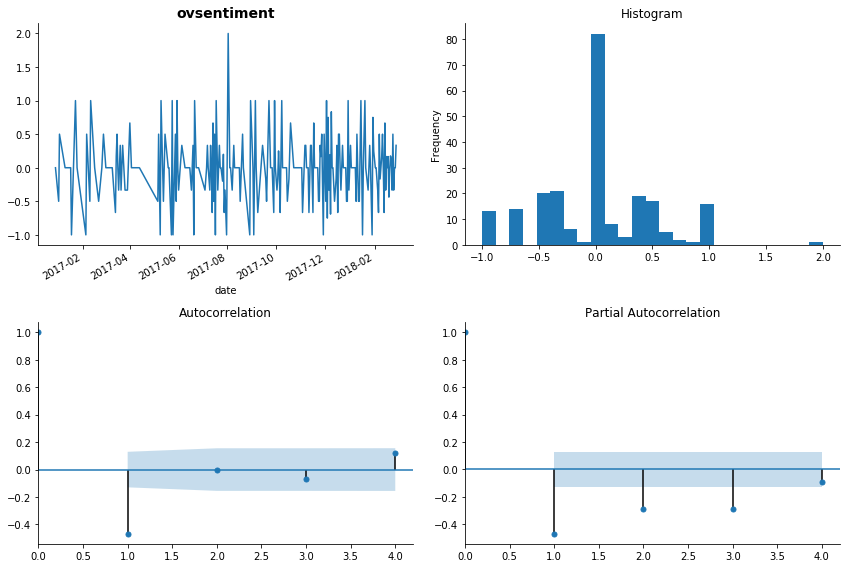

In [159]:
num_var5 = len(prod5_transformed.iloc[1, :])
for i in range(0, num_var5):
    tsplot(prod5_transformed.iloc[:, i].dropna(), title=prod5_transformed.columns[i], lags=4)
plt.show()

In [160]:
plt.clf()

<Figure size 432x288 with 0 Axes>

In [161]:
# Stationarity test (Augmented Dickey-Fuller test)
prod5_transformedTest = routines.tsTest(prod5_transformed['Sales'].dropna(), '5aa2c35e35d6d34b0032a796')
prod5_transformedTest.adfuller()

5aa2c35e35d6d34b0032a796


Value                        Label
0 -1.117651e+01               Test Statistic
1  1.037706e-17                      p-value
2  4.000000e+00                   #Lags Used
3  2.240000e+02  Number of Observations Used
4 -3.999764e+00        Critical value for 1%
5 -3.430274e+00        Critical value for 5%
6 -3.138673e+00       Critical value for 10%

In [162]:
# Stationarity test (Augmented Dickey-Fuller test)
prod5_transformedTest = routines.tsTest(prod5_transformed['rating'].dropna(), '5aa2c35e35d6d34b0032a796')
prod5_transformedTest.adfuller()

5aa2c35e35d6d34b0032a796


Value                        Label
0 -7.551471e+00               Test Statistic
1  7.758221e-10                      p-value
2  1.100000e+01                   #Lags Used
3  2.170000e+02  Number of Observations Used
4 -4.001106e+00        Critical value for 1%
5 -3.430919e+00        Critical value for 5%
6 -3.139051e+00       Critical value for 10%

In [163]:
# Stationarity test (Augmented Dickey-Fuller test)
prod5_transformedTest = routines.tsTest(prod5_transformed['ovsentiment'].dropna(), '5aa2c35e35d6d34b0032a796')
prod5_transformedTest.adfuller()

5aa2c35e35d6d34b0032a796


Value                        Label
0 -8.011056e+00               Test Statistic
1  6.736645e-11                      p-value
2  1.200000e+01                   #Lags Used
3  2.160000e+02  Number of Observations Used
4 -4.001305e+00        Critical value for 1%
5 -3.431014e+00        Critical value for 5%
6 -3.139107e+00       Critical value for 10%

In [164]:
# Train-Test Set Split
train5 = ceil(prod5_transformed.shape[0] * 0.8)
y_train5 = prod5_transformed[0:train5]
y_test5 = prod5_transformed[train5:]
y_train5.shape, y_test5.shape

((184, 3), (45, 3))

In [165]:
BIC5 = detpq(y_train5, par=range(0,6))

In [166]:
BIC5

index   param          BIC
0       0  (0, 1)   660.302126
1       6  (1, 1)   708.554502
2       1  (0, 2)   724.816091
3       7  (1, 2)   746.289690
4      12  (2, 1)   748.247285
5       8  (1, 3)   784.885928
6      18  (3, 1)   790.590616
7      13  (2, 2)   792.224011
8       2  (0, 3)   806.039737
9      19  (3, 2)   822.169245
10     14  (2, 3)   824.046717
11      3  (0, 4)   832.738609
12     24  (4, 1)   834.226423
13      9  (1, 4)   836.584748
14     17  (3, 0)   837.879364
15     11  (2, 0)   845.350420
16     23  (4, 0)   848.806062
17      5  (1, 0)   855.292458
18     30  (5, 1)   856.001412
19     20  (3, 3)   862.918486
20     25  (4, 2)   864.401361
21     29  (5, 0)   865.595604
22     15  (2, 4)   868.119732
23     10  (1, 5)   872.420430
24     31  (5, 2)   887.454483
25      4  (0, 5)   893.496873
26     21  (3, 4)   900.377082
27     26  (4, 3)   903.351731
28     16  (2, 5)   906.931529
29     27  (4, 4)   941.518503
30     32  (5, 3)   944.228677
31     22  (3, 5)   948.781879
32     33  (5, 4)   971.007544
33     28  (4, 5)   989.421501
34     34  (5, 5)  1018.824749

In [167]:
model5 = sm.tsa.VARMAX(y_train5, order=(3, 0))
result5 = model5.fit(maxiter=1000, disp=False)

result5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   Statespace Model Results                                   
==============================================================================================
Dep. Variable:     ['Sales', 'rating', 'ovsentiment']   No. Observations:                  184
Model:                                         VAR(3)   Log Likelihood                -325.071
                                          + intercept   AIC                            722.142
Date:                                Sat, 15 Sep 2018   BIC                            837.879
Time:                                        07:45:11   HQIC                           769.052
Sample:                                             0                                         
                                                - 184                                         
Covariance Type:                                  opg                                         
=====================================================================================
Ljung-Box (Q):          64.25, 80.89, 39.69   Jarque-Bera (JB):   2.18, 123.36, 13.76
Prob(Q):                   0.01, 0.00, 0.48   Prob(JB):              0.34, 0.00, 0.00
Heteroskedasticity (H):    1.31, 0.53, 0.87   Skew:               -0.17, -1.39, -0.65
Prob(H) (two-sided):       0.29, 0.01, 0.58   Kurtosis:              2.59, 5.90, 3.32
                            Results for equation Sales                            
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0140      0.046      0.307      0.759      -0.076       0.104
L1.Sales          -0.6898      0.087     -7.890      0.000      -0.861      -0.518
L1.rating         -0.1363      0.112     -1.215      0.225      -0.356       0.084
L1.ovsentiment     0.1181      0.100      1.178      0.239      -0.078       0.315
L2.Sales          -0.4972      0.099     -5.032      0.000      -0.691      -0.304
L2.rating         -0.2030      0.119     -1.712      0.087      -0.435       0.029
L2.ovsentiment     0.1154      0.115      1.005      0.315      -0.110       0.340
L3.Sales          -0.2938      0.078     -3.790      0.000      -0.446      -0.142
L3.rating         -0.0524      0.098     -0.533      0.594      -0.245       0.140
L3.ovsentiment     0.2293      0.103      2.222      0.026       0.027       0.432
                           Results for equation rating                            
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0020      0.045     -0.044      0.965      -0.090       0.086
L1.Sales          -0.0294      0.059     -0.499      0.618      -0.145       0.086
L1.rating         -0.6498      0.078     -8.379      0.000      -0.802      -0.498
L1.ovsentiment    -0.0491      0.088     -0.557      0.578      -0.222       0.124
L2.Sales          -0.0302      0.080     -0.379      0.705      -0.186       0.126
L2.rating         -0.4457      0.097     -4.604      0.000      -0.635      -0.256
L2.ovsentiment    -0.1379      0.115     -1.202      0.229      -0.363       0.087
L3.Sales          -0.0061      0.081     -0.076      0.939      -0.164       0.152
L3.rating         -0.2599      0.088     -2.967      0.003      -0.432      -0.088
L3.ovsentiment    -0.0819      0.107     -0.767      0.443      -0.291       0.127
                         Results for equation ovsentiment                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]

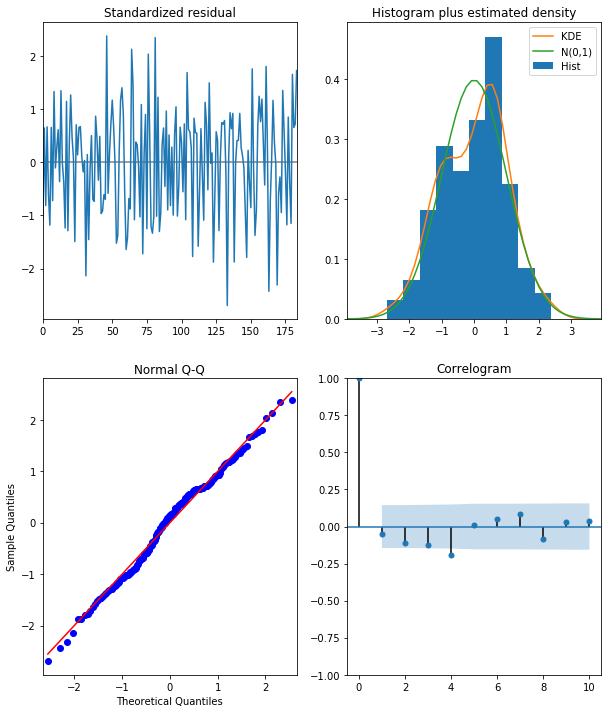

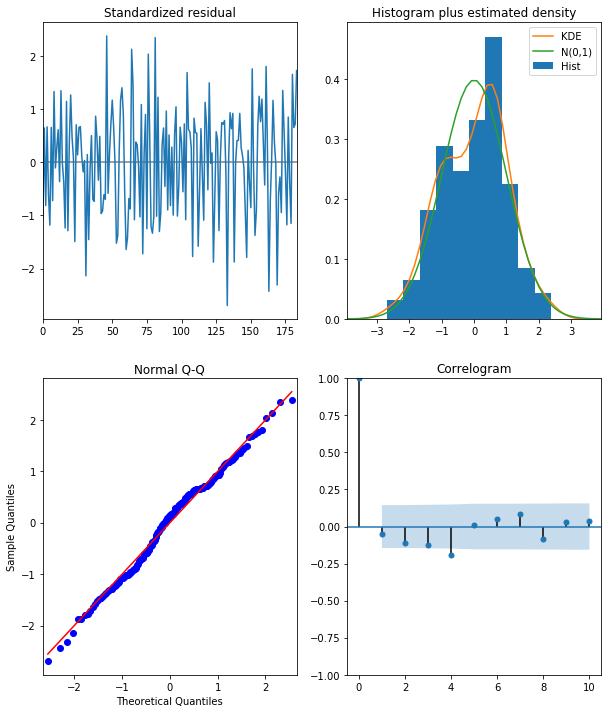

In [168]:
result5.plot_diagnostics(figsize=(10, 12))

In [169]:
plt.clf()
y_test5.shape

(45, 3)

<Figure size 432x288 with 0 Axes>

In [170]:
y_pred5 = result5.get_prediction(start=train5+1, end=prod5_transformed.shape[0])
y_forecasted5 = y_pred5.predicted_mean
y_forecasted5.shape

(45, 3)

In [171]:
np.sqrt(mean_squared_error(y_pred=np.exp(y_forecasted5), y_true=np.exp(y_test5)))

0.6542619878754741

In [172]:
mean_absolute_error(y_pred=np.exp(y_forecasted5), y_true=np.exp(y_test5))

0.3795343865817577

## <font color=blue> 6. Mongodb ID: 5aa2c35e35d6d34b0032a796-imputed </font>

In [173]:
prod6 = genData('5aa2c35e35d6d34b0032a796', conn, c, impute=True, freq='daily', standardize=False)

In [174]:
# Stationarity test (Augmented Dickey-Fuller test)
prod6Test = routines.tsTest(prod6['Sales'], '5aa2c35e35d6d34b0032a796')
prod6Test.adfuller()

5aa2c35e35d6d34b0032a796


Value                        Label
0  -20.916162               Test Statistic
1    0.000000                      p-value
2    0.000000                   #Lags Used
3  426.000000  Number of Observations Used
4   -3.980180        Critical value for 1%
5   -3.420846        Critical value for 5%
6   -3.133141       Critical value for 10%

In [175]:
# Stationarity test (Augmented Dickey-Fuller test)
prod6Test = routines.tsTest(prod6['rating'], '5aa2c35e35d6d34b0032a796')
prod6Test.adfuller()

5aa2c35e35d6d34b0032a796


Value                        Label
0 -7.235155e+00               Test Statistic
1  4.125541e-09                      p-value
2  4.000000e+00                   #Lags Used
3  4.220000e+02  Number of Observations Used
4 -3.980384e+00        Critical value for 1%
5 -3.420945e+00        Critical value for 5%
6 -3.133199e+00       Critical value for 10%

In [176]:
# Stationarity test (Augmented Dickey-Fuller test)
prod6Test = routines.tsTest(prod6['ovsentiment'], '5aa2c35e35d6d34b0032a796')
prod6Test.adfuller()

5aa2c35e35d6d34b0032a796


Value                        Label
0 -9.076695e+00               Test Statistic
1  2.436469e-13                      p-value
2  3.000000e+00                   #Lags Used
3  4.230000e+02  Number of Observations Used
4 -3.980333e+00        Critical value for 1%
5 -3.420920e+00        Critical value for 5%
6 -3.133185e+00       Critical value for 10%

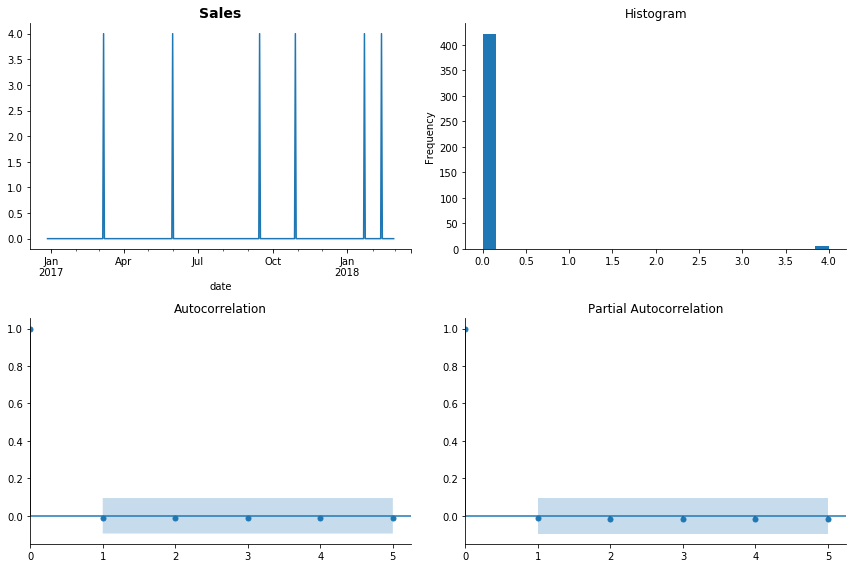

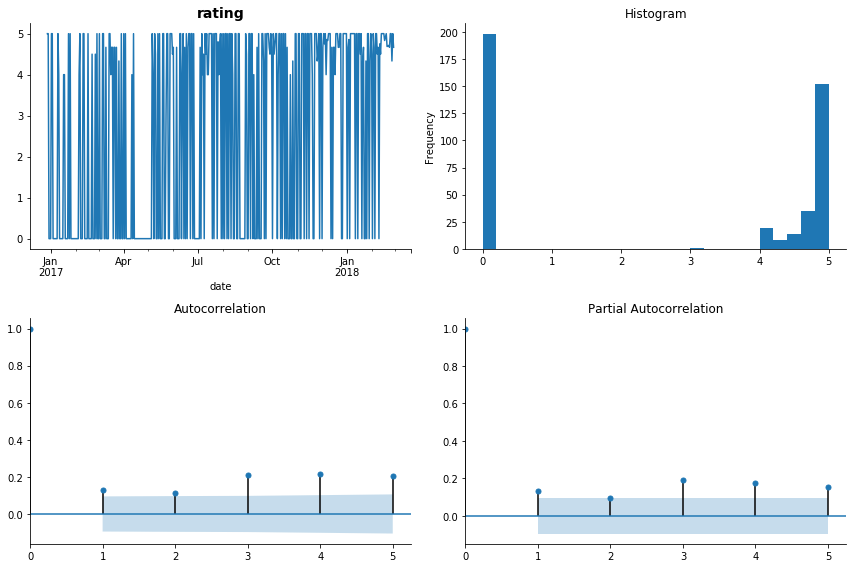

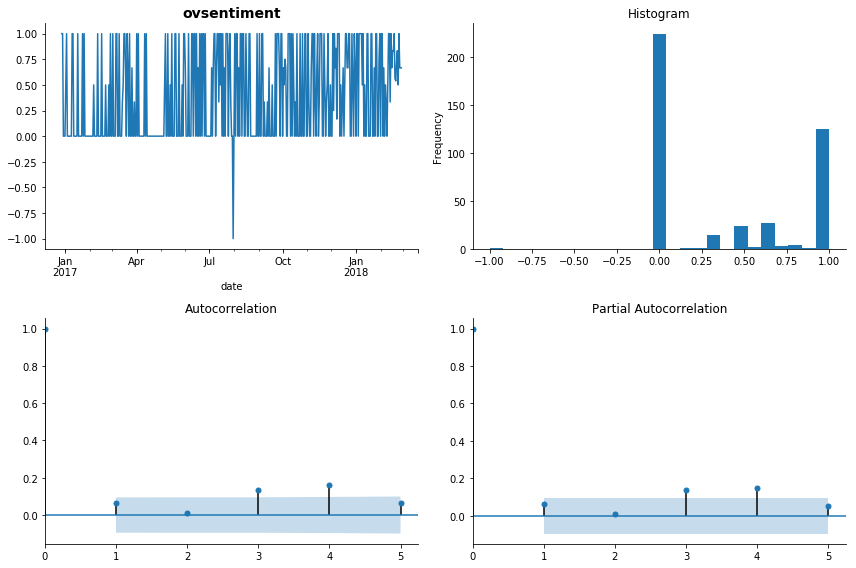

In [177]:
num_var6 = len(prod6.iloc[1, :])
for i in range(0, num_var6):
    tsplot(prod6.iloc[:, i].dropna(), title=prod6.columns[i], lags=5)
plt.show()

In [184]:
plt.clf()

prod6_transformed = prod6.copy()
prod6_transformed['Sales'] = prod6_transformed['Sales'].diff(1)

prod6_transformed['rating'] = prod6_transformed['rating'].diff(1)
prod6_transformed['ovsentiment'] = prod6_transformed['ovsentiment'].diff(1)

prod6_transformed.dropna(inplace=True)

<Figure size 432x288 with 0 Axes>

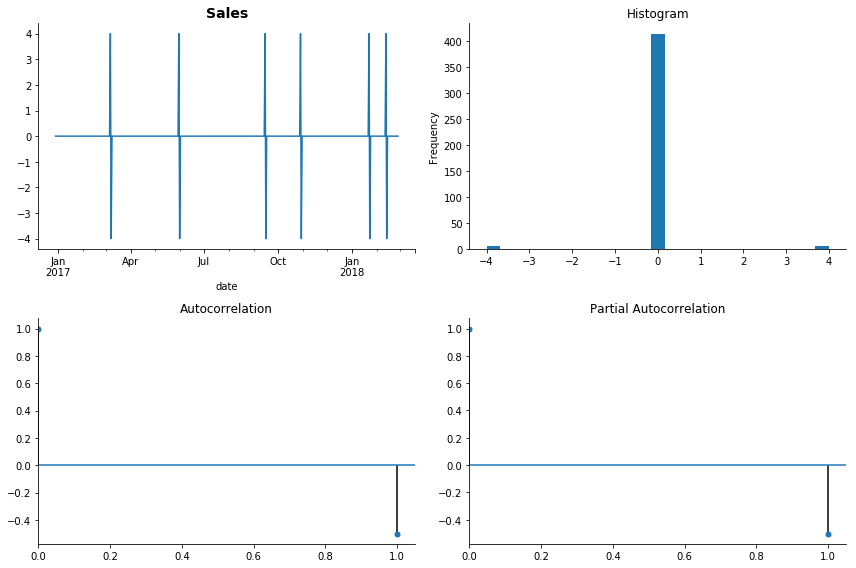

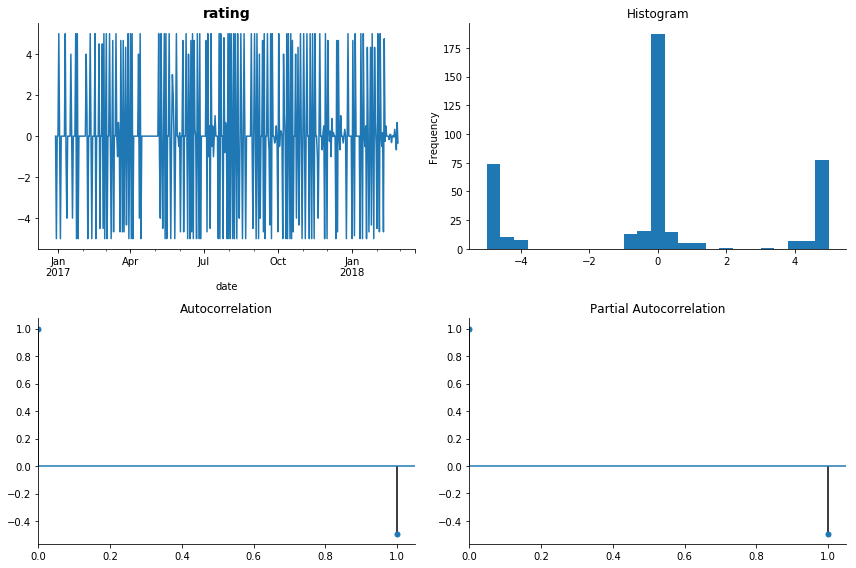

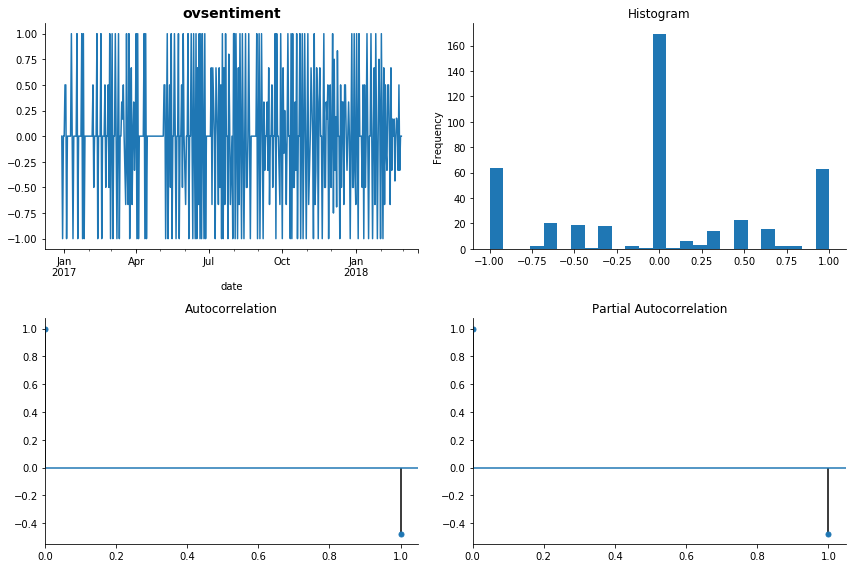

In [185]:
num_var6 = len(prod6_transformed.iloc[1, :])
for i in range(0, num_var6):
    tsplot(prod6_transformed.iloc[:, i].dropna(), title=prod6_transformed.columns[i], lags=1)
plt.show()

In [186]:
plt.clf()

<Figure size 432x288 with 0 Axes>

In [187]:
# Stationarity test (Augmented Dickey-Fuller test)
prod6_transformedTest = routines.tsTest(prod6_transformed['Sales'].dropna(), '5aa2c35e35d6d34b0032a796')
prod6_transformedTest.adfuller()

5aa2c35e35d6d34b0032a796


Value                        Label
0 -9.585012e+00               Test Statistic
1  1.808169e-14                      p-value
2  1.200000e+01                   #Lags Used
3  4.130000e+02  Number of Observations Used
4 -3.980859e+00        Critical value for 1%
5 -3.421174e+00        Critical value for 5%
6 -3.133334e+00       Critical value for 10%

In [188]:
# Stationarity test (Augmented Dickey-Fuller test)
prod6_transformedTest = routines.tsTest(prod6_transformed['rating'].dropna(), '5aa2c35e35d6d34b0032a796')
prod6_transformedTest.adfuller()

5aa2c35e35d6d34b0032a796


Value                        Label
0 -8.445414e+00               Test Statistic
1  6.698171e-12                      p-value
2  1.400000e+01                   #Lags Used
3  4.110000e+02  Number of Observations Used
4 -3.980967e+00        Critical value for 1%
5 -3.421226e+00        Critical value for 5%
6 -3.133365e+00       Critical value for 10%

In [189]:
# Stationarity test (Augmented Dickey-Fuller test)
prod6_transformedTest = routines.tsTest(prod6_transformed['ovsentiment'].dropna(), '5aa2c35e35d6d34b0032a796')
prod6_transformedTest.adfuller()

5aa2c35e35d6d34b0032a796


Value                        Label
0 -9.003386e+00               Test Statistic
1  3.565948e-13                      p-value
2  1.400000e+01                   #Lags Used
3  4.110000e+02  Number of Observations Used
4 -3.980967e+00        Critical value for 1%
5 -3.421226e+00        Critical value for 5%
6 -3.133365e+00       Critical value for 10%

In [190]:
# Train-Test Set Split
train6 = ceil(prod6_transformed.shape[0] * 0.8)
y_train6 = prod6_transformed[0:train6]
y_test6 = prod6_transformed[train6:]
y_train6.shape, y_test6.shape

BIC6 = detpq(y_train6, par=range(0,6))

In [191]:
BIC6

index   param          BIC
0       0  (0, 1)  2104.390421
1       6  (1, 1)  2174.839251
2      12  (2, 1)  2219.897379
3       7  (1, 2)  2220.627890
4      13  (2, 2)  2260.000124
5      18  (3, 1)  2275.153267
6       1  (0, 2)  2303.289184
7      19  (3, 2)  2305.797318
8      14  (2, 3)  2309.191797
9       8  (1, 3)  2319.857211
10     24  (4, 1)  2339.512055
11     20  (3, 3)  2352.778862
12     23  (4, 0)  2359.670459
13     15  (2, 4)  2360.746632
14     17  (3, 0)  2365.150563
15     25  (4, 2)  2373.335621
16     29  (5, 0)  2391.287863
17     21  (3, 4)  2396.116612
18     26  (4, 3)  2397.103141
19      9  (1, 4)  2397.809925
20     11  (2, 0)  2397.906282
21     30  (5, 1)  2398.502741
22     31  (5, 2)  2414.392883
23     16  (2, 5)  2416.542212
24      3  (0, 4)  2418.677116
25     10  (1, 5)  2428.256712
26     27  (4, 4)  2440.475016
27     22  (3, 5)  2443.440303
28     32  (5, 3)  2449.798425
29      4  (0, 5)  2450.595469
30     28  (4, 5)  2488.149224
31      5  (1, 0)  2490.009717
32     33  (5, 4)  2501.271908
33      2  (0, 3)  2533.497467
34     34  (5, 5)  2538.605770

In [192]:
model6 = sm.tsa.VARMAX(y_train6, order=(4, 0))
result6 = model6.fit(maxiter=1000, disp=False)

result6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   Statespace Model Results                                   
==============================================================================================
Dep. Variable:     ['Sales', 'rating', 'ovsentiment']   No. Observations:                  341
Model:                                         VAR(4)   Log Likelihood               -1048.618
                                          + intercept   AIC                           2187.236
Date:                                Sat, 15 Sep 2018   BIC                           2359.670
Time:                                        08:32:29   HQIC                          2255.936
Sample:                                    12-29-2016                                         
                                         - 12-04-2017                                         
Covariance Type:                                  opg                                         
=========================================================================================
Ljung-Box (Q):          23.33, 49.03, 47.15   Jarque-Bera (JB):   40928.51, 13.36, 275.82
Prob(Q):                   0.98, 0.15, 0.20   Prob(JB):                  0.00, 0.00, 0.00
Heteroskedasticity (H):    1.93, 1.03, 2.18   Skew:                     6.34, 0.03, -1.06
Prob(H) (two-sided):       0.00, 0.89, 0.00   Kurtosis:                 55.15, 2.03, 6.86
                            Results for equation Sales                            
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.871e-05      0.055     -0.000      1.000      -0.109       0.108
L1.Sales          -0.8051      0.059    -13.598      0.000      -0.921      -0.689
L1.rating          0.0070      0.059      0.119      0.905      -0.109       0.123
L1.ovsentiment     0.0851      0.289      0.294      0.769      -0.482       0.652
L2.Sales          -0.6091      0.060    -10.092      0.000      -0.727      -0.491
L2.rating          0.0238      0.058      0.412      0.681      -0.090       0.137
L2.ovsentiment    -0.0639      0.404     -0.158      0.874      -0.856       0.728
L3.Sales          -0.3969      0.061     -6.533      0.000      -0.516      -0.278
L3.rating          0.0461      0.053      0.876      0.381      -0.057       0.149
L3.ovsentiment    -0.1016      0.429     -0.237      0.813      -0.942       0.739
L4.Sales          -0.2016      0.044     -4.631      0.000      -0.287      -0.116
L4.rating          0.0210      0.070      0.299      0.765      -0.116       0.158
L4.ovsentiment    -0.0825      0.385     -0.214      0.830      -0.837       0.672
                           Results for equation rating                            
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0119      0.150      0.079      0.937      -0.282       0.306
L1.Sales           0.1841      0.444      0.415      0.678      -0.685       1.054
L1.rating         -0.8499      0.091     -9.294      0.000      -1.029      -0.671
L1.ovsentiment    -0.2511      0.454     -0.554      0.580      -1.140       0.638
L2.Sales          -0.4263      0.786     -0.542      0.588      -1.967       1.115
L2.rating         -0.6594      0.110     -5.993      0.000      -0.875      -0.444
L2.ovsentiment    -0.6419      0.551     -1.164      0.244      -1.723       0.439
L3.Sales          -0.3962      0.583     -0.679      0.497      -1.540       0.747
L3.rating         -0.4717      0.119     -3.971      0.000      -0.705      -0.239
L3.ovsentiment    -0.3147      0.592     -0.531      0.595    

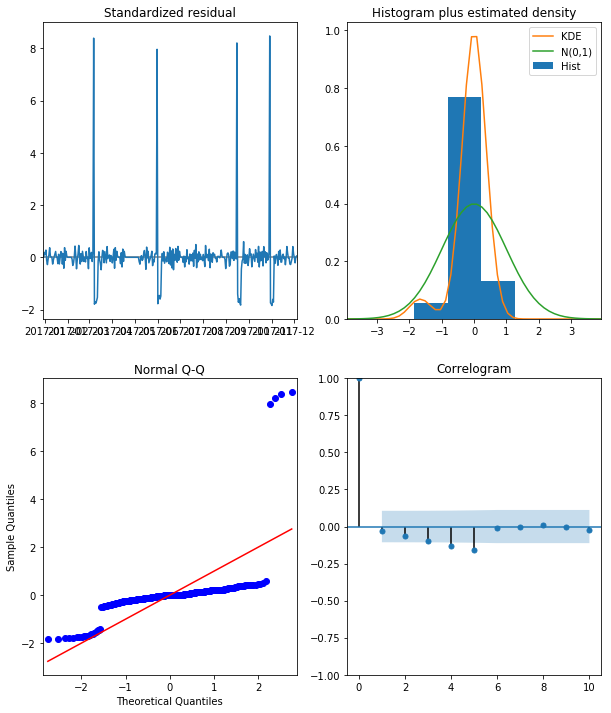

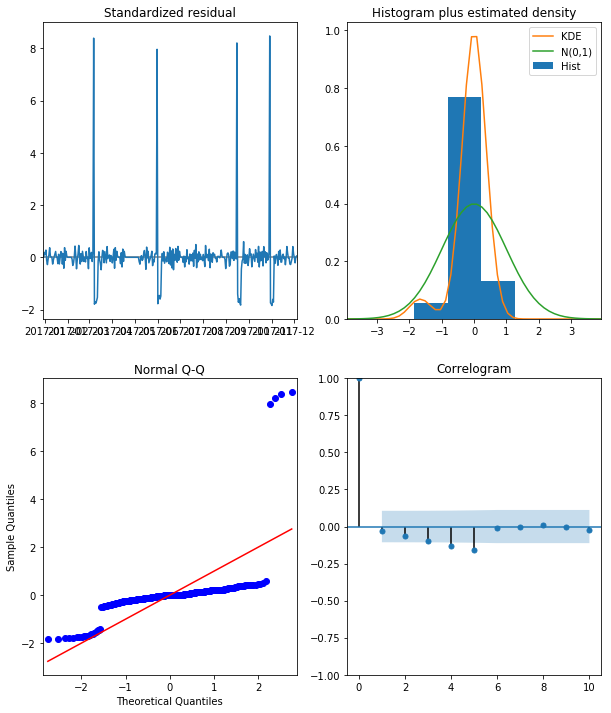

In [193]:
result6.plot_diagnostics(figsize=(10, 12))

In [194]:
plt.clf()
y_test6.shape

(85, 3)

<Figure size 432x288 with 0 Axes>

In [195]:
y_pred6 = result6.get_prediction(start=train6+1, end=prod6_transformed.shape[0])
y_forecasted6 = y_pred6.predicted_mean
y_forecasted6.shape

(85, 3)

In [196]:
np.sqrt(mean_squared_error(y_pred=y_forecasted6, y_true=y_test6))

1.708543215007269

In [197]:
mean_absolute_error(y_pred=y_forecasted6, y_true=y_test6)

0.7872381104620251

## <font color=blue> 7. Mongodb ID: 5a93e8768cbad97881597597 </font>

In [198]:
prod7 = genData('5a93e8768cbad97881597597', conn, c, impute=False, freq='daily', standardize=False)

In [199]:
# Stationarity test (Augmented Dickey-Fuller test)
prod7Test = routines.tsTest(prod7['Sales'], '5a93e8768cbad97881597597')
prod7Test.adfuller()

5a93e8768cbad97881597597


Value                        Label
0    -2.356416               Test Statistic
1     0.403031                      p-value
2    21.000000                   #Lags Used
3  1097.000000  Number of Observations Used
4    -3.967046        Critical value for 1%
5    -3.414500        Critical value for 5%
6    -3.129410       Critical value for 10%

In [200]:
# Stationarity test (Augmented Dickey-Fuller test)
prod7Test = routines.tsTest(prod7['rating'], '5a93e8768cbad97881597597')
prod7Test.adfuller()

5a93e8768cbad97881597597


Value                        Label
0    -3.169034               Test Statistic
1     0.090750                      p-value
2    20.000000                   #Lags Used
3  1098.000000  Number of Observations Used
4    -3.967039        Critical value for 1%
5    -3.414496        Critical value for 5%
6    -3.129408       Critical value for 10%

In [201]:
# Stationarity test (Augmented Dickey-Fuller test)
prod7Test = routines.tsTest(prod7['ovsentiment'], '5a93e8768cbad97881597597')
prod7Test.adfuller()

5a93e8768cbad97881597597


Value                        Label
0    -4.998043               Test Statistic
1     0.000207                      p-value
2    15.000000                   #Lags Used
3  1103.000000  Number of Observations Used
4    -3.967001        Critical value for 1%
5    -3.414478        Critical value for 5%
6    -3.129397       Critical value for 10%

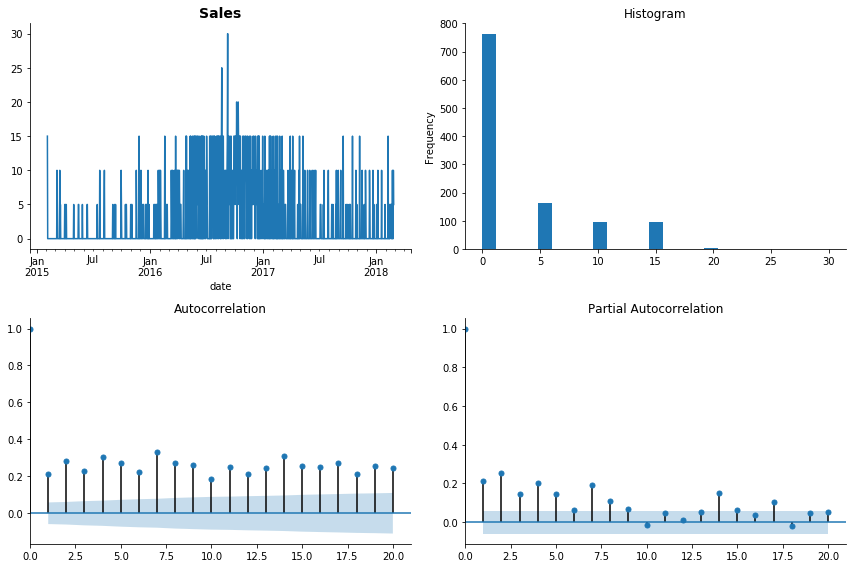

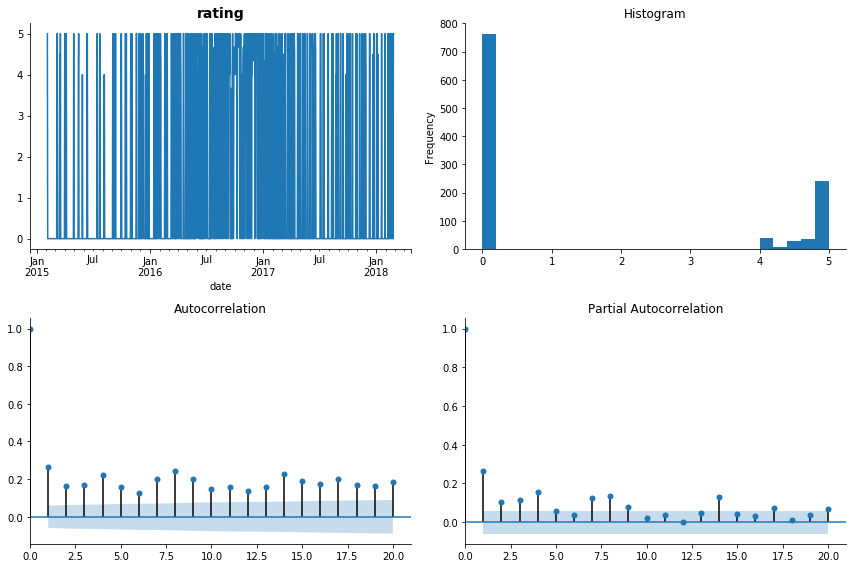

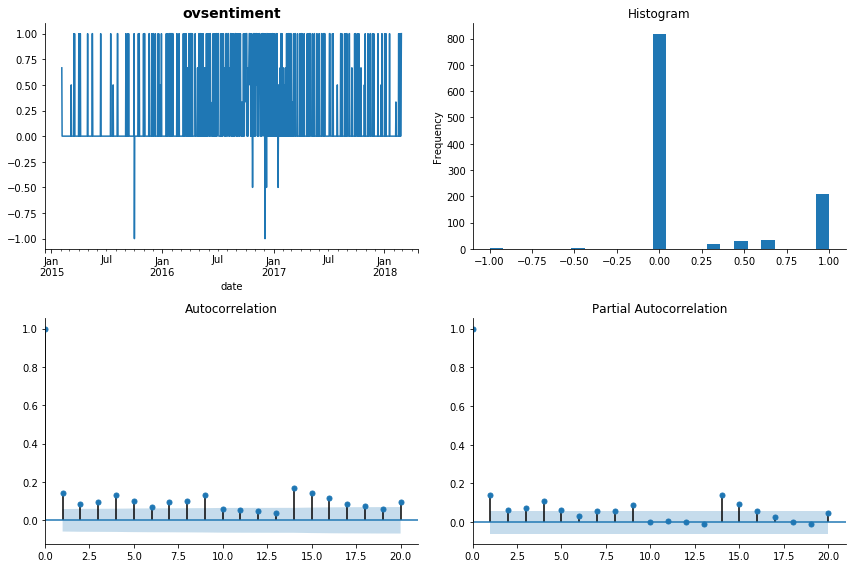

In [202]:
num_var7 = len(prod7.iloc[1, :])
for i in range(0, num_var7):
    tsplot(prod7.iloc[:, i].dropna(), title=prod7.columns[i], lags=20)
plt.show()

In [203]:
plt.clf()

<Figure size 432x288 with 0 Axes>

In [204]:
prod7_transformed = prod7.copy()
prod7_transformed['Sales'] = prod7_transformed['Sales'].diff(1)

prod7_transformed['rating'] = prod7_transformed['rating'].diff(1)
prod7_transformed['ovsentiment'] = prod7_transformed['ovsentiment'].diff(1)

prod7_transformed.dropna(inplace=True)

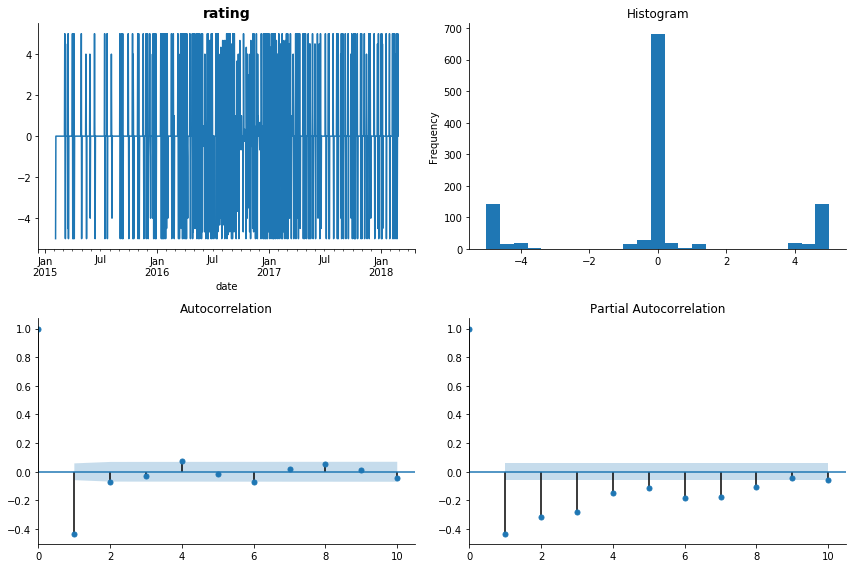

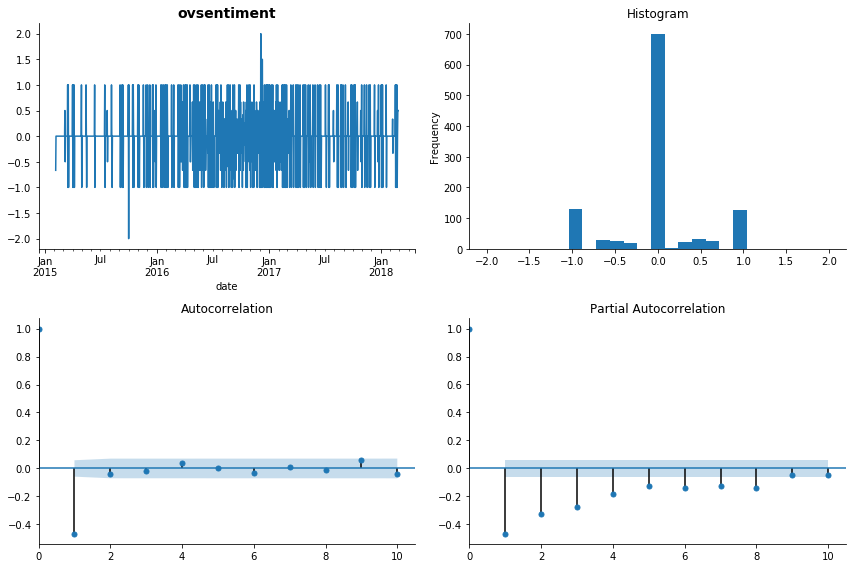

In [205]:
num_var7 = len(prod7_transformed.iloc[1, :])
for i in range(0, num_var7):
    tsplot(prod7_transformed.iloc[:, i].dropna(), title=prod7_transformed.columns[i], lags=10)
plt.show()

In [206]:
plt.clf()

<Figure size 432x288 with 0 Axes>

In [207]:
# Stationarity test (Augmented Dickey-Fuller test)
prod7_transformedTest = routines.tsTest(prod7_transformed['Sales'].dropna(), '5a93e8768cbad97881597597')
prod7_transformedTest.adfuller()

5a93e8768cbad97881597597


Value                        Label
0 -1.276099e+01               Test Statistic
1  2.812390e-20                      p-value
2  2.000000e+01                   #Lags Used
3  1.097000e+03  Number of Observations Used
4 -3.967046e+00        Critical value for 1%
5 -3.414500e+00        Critical value for 5%
6 -3.129410e+00       Critical value for 10%

In [208]:
# Stationarity test (Augmented Dickey-Fuller test)
prod7_transformedTest = routines.tsTest(prod7_transformed['rating'].dropna(), '5a93e8768cbad97881597597')
prod7_transformedTest.adfuller()

5a93e8768cbad97881597597


Value                        Label
0 -1.301725e+01               Test Statistic
1  1.291981e-20                      p-value
2  1.900000e+01                   #Lags Used
3  1.098000e+03  Number of Observations Used
4 -3.967039e+00        Critical value for 1%
5 -3.414496e+00        Critical value for 5%
6 -3.129408e+00       Critical value for 10%

In [209]:
# Stationarity test (Augmented Dickey-Fuller test)
prod7_transformedTest = routines.tsTest(prod7_transformed['ovsentiment'].dropna(), '5a93e8768cbad97881597597')
prod7_transformedTest.adfuller()

5a93e8768cbad97881597597


Value                        Label
0 -1.258429e+01               Test Statistic
1  4.959381e-20                      p-value
2  1.900000e+01                   #Lags Used
3  1.098000e+03  Number of Observations Used
4 -3.967039e+00        Critical value for 1%
5 -3.414496e+00        Critical value for 5%
6 -3.129408e+00       Critical value for 10%

In [210]:
# Train-Test Set Split
train7 = ceil(prod7_transformed.shape[0] * 0.8)
y_train7 = prod7_transformed[0:train7]
y_test7 = prod7_transformed[train7:]
y_train7.shape, y_test7.shape

((895, 3), (223, 3))

In [211]:
BIC7 = detpq(y_train7, par=range(0,6))

In [212]:
BIC7

index   param          BIC
0       6  (1, 1)  8296.254459
1       0  (0, 1)  8310.441077
2      12  (2, 1)  8329.225476
3       7  (1, 2)  8392.868836
4      18  (3, 1)  8459.810056
5      13  (2, 2)  8463.144244
6      19  (3, 2)  8473.667644
7      14  (2, 3)  8482.337549
8      24  (4, 1)  8488.816766
9      20  (3, 3)  8489.067254
10     25  (4, 2)  8495.640883
11     26  (4, 3)  8521.642362
12     30  (5, 1)  8521.784460
13     21  (3, 4)  8528.923582
14     15  (2, 4)  8533.209736
15      8  (1, 3)  8558.698247
16     31  (5, 2)  8568.835065
17     27  (4, 4)  8570.350678
18     22  (3, 5)  8584.981157
19     32  (5, 3)  8594.932838
20     28  (4, 5)  8620.438914
21      9  (1, 4)  8624.608067
22     33  (5, 4)  8633.249191
23     16  (2, 5)  8649.475017
24      1  (0, 2)  8673.934915
25     34  (5, 5)  8676.077215
26     23  (4, 0)  8697.024533
27     29  (5, 0)  8705.353704
28     10  (1, 5)  8764.361582
29     17  (3, 0)  8770.068683
30      4  (0, 5)  8815.924347
31     11  (2, 0)  8882.800448
32      2  (0, 3)  9115.099370
33      5  (1, 0)  9124.940834
34      3  (0, 4)  9350.105067

In [213]:
model7 = sm.tsa.VARMAX(y_train7, order=(4, 0))
result7 = model7.fit(maxiter=1000, disp=False)

result7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   Statespace Model Results                                   
==============================================================================================
Dep. Variable:     ['Sales', 'rating', 'ovsentiment']   No. Observations:                  895
Model:                                         VAR(4)   Log Likelihood               -4195.584
                                          + intercept   AIC                           8481.167
Date:                                Sat, 15 Sep 2018   BIC                           8697.025
Time:                                        11:40:05   HQIC                          8563.648
Sample:                                    02-05-2015                                         
                                         - 07-18-2017                                         
Covariance Type:                                  opg                                         
===========================================================================================
Ljung-Box (Q):          163.75, 100.15, 72.58   Jarque-Bera (JB):   211.29, 282.88, 1593.04
Prob(Q):                     0.00, 0.00, 0.00   Prob(JB):                  0.00, 0.00, 0.00
Heteroskedasticity (H):      4.69, 2.14, 3.94   Skew:                     0.82, 0.54, -1.47
Prob(H) (two-sided):         0.00, 0.00, 0.00   Kurtosis:                  4.72, 5.53, 8.84
                            Results for equation Sales                            
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0098      0.190     -0.052      0.959      -0.381       0.362
L1.Sales          -1.0346      0.053    -19.595      0.000      -1.138      -0.931
L1.rating          0.3570      0.157      2.268      0.023       0.048       0.665
L1.ovsentiment     0.3095      0.584      0.530      0.596      -0.835       1.454
L2.Sales          -0.6846      0.065    -10.557      0.000      -0.812      -0.558
L2.rating          0.0084      0.195      0.043      0.965      -0.373       0.390
L2.ovsentiment     0.5644      0.743      0.759      0.448      -0.892       2.021
L3.Sales          -0.5012      0.064     -7.846      0.000      -0.626      -0.376
L3.rating         -0.1227      0.185     -0.663      0.507      -0.485       0.240
L3.ovsentiment     1.2006      0.713      1.683      0.092      -0.197       2.599
L4.Sales          -0.2707      0.055     -4.902      0.000      -0.379      -0.162
L4.rating          0.0948      0.167      0.569      0.569      -0.232       0.421
L4.ovsentiment     0.3550      0.597      0.595      0.552      -0.815       1.525
                           Results for equation rating                            
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0017      0.088     -0.020      0.984      -0.173       0.170
L1.Sales          -0.1551      0.029     -5.331      0.000      -0.212      -0.098
L1.rating         -0.4852      0.075     -6.444      0.000      -0.633      -0.338
L1.ovsentiment     0.4832      0.258      1.876      0.061      -0.022       0.988
L2.Sales          -0.0913      0.035     -2.621      0.009      -0.160      -0.023
L2.rating         -0.4304      0.090     -4.773      0.000      -0.607      -0.254
L2.ovsentiment     0.0165      0.341      0.048      0.961      -0.652       0.685
L3.Sales          -0.0792      0.033     -2.407      0.016      -0.144      -0.015
L3.rating         -0.2821      0.084     -3.354      0.001      -0.447      -0.117
L3.ovsentiment     0.2203      0.335      0.657     

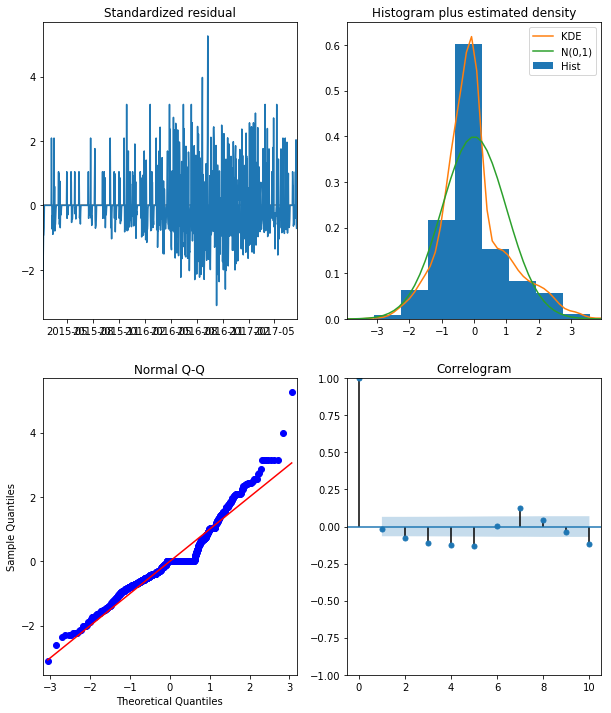

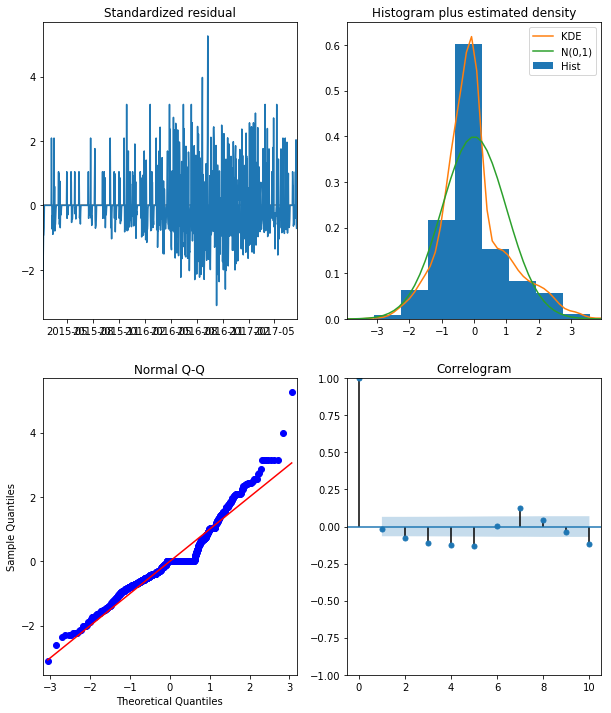

In [214]:
result7.plot_diagnostics(figsize=(10, 12))

In [215]:
plt.clf()
y_test7.shape

(223, 3)

<Figure size 432x288 with 0 Axes>

In [216]:
y_pred7 = result7.get_prediction(start=train7+1, end=prod7_transformed.shape[0])
y_forecasted7 = y_pred7.predicted_mean
y_forecasted7.shape

(223, 3)

In [217]:
np.sqrt(mean_squared_error(y_pred=y_forecasted7, y_true=y_test7))

3.1216891228981143

In [218]:
mean_absolute_error(y_pred=y_forecasted7, y_true=y_test7)

1.3990236556422124

## <font color=blue> 8. Mongodb ID: 5a93e8768cbad97881597597-imputed </font>

In [219]:
prod8 = genData('5a93e8768cbad97881597597', conn, c, impute=True, freq='daily', standardize=False)

In [220]:
# Stationarity test (Augmented Dickey-Fuller test)
prod8Test = routines.tsTest(prod8['Sales'], '5a93e8768cbad97881597597')
prod8Test.adfuller()

5a93e8768cbad97881597597


Value                        Label
0   -32.242213               Test Statistic
1     0.000000                      p-value
2     0.000000                   #Lags Used
3  1117.000000  Number of Observations Used
4    -3.966898        Critical value for 1%
5    -3.414428        Critical value for 5%
6    -3.129368       Critical value for 10%

In [221]:
# Stationarity test (Augmented Dickey-Fuller test)
prod8Test = routines.tsTest(prod8['rating'], '5a93e8768cbad97881597597')
prod8Test.adfuller()

5a93e8768cbad97881597597


Value                        Label
0    -3.175354               Test Statistic
1     0.089426                      p-value
2    20.000000                   #Lags Used
3  1097.000000  Number of Observations Used
4    -3.967046        Critical value for 1%
5    -3.414500        Critical value for 5%
6    -3.129410       Critical value for 10%

In [222]:
# Stationarity test (Augmented Dickey-Fuller test)
prod8Test = routines.tsTest(prod8['ovsentiment'], '5a93e8768cbad97881597597')
prod8Test.adfuller()

5a93e8768cbad97881597597


Value                        Label
0    -4.978540               Test Statistic
1     0.000225                      p-value
2    15.000000                   #Lags Used
3  1102.000000  Number of Observations Used
4    -3.967009        Critical value for 1%
5    -3.414482        Critical value for 5%
6    -3.129400       Critical value for 10%

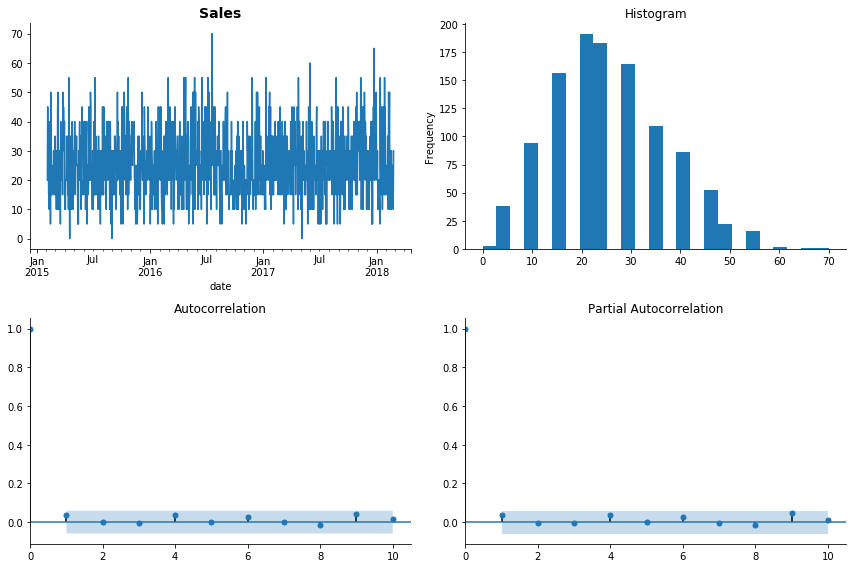

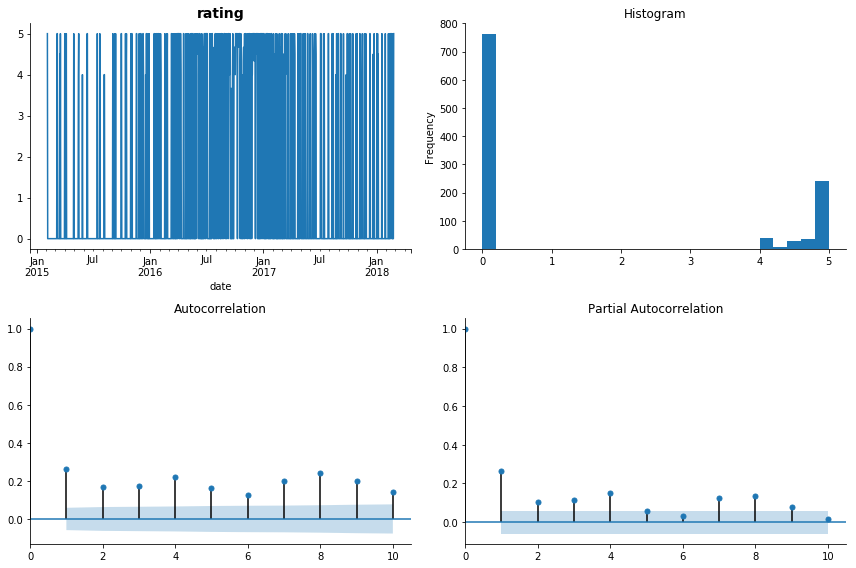

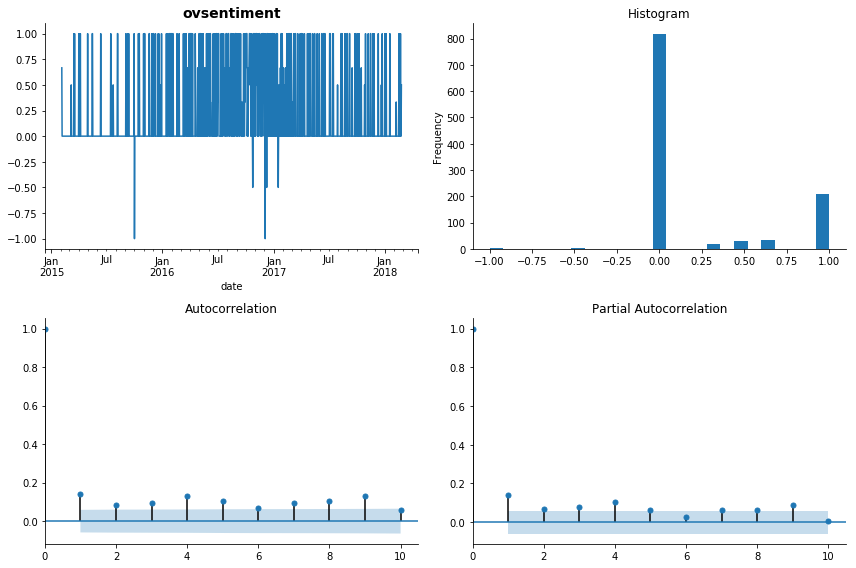

In [223]:
num_var8 = len(prod8.iloc[1, :])
for i in range(0, num_var8):
    tsplot(prod8.iloc[:, i].dropna(), title=prod8.columns[i], lags=10)
plt.show()

In [176]:
plt.clf()

<Figure size 432x288 with 0 Axes>

In [224]:
prod8_transformed = prod8.copy()
prod8_transformed['Sales'] = prod8_transformed['Sales'].diff(1)

prod8_transformed['rating'] = prod8_transformed['rating'].diff(1)
prod8_transformed['ovsentiment'] = prod8_transformed['ovsentiment'].diff(1)

prod8_transformed.dropna(inplace=True)

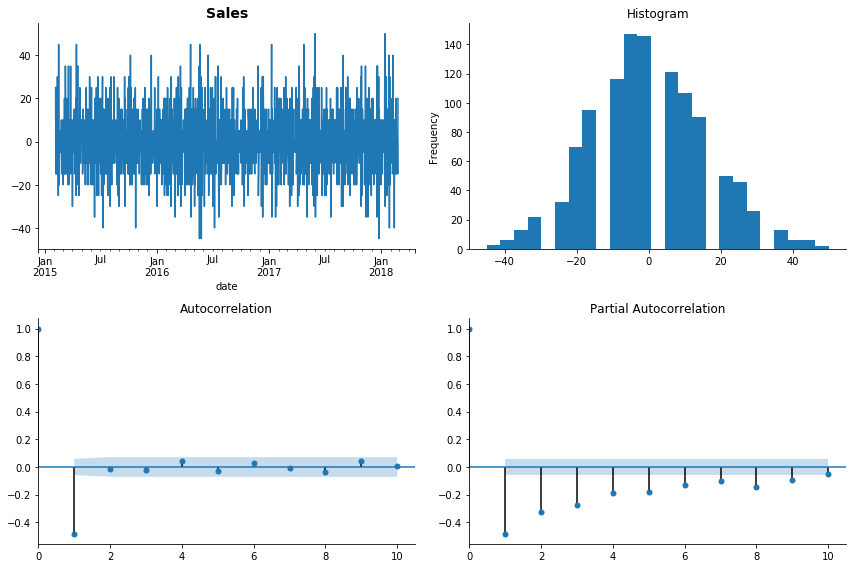

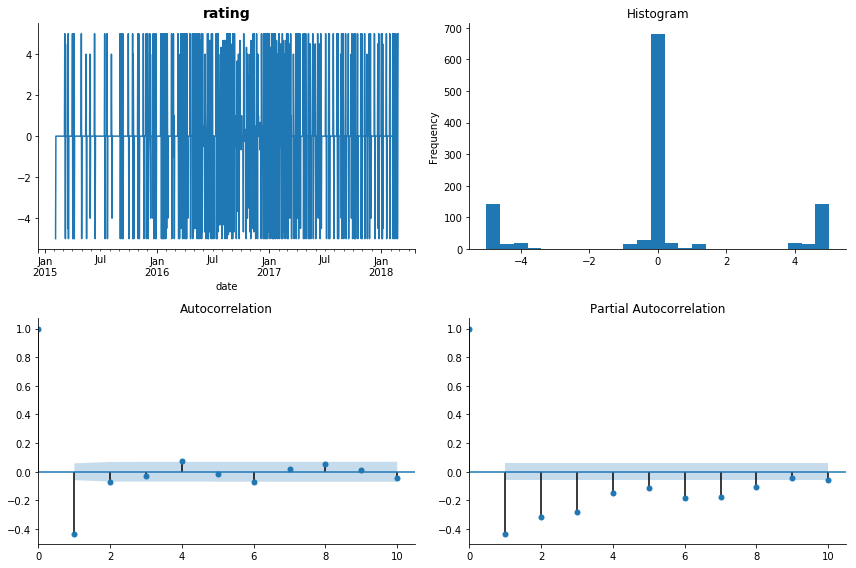

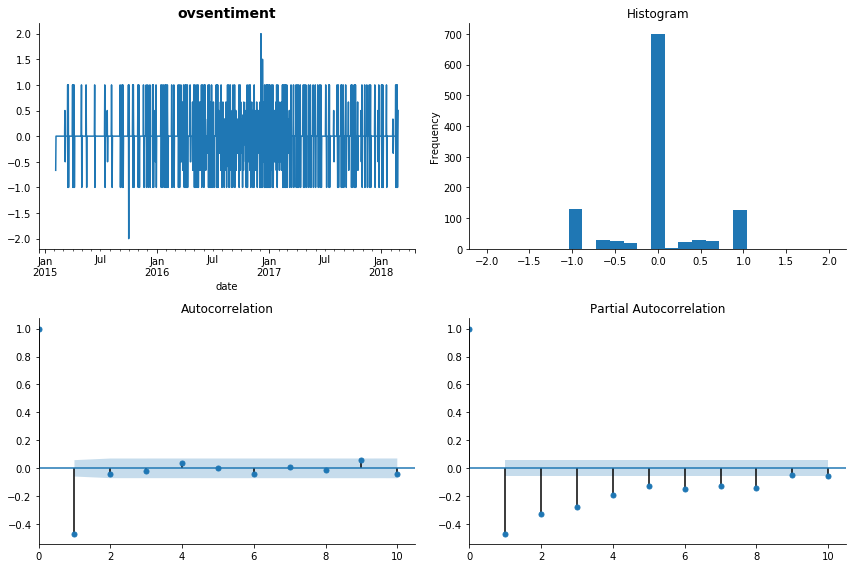

In [225]:
num_var8 = len(prod8_transformed.iloc[1, :])
for i in range(0, num_var8):
    tsplot(prod8_transformed.iloc[:, i].dropna(), title=prod8_transformed.columns[i], lags=10)
plt.show()

In [226]:
plt.clf()

<Figure size 432x288 with 0 Axes>

In [227]:
# Stationarity test (Augmented Dickey-Fuller test)
prod8_transformedTest = routines.tsTest(prod8_transformed['Sales'].dropna(), '5a93e8768cbad97881597597')
prod8_transformedTest.adfuller()

5a93e8768cbad97881597597


Value                        Label
0 -1.261020e+01               Test Statistic
1  4.556445e-20                      p-value
2  2.100000e+01                   #Lags Used
3  1.095000e+03  Number of Observations Used
4 -3.967061e+00        Critical value for 1%
5 -3.414507e+00        Critical value for 5%
6 -3.129415e+00       Critical value for 10%

In [228]:
# Stationarity test (Augmented Dickey-Fuller test)
prod8_transformedTest = routines.tsTest(prod8_transformed['rating'].dropna(), '5a93e8768cbad97881597597')
prod8_transformedTest.adfuller()

5a93e8768cbad97881597597


Value                        Label
0 -1.304954e+01               Test Statistic
1  1.175865e-20                      p-value
2  1.900000e+01                   #Lags Used
3  1.097000e+03  Number of Observations Used
4 -3.967046e+00        Critical value for 1%
5 -3.414500e+00        Critical value for 5%
6 -3.129410e+00       Critical value for 10%

In [229]:
# Stationarity test (Augmented Dickey-Fuller test)
prod8_transformedTest = routines.tsTest(prod8_transformed['ovsentiment'].dropna(), '5a93e8768cbad97881597597')
prod8_transformedTest.adfuller()

5a93e8768cbad97881597597


Value                        Label
0 -1.267324e+01               Test Statistic
1  3.715917e-20                      p-value
2  1.900000e+01                   #Lags Used
3  1.097000e+03  Number of Observations Used
4 -3.967046e+00        Critical value for 1%
5 -3.414500e+00        Critical value for 5%
6 -3.129410e+00       Critical value for 10%

In [230]:
# Train-Test Set Split
train8 = ceil(prod8_transformed.shape[0] * 0.8)
y_train8 = prod8_transformed[0:train8]
y_test8 = prod8_transformed[train8:]
y_train8.shape, y_test8.shape

BIC8 = detpq(y_train8, par=range(0,6))

In [231]:
BIC8

index   param           BIC
0       0  (0, 1)  11014.262282
1       6  (1, 1)  11042.632824
2      12  (2, 1)  11056.423418
3       7  (1, 2)  11082.353445
4      14  (2, 3)  11162.871634
5      18  (3, 1)  11166.369192
6      19  (3, 2)  11177.982935
7      13  (2, 2)  11211.296410
8       8  (1, 3)  11222.124313
9      21  (3, 4)  11236.168991
10     25  (4, 2)  11251.576983
11     15  (2, 4)  11255.708872
12     26  (4, 3)  11262.090967
13     24  (4, 1)  11278.500943
14      1  (0, 2)  11285.841582
15     30  (5, 1)  11302.249077
16     27  (4, 4)  11305.566644
17     20  (3, 3)  11306.480472
18     22  (3, 5)  11309.643014
19     31  (5, 2)  11311.836441
20     32  (5, 3)  11333.955082
21     28  (4, 5)  11349.383531
22     33  (5, 4)  11377.528761
23     16  (2, 5)  11378.342374
24      9  (1, 4)  11387.985545
25     34  (5, 5)  11419.429735
26     29  (5, 0)  11428.582244
27     23  (4, 0)  11430.723454
28     17  (3, 0)  11473.045866
29     10  (1, 5)  11474.658596
30      3  (0, 4)  11561.453570
31     11  (2, 0)  11624.546540
32      4  (0, 5)  11747.143867
33      2  (0, 3)  11861.635248
34      5  (1, 0)  11869.074102

In [232]:
model8 = sm.tsa.VARMAX(y_train8, order=(5, 0))
result8 = model8.fit(maxiter=1000, disp=False)

result8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   Statespace Model Results                                   
==============================================================================================
Dep. Variable:     ['Sales', 'rating', 'ovsentiment']   No. Observations:                  894
Model:                                         VAR(5)   Log Likelihood               -5530.807
                                          + intercept   AIC                          11169.614
Date:                                Sat, 15 Sep 2018   BIC                          11428.582
Time:                                        14:27:29   HQIC                         11268.574
Sample:                                    02-05-2015                                         
                                         - 07-17-2017                                         
Covariance Type:                                  opg                                         
=======================================================================================
Ljung-Box (Q):          82.55, 96.92, 71.63   Jarque-Bera (JB):   18.96, 25.10, 1801.69
Prob(Q):                   0.00, 0.00, 0.00   Prob(JB):                0.00, 0.00, 0.00
Heteroskedasticity (H):    0.85, 2.15, 4.03   Skew:                   0.36, 0.39, -1.59
Prob(H) (two-sided):       0.17, 0.00, 0.00   Kurtosis:                2.94, 2.74, 9.19
                            Results for equation Sales                            
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0131      0.438      0.030      0.976      -0.845       0.871
L1.Sales          -0.7980      0.033    -23.966      0.000      -0.863      -0.733
L1.rating          0.3348      0.303      1.106      0.269      -0.258       0.928
L1.ovsentiment    -1.3827      1.698     -0.814      0.415      -4.710       1.945
L2.Sales          -0.6670      0.043    -15.653      0.000      -0.750      -0.583
L2.rating          0.1258      0.372      0.338      0.735      -0.603       0.855
L2.ovsentiment    -0.2752      2.181     -0.126      0.900      -4.550       3.999
L3.Sales          -0.5164      0.045    -11.367      0.000      -0.605      -0.427
L3.rating          0.2662      0.401      0.664      0.507      -0.519       1.052
L3.ovsentiment    -0.0077      2.271     -0.003      0.997      -4.459       4.444
L4.Sales          -0.3095      0.042     -7.437      0.000      -0.391      -0.228
L4.rating          0.2072      0.390      0.531      0.595      -0.557       0.972
L4.ovsentiment    -0.3567      2.128     -0.168      0.867      -4.527       3.813
L5.Sales          -0.1776      0.035     -5.090      0.000      -0.246      -0.109
L5.rating          0.1423      0.301      0.473      0.636      -0.447       0.732
L5.ovsentiment    -0.6418      1.570     -0.409      0.683      -3.720       2.436
                           Results for equation rating                            
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0005      0.086      0.006      0.995      -0.168       0.169
L1.Sales          -0.0014      0.006     -0.222      0.824      -0.014       0.011
L1.rating         -0.7908      0.055    -14.263      0.000      -0.899      -0.682
L1.ovsentiment     0.4682      0.293      1.598      0.110      -0.106       1.042
L2.Sales          -0.0003      0.008     -0.033      0.974      -0.015       0.015
L2.rating         -0.6165      0.074     -8.331      0.000      -0.762      -0.471
L2.ovsentiment     0.0962      0.393      0.245      0.807      -0.675  

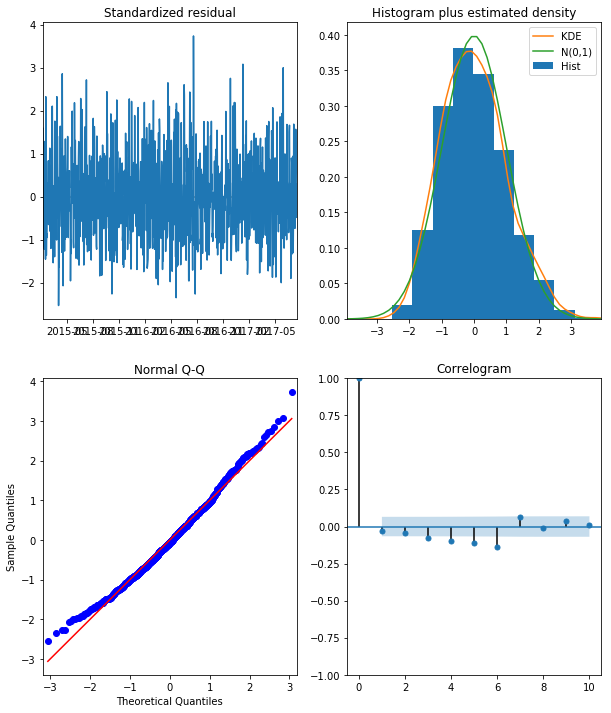

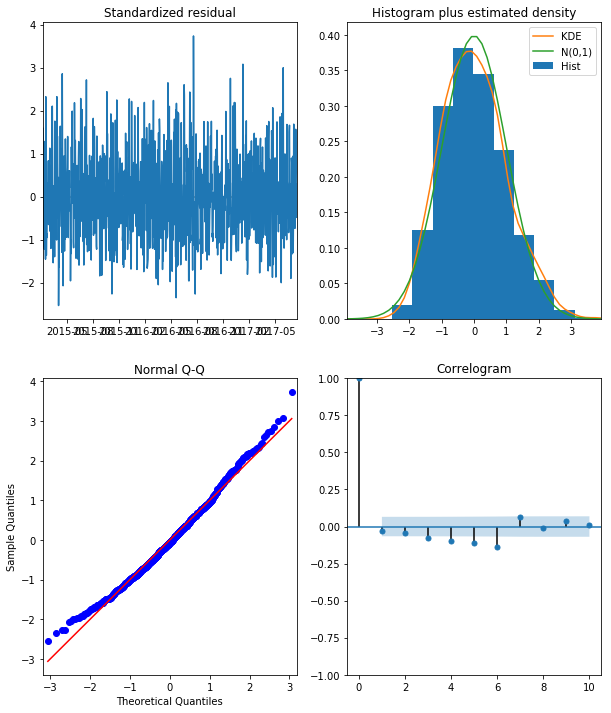

In [233]:
result8.plot_diagnostics(figsize=(10, 12))

In [234]:
plt.clf()
y_test8.shape

(223, 3)

<Figure size 432x288 with 0 Axes>

In [235]:
y_pred8 = result8.get_prediction(start=train8+1, end=prod8_transformed.shape[0])
y_forecasted8 = y_pred8.predicted_mean
y_forecasted8.shape

(223, 3)

In [236]:
np.sqrt(mean_squared_error(y_pred=y_forecasted8, y_true=y_test8))

9.791536452874718

In [237]:
mean_absolute_error(y_pred=y_forecasted8, y_true=y_test8)

5.00418221285612

## <font color=blue> 9. Mongodb ID: 5a9347b98cbad97074cb1890 </font>

In [238]:
prod9 = genData('5a9347b98cbad97074cb1890', conn, c, impute=False, freq='daily', standardize=False)

In [239]:
# Stationarity test (Augmented Dickey-Fuller test)
prod9Test = routines.tsTest(prod9['Sales'], '5a9347b98cbad97074cb1890')
prod9Test.adfuller()

5a9347b98cbad97074cb1890


Value                        Label
0 -8.613439e+00               Test Statistic
1  2.754809e-12                      p-value
2  3.000000e+00                   #Lags Used
3  3.130000e+02  Number of Observations Used
4 -3.987988e+00        Critical value for 1%
5 -3.424611e+00        Critical value for 5%
6 -3.135351e+00       Critical value for 10%

In [240]:
# Stationarity test (Augmented Dickey-Fuller test)
prod9Test = routines.tsTest(prod9['rating'], '5a9347b98cbad97074cb1890')
prod9Test.adfuller()

5a9347b98cbad97074cb1890


Value                        Label
0 -1.010230e+01               Test Statistic
1  1.403698e-15                      p-value
2  2.000000e+00                   #Lags Used
3  3.140000e+02  Number of Observations Used
4 -3.987894e+00        Critical value for 1%
5 -3.424565e+00        Critical value for 5%
6 -3.135325e+00       Critical value for 10%

In [241]:
# Stationarity test (Augmented Dickey-Fuller test)
prod9Test = routines.tsTest(prod9['ovsentiment'], '5a9347b98cbad97074cb1890')
prod9Test.adfuller()

5a9347b98cbad97074cb1890


Value                        Label
0 -1.137784e+01               Test Statistic
1  4.448185e-18                      p-value
2  2.000000e+00                   #Lags Used
3  3.140000e+02  Number of Observations Used
4 -3.987894e+00        Critical value for 1%
5 -3.424565e+00        Critical value for 5%
6 -3.135325e+00       Critical value for 10%

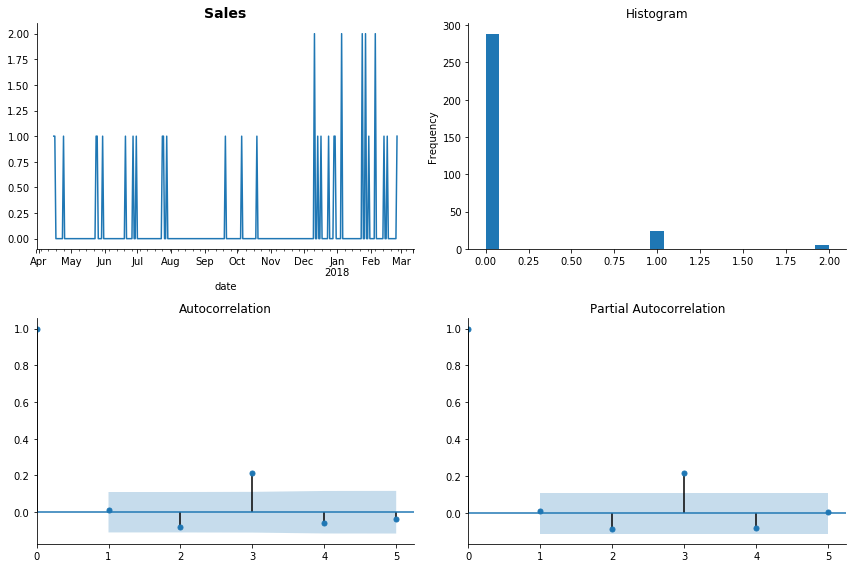

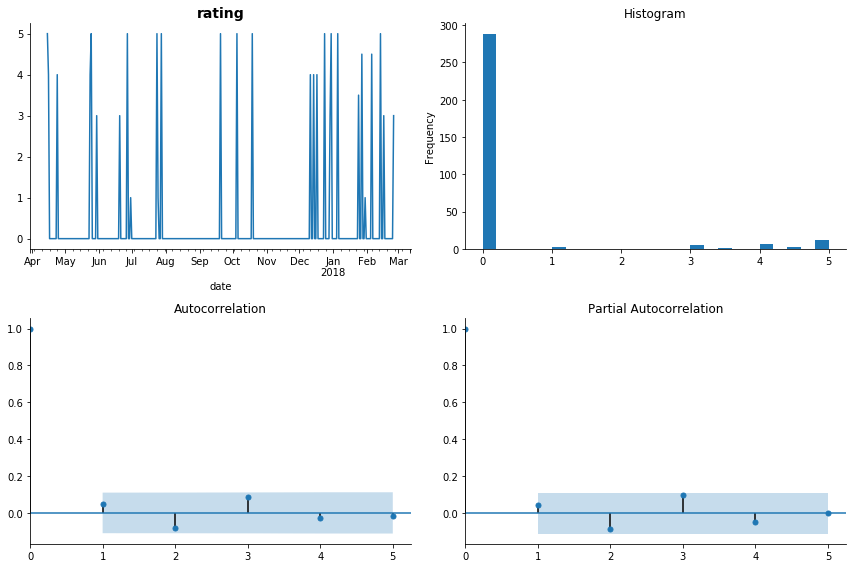

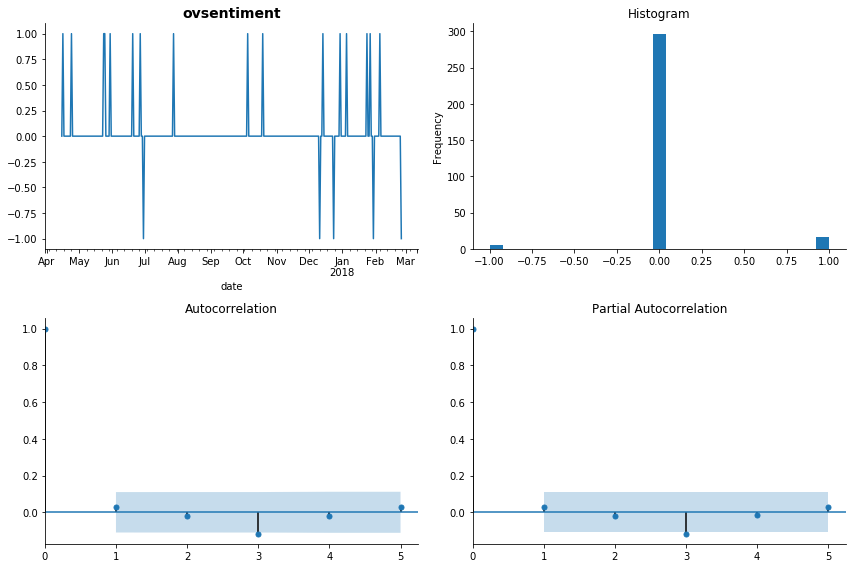

In [242]:
num_var9 = len(prod9.iloc[1, :])
for i in range(0, num_var9):
    tsplot(prod9.iloc[:, i].dropna(), title=prod9.columns[i], lags=5)
plt.show()

In [243]:
plt.clf()

<Figure size 432x288 with 0 Axes>

In [244]:
prod9_transformed = prod9.copy()
prod9_transformed['Sales'] = prod9_transformed['Sales'].diff(1)

prod9_transformed['rating'] = prod9_transformed['rating'].diff(1)
prod9_transformed['ovsentiment'] = prod9_transformed['ovsentiment'].diff(1)

prod9_transformed.dropna(inplace=True)

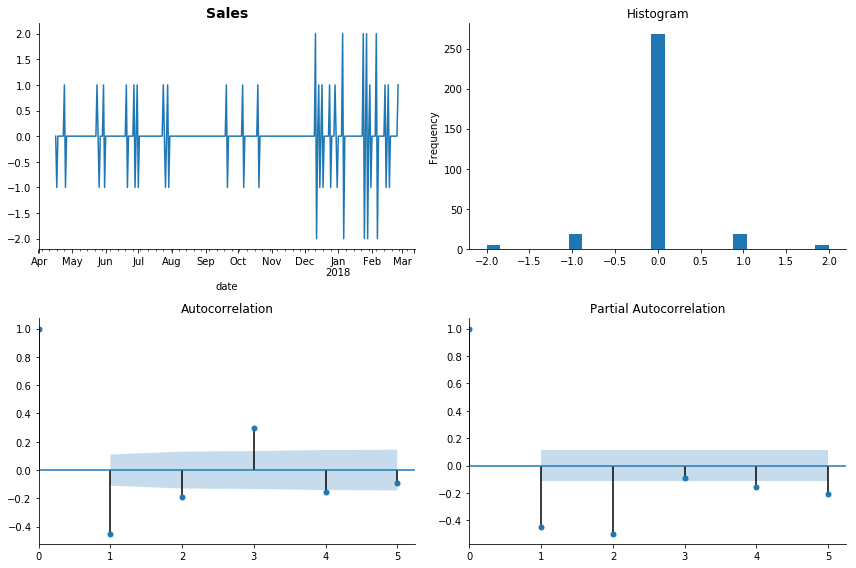

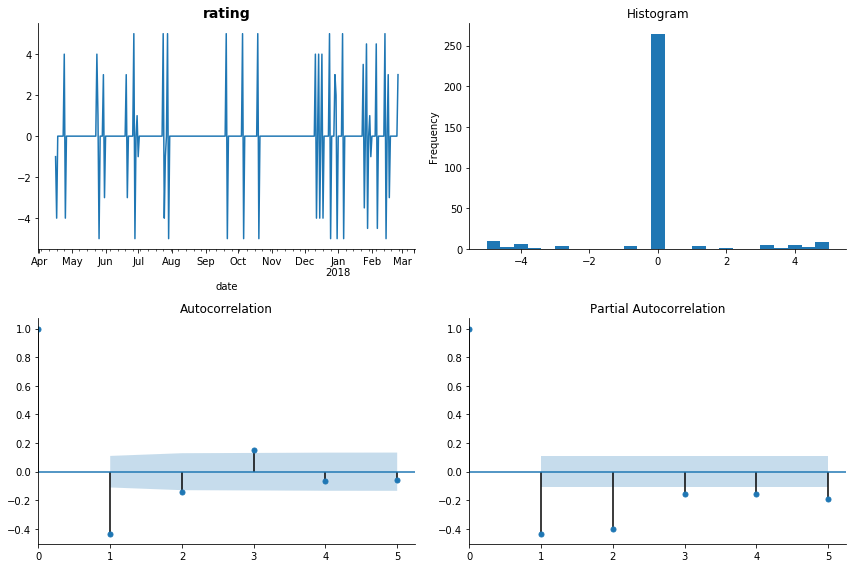

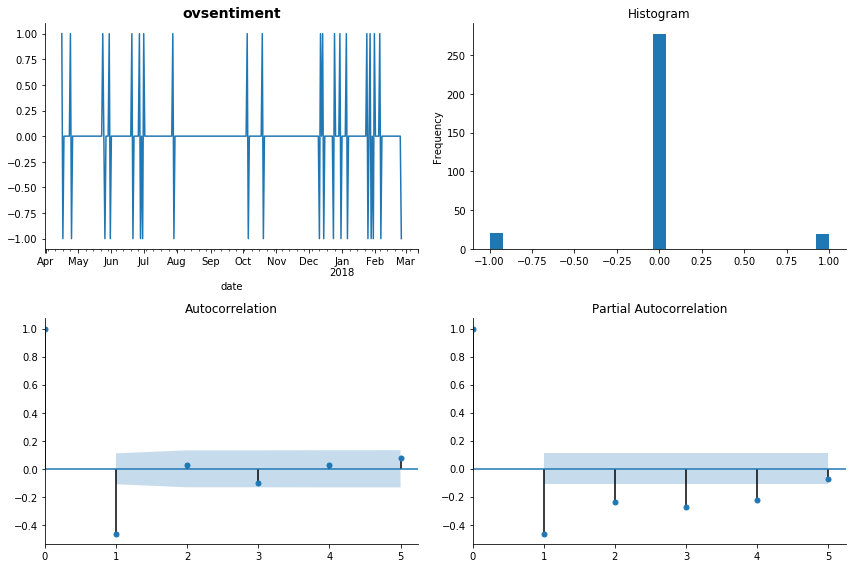

In [245]:
num_var9 = len(prod9_transformed.iloc[1, :])
for i in range(0, num_var9):
    tsplot(prod9_transformed.iloc[:, i].dropna(), title=prod9_transformed.columns[i], lags=5)
plt.show()

In [246]:
plt.clf()

<Figure size 432x288 with 0 Axes>

In [247]:
# Stationarity test (Augmented Dickey-Fuller test)
prod9_transformedTest = routines.tsTest(prod9_transformed['Sales'].dropna(), '5a9347b98cbad97074cb1890')
prod9_transformedTest.adfuller()

5a9347b98cbad97074cb1890


Value                        Label
0 -8.884630e+00               Test Statistic
1  6.625884e-13                      p-value
2  1.000000e+01                   #Lags Used
3  3.050000e+02  Number of Observations Used
4 -3.988763e+00        Critical value for 1%
5 -3.424983e+00        Critical value for 5%
6 -3.135570e+00       Critical value for 10%

In [248]:
# Stationarity test (Augmented Dickey-Fuller test)
prod9_transformedTest = routines.tsTest(prod9_transformed['rating'].dropna(), '5a9347b98cbad97074cb1890')
prod9_transformedTest.adfuller()

5a9347b98cbad97074cb1890


Value                        Label
0 -8.627366e+00               Test Statistic
1  2.559659e-12                      p-value
2  1.000000e+01                   #Lags Used
3  3.050000e+02  Number of Observations Used
4 -3.988763e+00        Critical value for 1%
5 -3.424983e+00        Critical value for 5%
6 -3.135570e+00       Critical value for 10%

In [249]:
# Stationarity test (Augmented Dickey-Fuller test)
prod9_transformedTest = routines.tsTest(prod9_transformed['ovsentiment'].dropna(), '5a9347b98cbad97074cb1890')
prod9_transformedTest.adfuller()

5a9347b98cbad97074cb1890


Value                        Label
0 -7.921649e+00               Test Statistic
1  1.084313e-10                      p-value
2  1.400000e+01                   #Lags Used
3  3.010000e+02  Number of Observations Used
4 -3.989165e+00        Critical value for 1%
5 -3.425177e+00        Critical value for 5%
6 -3.135684e+00       Critical value for 10%

In [250]:
# Train-Test Set Split
train9 = ceil(prod9_transformed.shape[0] * 0.8)
y_train9 = prod9_transformed[0:train9]
y_test9 = prod9_transformed[train9:]
y_train9.shape, y_test9.shape

BIC9 = detpq(y_train9, par=range(0,6))

In [251]:
BIC9

index   param         BIC
0       0  (0, 1)  342.438479
1       6  (1, 1)  434.676949
2       7  (1, 2)  448.128684
3      12  (2, 1)  467.033950
4      18  (3, 1)  469.352764
5       8  (1, 3)  495.683828
6      13  (2, 2)  498.891001
7      19  (3, 2)  505.055118
8      17  (3, 0)  508.776320
9      14  (2, 3)  512.359517
10     24  (4, 1)  513.399440
11     23  (4, 0)  518.886340
12      1  (0, 2)  522.982928
13     11  (2, 0)  526.109896
14     20  (3, 3)  528.783745
15     29  (5, 0)  538.883917
16     25  (4, 2)  547.381044
17      9  (1, 4)  548.729484
18     15  (2, 4)  557.099868
19     30  (5, 1)  560.390158
20     21  (3, 4)  566.309810
21      3  (0, 4)  574.408937
22     26  (4, 3)  575.150833
23      5  (1, 0)  576.322801
24     31  (5, 2)  581.104282
25     32  (5, 3)  609.178339
26     16  (2, 5)  609.411660
27     27  (4, 4)  610.324878
28     10  (1, 5)  611.638009
29     22  (3, 5)  615.192809
30      4  (0, 5)  618.155216
31      2  (0, 3)  647.459632
32     33  (5, 4)  653.778103
33     28  (4, 5)  698.521103
34     34  (5, 5)  702.274118

In [252]:
model9 = sm.tsa.VARMAX(y_train9, order=(3, 0))
result9 = model9.fit(maxiter=1000, disp=False)

result9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   Statespace Model Results                                   
==============================================================================================
Dep. Variable:     ['Sales', 'rating', 'ovsentiment']   No. Observations:                  253
Model:                                         VAR(3)   Log Likelihood                -154.787
                                          + intercept   AIC                            381.574
Date:                                Sat, 15 Sep 2018   BIC                            508.776
Time:                                        14:51:42   HQIC                           432.752
Sample:                                    04-16-2017                                         
                                         - 12-24-2017                                         
Covariance Type:                                  opg                                         
===========================================================================================
Ljung-Box (Q):          30.88, 40.61, 60.45   Jarque-Bera (JB):   1902.98, 4482.24, 5879.90
Prob(Q):                   0.85, 0.44, 0.02   Prob(JB):                    0.00, 0.00, 0.00
Heteroskedasticity (H):    0.92, 1.28, 0.92   Skew:                      2.61, -2.26, -1.35
Prob(H) (two-sided):       0.69, 0.26, 0.72   Kurtosis:                 15.38, 23.12, 26.46
                            Results for equation Sales                            
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0018      0.040     -0.044      0.965      -0.080       0.077
L1.Sales          -1.0849      0.521     -2.081      0.037      -2.107      -0.063
L1.rating          0.1202      0.110      1.097      0.273      -0.095       0.335
L1.ovsentiment    -0.1152      0.187     -0.616      0.538      -0.482       0.252
L2.Sales          -0.8372      0.533     -1.572      0.116      -1.881       0.207
L2.rating          0.0916      0.120      0.765      0.444      -0.143       0.326
L2.ovsentiment    -0.0933      0.203     -0.459      0.646      -0.492       0.305
L3.Sales           0.0343      0.479      0.071      0.943      -0.905       0.973
L3.rating         -0.0455      0.106     -0.428      0.669      -0.254       0.163
L3.ovsentiment     0.0201      0.179      0.112      0.911      -0.331       0.371
                           Results for equation rating                            
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0081      0.153     -0.053      0.958      -0.307       0.291
L1.Sales          -0.8221      1.962     -0.419      0.675      -4.668       3.023
L1.rating         -0.4955      0.400     -1.240      0.215      -1.279       0.288
L1.ovsentiment     0.1905      0.572      0.333      0.739      -0.931       1.312
L2.Sales          -0.9059      2.244     -0.404      0.686      -5.304       3.493
L2.rating         -0.3239      0.483     -0.670      0.503      -1.271       0.624
L2.ovsentiment     0.1793      0.832      0.215      0.829      -1.452       1.810
L3.Sales           1.6638      1.941      0.857      0.391      -2.140       5.468
L3.rating         -0.6444      0.395     -1.631      0.103      -1.419       0.130
L3.ovsentiment     0.3255      0.706      0.461      0.645      -1.058       1.709
                         Results for equation ovsentiment                         
==================================================================================
                     coef    std err          z     

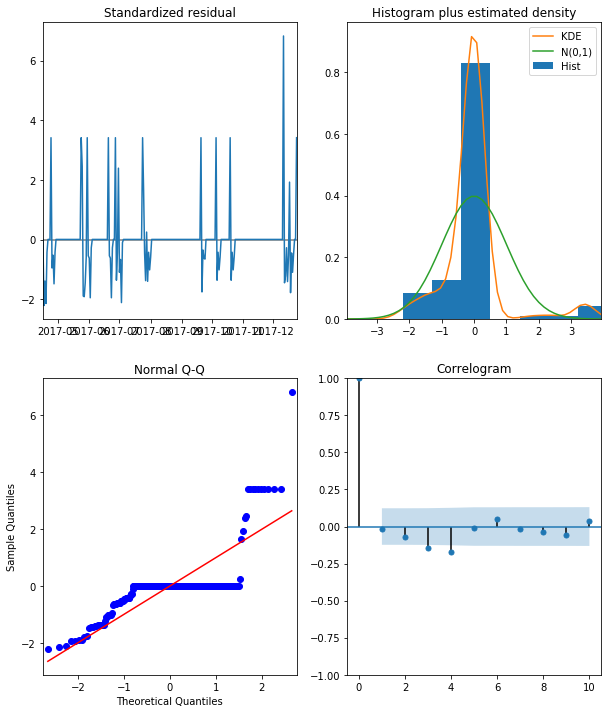

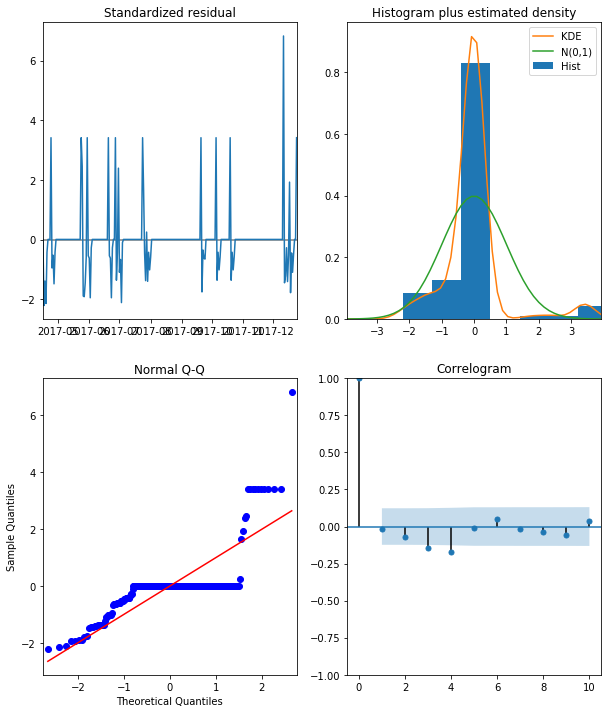

In [253]:
result9.plot_diagnostics(figsize=(10, 12))

In [254]:
plt.clf()
y_test9.shape

(63, 3)

<Figure size 432x288 with 0 Axes>

In [255]:
y_pred9 = result9.get_prediction(start=train9+1, end=prod9_transformed.shape[0])
y_forecasted9 = y_pred9.predicted_mean
y_forecasted9.shape

(63, 3)

In [256]:
np.sqrt(mean_squared_error(y_pred=y_forecasted9, y_true=y_test9))

1.3945296371207534

In [257]:
mean_absolute_error(y_pred=y_forecasted9, y_true=y_test9)

0.6311025187863125

## <font color=blue> 10. Mongodb ID: 5a9347b98cbad97074cb1890-imputed </font>

In [258]:
prod10 = genData('5a9347b98cbad97074cb1890', conn, c, impute=True, freq='daily', standardize=False)

In [259]:
# Stationarity test (Augmented Dickey-Fuller test)
prod10Test = routines.tsTest(prod10['Sales'], '5a9347b98cbad97074cb1890')
prod10Test.adfuller()

5a9347b98cbad97074cb1890


Value                        Label
0  -17.420776               Test Statistic
1    0.000000                      p-value
2    0.000000                   #Lags Used
3  315.000000  Number of Observations Used
4   -3.987801        Critical value for 1%
5   -3.424520        Critical value for 5%
6   -3.135299       Critical value for 10%

In [260]:
# Stationarity test (Augmented Dickey-Fuller test)
prod10Test = routines.tsTest(prod10['rating'], '5a9347b98cbad97074cb1890')
prod10Test.adfuller()

5a9347b98cbad97074cb1890


Value                        Label
0 -1.007007e+01               Test Statistic
1  1.640740e-15                      p-value
2  2.000000e+00                   #Lags Used
3  3.130000e+02  Number of Observations Used
4 -3.987988e+00        Critical value for 1%
5 -3.424611e+00        Critical value for 5%
6 -3.135351e+00       Critical value for 10%

In [261]:
# Stationarity test (Augmented Dickey-Fuller test)
prod10Test = routines.tsTest(prod10['ovsentiment'], '5a9347b98cbad97074cb1890')
prod10Test.adfuller()

5a9347b98cbad97074cb1890


Value                        Label
0 -1.170446e+01               Test Statistic
1  1.189856e-18                      p-value
2  2.000000e+00                   #Lags Used
3  3.130000e+02  Number of Observations Used
4 -3.987988e+00        Critical value for 1%
5 -3.424611e+00        Critical value for 5%
6 -3.135351e+00       Critical value for 10%

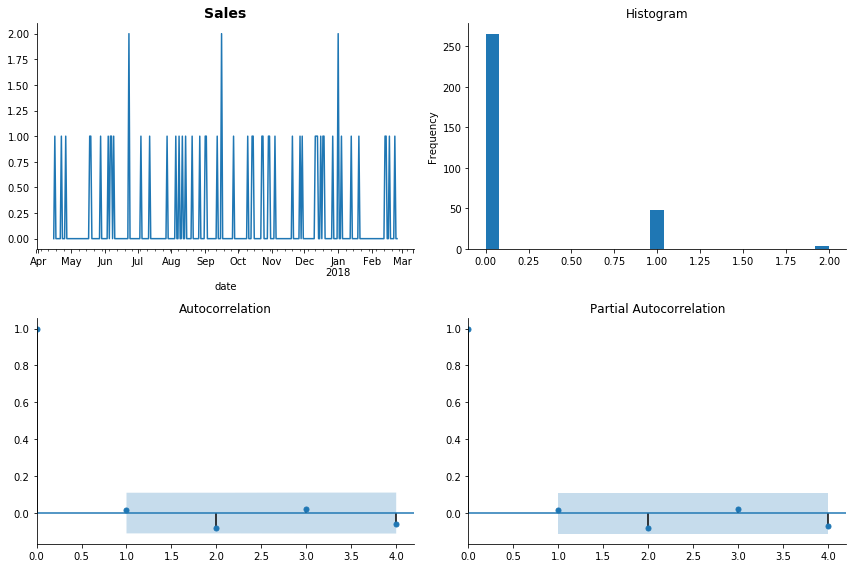

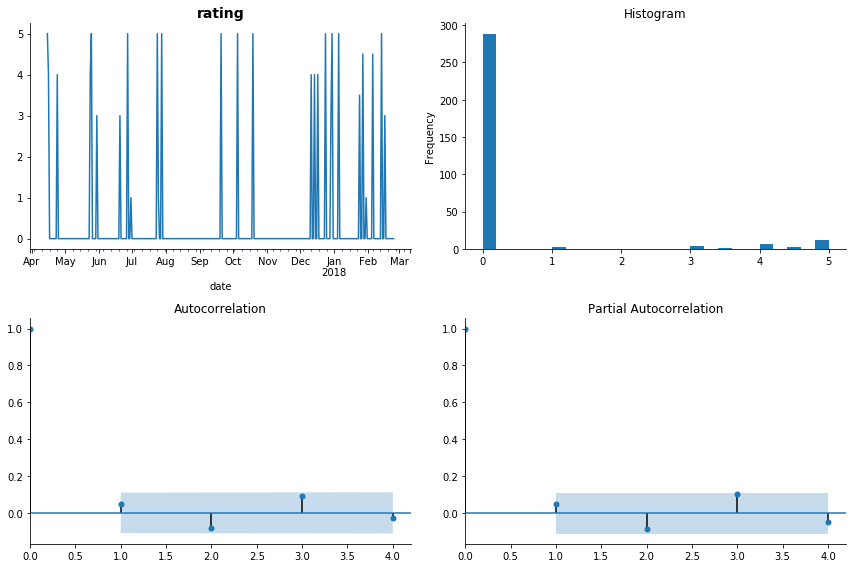

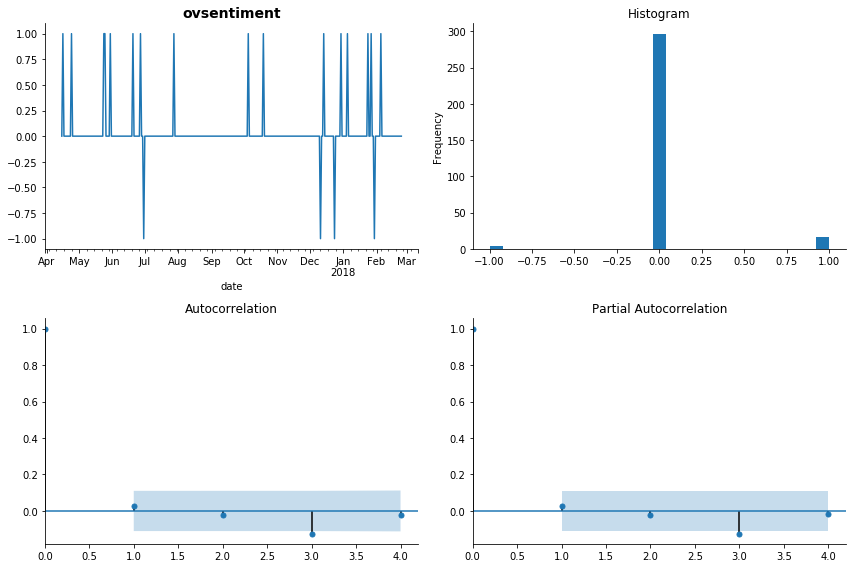

In [262]:
num_var10 = len(prod10.iloc[1, :])
for i in range(0, num_var10):
    tsplot(prod10.iloc[:, i].dropna(), title=prod10.columns[i], lags=4)
plt.show()

In [263]:
plt.clf()

<Figure size 432x288 with 0 Axes>

In [264]:
prod10_transformed = prod10.copy()
prod10_transformed['Sales'] = prod10_transformed['Sales'].diff(1)

prod10_transformed['rating'] = prod10_transformed['rating'].diff(1)
prod10_transformed['ovsentiment'] = prod10_transformed['ovsentiment'].diff(1)

prod10_transformed.dropna(inplace=True)

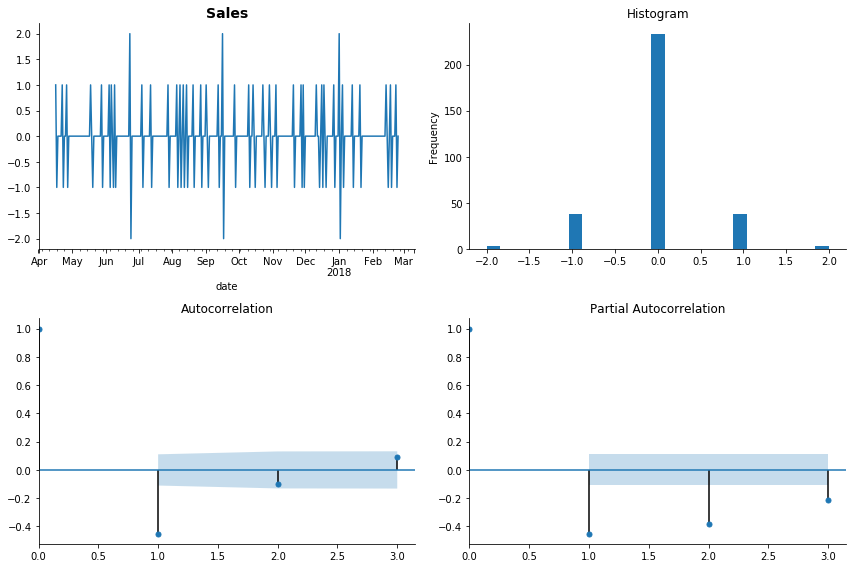

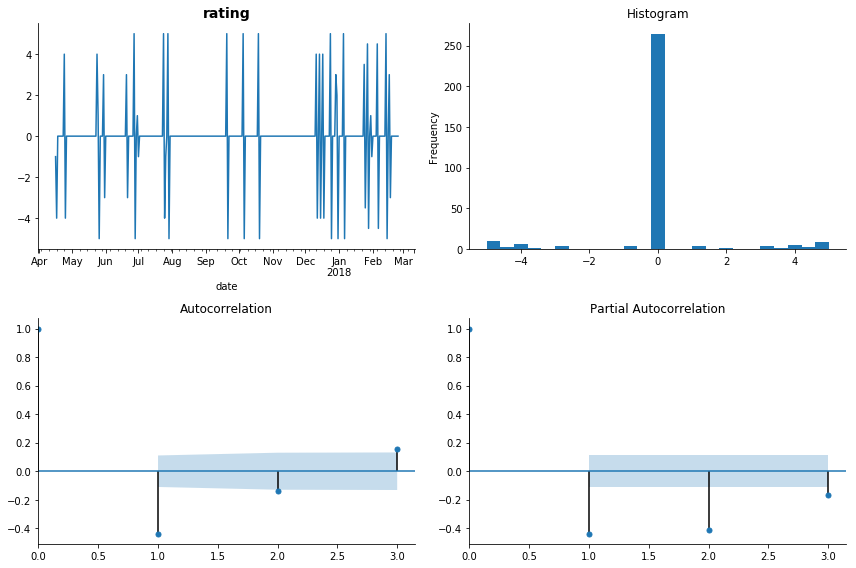

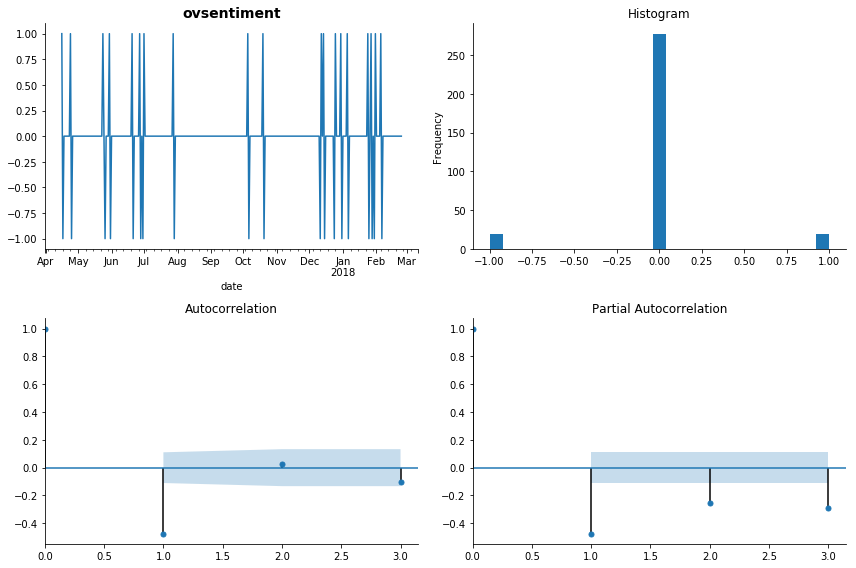

In [265]:
num_var10 = len(prod10_transformed.iloc[1, :])
for i in range(0, num_var10):
    tsplot(prod10_transformed.iloc[:, i].dropna(), title=prod10_transformed.columns[i], lags=3)
plt.show()

In [266]:
plt.clf()

<Figure size 432x288 with 0 Axes>

In [267]:
# Stationarity test (Augmented Dickey-Fuller test)
prod10_transformedTest = routines.tsTest(prod10_transformed['Sales'].dropna(), '5a9347b98cbad97074cb1890')
prod10_transformedTest.adfuller()

5a9347b98cbad97074cb1890


Value                        Label
0 -8.978272e+00               Test Statistic
1  4.064109e-13                      p-value
2  1.400000e+01                   #Lags Used
3  3.000000e+02  Number of Observations Used
4 -3.989268e+00        Critical value for 1%
5 -3.425227e+00        Critical value for 5%
6 -3.135713e+00       Critical value for 10%

In [268]:
# Stationarity test (Augmented Dickey-Fuller test)
prod10_transformedTest = routines.tsTest(prod10_transformed['rating'].dropna(), '5a9347b98cbad97074cb1890')
prod10_transformedTest.adfuller()

5a9347b98cbad97074cb1890


Value                        Label
0 -1.184522e+01               Test Statistic
1  6.891455e-19                      p-value
2  6.000000e+00                   #Lags Used
3  3.080000e+02  Number of Observations Used
4 -3.988467e+00        Critical value for 1%
5 -3.424841e+00        Critical value for 5%
6 -3.135487e+00       Critical value for 10%

In [269]:
# Stationarity test (Augmented Dickey-Fuller test)
prod10_transformedTest = routines.tsTest(prod10_transformed['ovsentiment'].dropna(), '5a9347b98cbad97074cb1890')
prod10_transformedTest.adfuller()

5a9347b98cbad97074cb1890


Value                        Label
0 -8.122267e+00               Test Statistic
1  3.727115e-11                      p-value
2  1.400000e+01                   #Lags Used
3  3.000000e+02  Number of Observations Used
4 -3.989268e+00        Critical value for 1%
5 -3.425227e+00        Critical value for 5%
6 -3.135713e+00       Critical value for 10%

In [270]:
# Train-Test Set Split
train10 = ceil(prod10_transformed.shape[0] * 0.8)
y_train10 = prod10_transformed[0:train10]
y_test10 = prod10_transformed[train10:]
y_train10.shape, y_test10.shape

BIC10 = detpq(y_train10, par=range(0,6))

In [271]:
BIC10

index   param          BIC
0       0  (0, 1)   959.216803
1       6  (1, 1)  1015.424284
2      12  (2, 1)  1065.695758
3       7  (1, 2)  1076.879501
4       1  (0, 2)  1113.053754
5       8  (1, 3)  1119.853736
6      18  (3, 1)  1120.795091
7      13  (2, 2)  1124.389602
8      14  (2, 3)  1135.299041
9      19  (3, 2)  1142.515269
10     24  (4, 1)  1151.661513
11     17  (3, 0)  1166.410902
12     20  (3, 3)  1173.748553
13     23  (4, 0)  1174.222623
14     29  (5, 0)  1176.017835
15     15  (2, 4)  1179.809428
16     11  (2, 0)  1180.550814
17      2  (0, 3)  1183.389928
18      9  (1, 4)  1191.484583
19     25  (4, 2)  1191.579803
20     30  (5, 1)  1203.056942
21      3  (0, 4)  1206.290756
22     26  (4, 3)  1208.833533
23     21  (3, 4)  1212.420620
24      5  (1, 0)  1231.115347
25     31  (5, 2)  1232.313732
26     10  (1, 5)  1243.132361
27     16  (2, 5)  1243.859179
28     27  (4, 4)  1253.715975
29     22  (3, 5)  1260.055604
30     32  (5, 3)  1270.819059
31      4  (0, 5)  1272.397293
32     33  (5, 4)  1302.469757
33     28  (4, 5)  1307.969308
34     34  (5, 5)  1346.125766

In [272]:
model10 = sm.tsa.VARMAX(y_train10, order=(3, 0))
result10 = model10.fit(maxiter=1000, disp=False)

result10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   Statespace Model Results                                   
==============================================================================================
Dep. Variable:     ['Sales', 'rating', 'ovsentiment']   No. Observations:                  252
Model:                                         VAR(3)   Log Likelihood                -483.676
                                          + intercept   AIC                           1039.351
Date:                                Sat, 15 Sep 2018   BIC                           1166.411
Time:                                        15:11:56   HQIC                          1090.478
Sample:                                    04-16-2017                                         
                                         - 12-23-2017                                         
Covariance Type:                                  opg                                         
=========================================================================================
Ljung-Box (Q):          57.22, 28.02, 53.10   Jarque-Bera (JB):   118.46, 665.13, 6201.31
Prob(Q):                   0.04, 0.92, 0.08   Prob(JB):                  0.00, 0.00, 0.00
Heteroskedasticity (H):    0.98, 0.75, 1.05   Skew:                     1.39, 1.83, -2.31
Prob(H) (two-sided):       0.92, 0.20, 0.82   Kurtosis:                4.90, 10.07, 26.86
                            Results for equation Sales                            
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0009      0.046     -0.019      0.985      -0.091       0.090
L1.Sales          -0.6871      0.066    -10.352      0.000      -0.817      -0.557
L1.rating          0.0420      0.053      0.792      0.428      -0.062       0.146
L1.ovsentiment    -0.3621      0.248     -1.460      0.144      -0.848       0.124
L2.Sales          -0.4750      0.075     -6.346      0.000      -0.622      -0.328
L2.rating          0.0580      0.073      0.791      0.429      -0.086       0.202
L2.ovsentiment    -0.3745      0.292     -1.281      0.200      -0.947       0.198
L3.Sales          -0.2061      0.079     -2.603      0.009      -0.361      -0.051
L3.rating         -0.0070      0.054     -0.130      0.897      -0.112       0.099
L3.ovsentiment    -0.0012      0.210     -0.005      0.996      -0.412       0.410
                           Results for equation rating                            
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0310      0.120     -0.259      0.795      -0.265       0.203
L1.Sales          -0.1863      0.330     -0.565      0.572      -0.833       0.460
L1.rating         -0.7368      0.098     -7.545      0.000      -0.928      -0.545
L1.ovsentiment     0.3426      0.434      0.789      0.430      -0.509       1.194
L2.Sales          -0.2369      0.323     -0.735      0.463      -0.869       0.395
L2.rating         -0.6096      0.130     -4.677      0.000      -0.865      -0.354
L2.ovsentiment     0.3499      0.536      0.653      0.514      -0.700       1.400
L3.Sales          -0.5075      0.162     -3.134      0.002      -0.825      -0.190
L3.rating         -0.2164      0.112     -1.928      0.054      -0.436       0.004
L3.ovsentiment    -0.0918      0.464     -0.198      0.843      -1.002       0.818
                         Results for equation ovsentiment                         
==================================================================================
                     coef    std err          z      P>|z|    

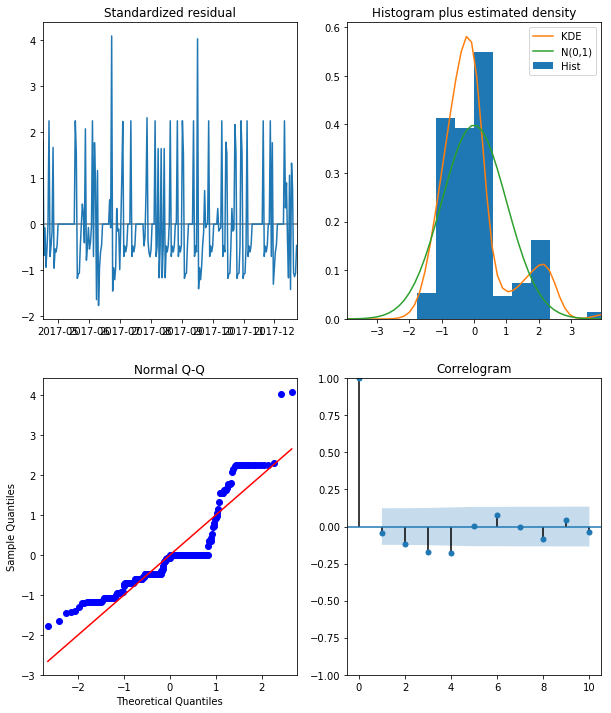

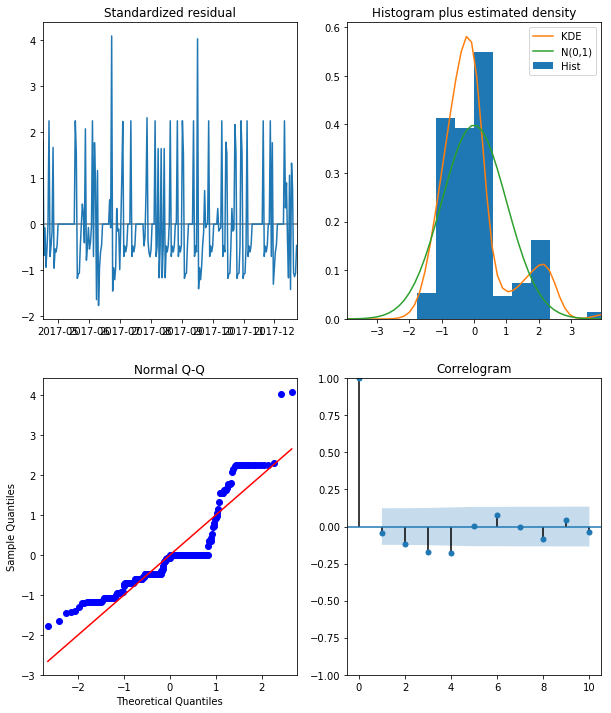

In [273]:
result10.plot_diagnostics(figsize=(10, 12))

In [274]:
plt.clf()
y_test10.shape

(63, 3)

<Figure size 432x288 with 0 Axes>

In [275]:
y_pred10 = result10.get_prediction(start=train10+1, end=prod10_transformed.shape[0])
y_forecasted10 = y_pred10.predicted_mean
y_forecasted10.shape

(63, 3)

In [276]:
np.sqrt(mean_squared_error(y_pred=y_forecasted10, y_true=y_test10))

1.359913432004854

In [277]:
mean_absolute_error(y_pred=y_forecasted10, y_true=y_test10)

0.5589077460713625